# Import Libraries

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import matplotlib.pyplot as plt


# Read Dataset

In [ ]:
df = pd.read_csv('/content/airline-passengers.csv')
df.head()

Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df['Month'] = pd.to_datetime(df['Month'])

In [ ]:
Data = df.set_index('Month')

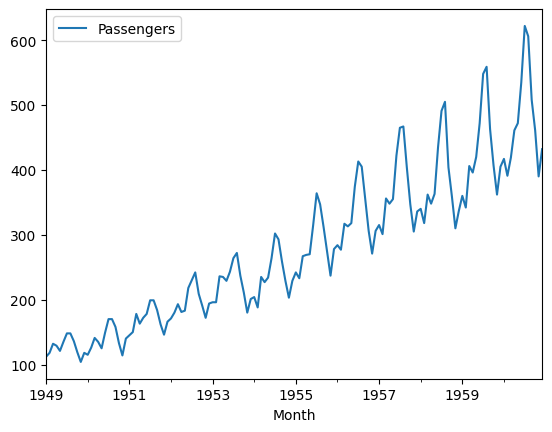

In [ ]:
Data.plot()
plt.show()

- This data is Seasonlaity with postive trend 
- We found that there is a peak every year between july and August

# split the Data

In [ ]:
def Split(Data,train_size = 96,val_size = 24,Fixed_Partition = False,Roll_Forward= False,window_size = 1,Cross_validator =False):
    if Fixed_Partition:
        train_data = Data[:train_size]
        val_data = Data[train_size:train_size+val_size]
        test_data = Data[train_size+val_size:]
       
        return train_data,val_data,test_data
    
    
    if Roll_Forward:
        window_size = window_size
        train_data = []
        test_data = []
        for i in range(100,len(Data)):
            # Define the start and end times for the training and testing partitions
            train_start = Data.index[0]
            train_end = Data.index[i]
            test_start = Data.index[i-1]
            test_end = Data.index[i] 

            # Split the data set into training and testing partitions
            train_partition = Data[(Data.index >= train_start) & (Data.index < train_end)]
            test_partition = Data[ (Data.index == test_end)]

            # Append the partitions to the corresponding lists
            train_data.append(train_partition)
            test_data.append(test_partition)
        return train_data,test_data
    
    if Cross_validator:
        tscv = TimeSeriesSplit()
        train_data = []
        test_data = []

        for i, (train_index, test_index) in enumerate(tscv.split(Data)):
                train_data.append(train_index)
                test_data.append(np.arange(train_index[-1],len(Data)))
                
        return   train_data,test_data      
        

In [ ]:
train_data,val_data,test_data  = Split(Data,Fixed_Partition = True)


In [ ]:
len(train_data)+len(val_data)+len(test_data) 

144

In [ ]:
def Evalution(test,pred):
    print(f'RMSE --->  {np.sqrt(mean_squared_error(test, pred))}')

In [ ]:
Evalution([129,142,156,183],[118,141,158,163])

RMSE --->  11.467344941179714


In [ ]:
Evalution([129,142,156,183],[130,146,170,180])

RMSE --->  7.44983221287567


# Naive Forecasting


## Fixed Partion

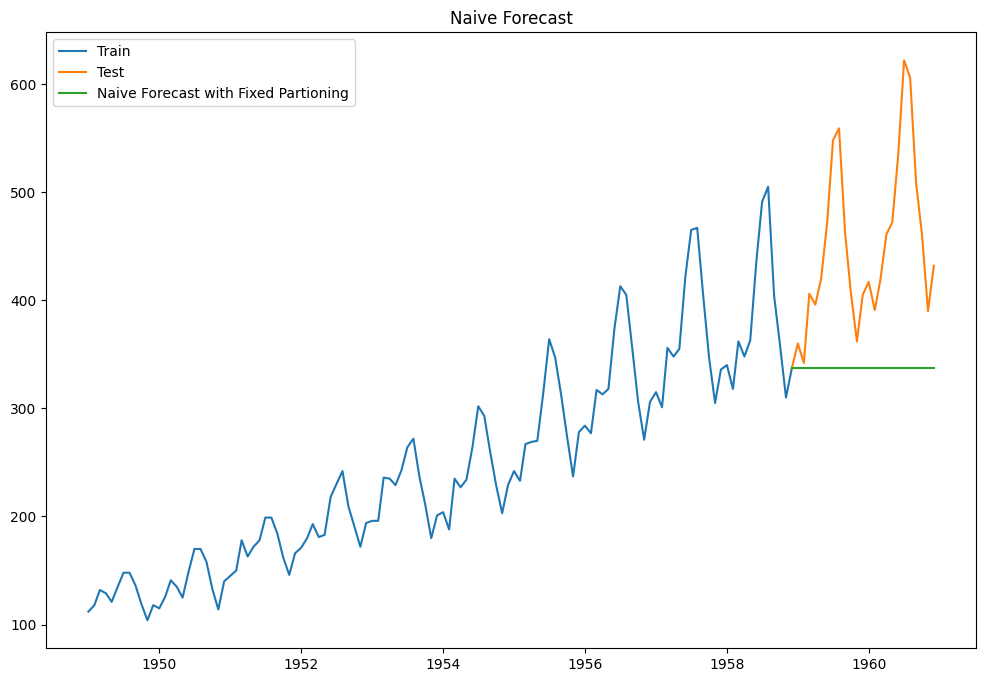

In [ ]:
train_data,val_data,test_data  = Split(Data,Fixed_Partition = True)
data_train = train_data.append(val_data)
y_hat = test_data.copy()
y_hat['naive'] = data_train['Passengers'].iloc[len(data_train)-1]
plt.figure(figsize=(12,8))
plt.plot(data_train.index, data_train['Passengers'], label='Train')
plt.plot(test_data.index,test_data['Passengers'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast with Fixed Partioning')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

- Fixed Partition: Navie Forcast is too bad with long term As it perdict only the last entery so it appears constant in the long term periods 

In [ ]:
Evalution(test_data['Passengers'],y_hat['naive'])

RMSE --->  134.55437562561838


## Roll-Forward

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)


101

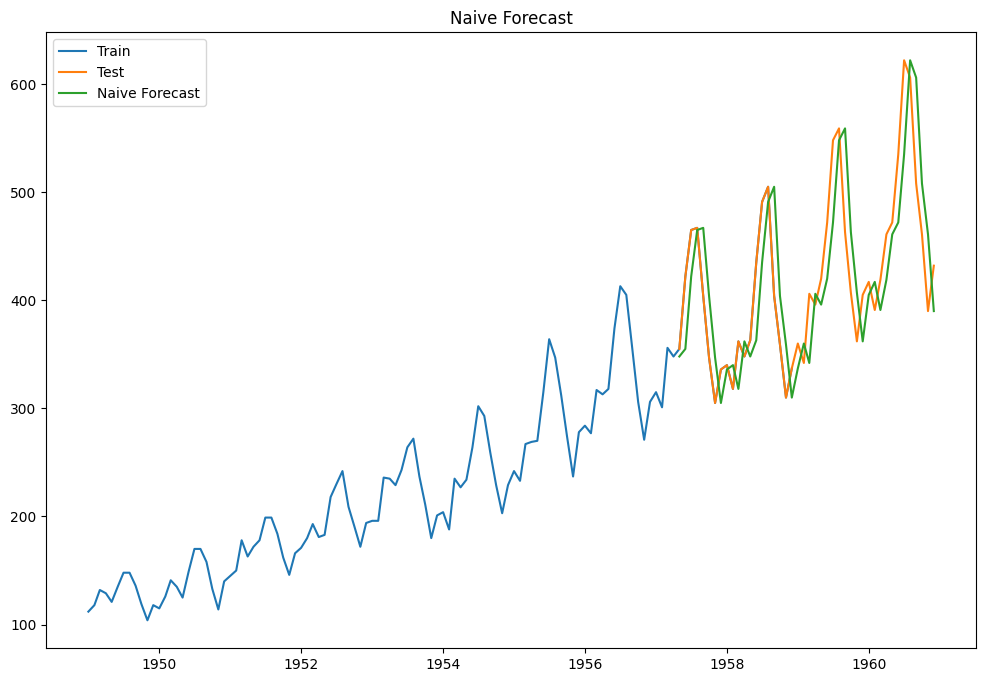

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)
Naive = []
test_index = []
test_val = []
for train,test in zip(train_data,test_data):
    y_hat = test.copy()
    Naive.append(train['Passengers'].iloc[len(train)-1])
    test_val.append(test['Passengers'])
    test_index.append(test.index)
plt.figure(figsize=(12,8))
plt.plot(data_train.index, data_train['Passengers'], label='Train')
plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,Naive, label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [ ]:
Evalution(test_val,Naive)

RMSE --->  49.4092372666562


- Roll Forward : It's the best technique for using naive forecast model as the model perdict short periods of time also it retrained by the actual new short period, so it generates a very good results

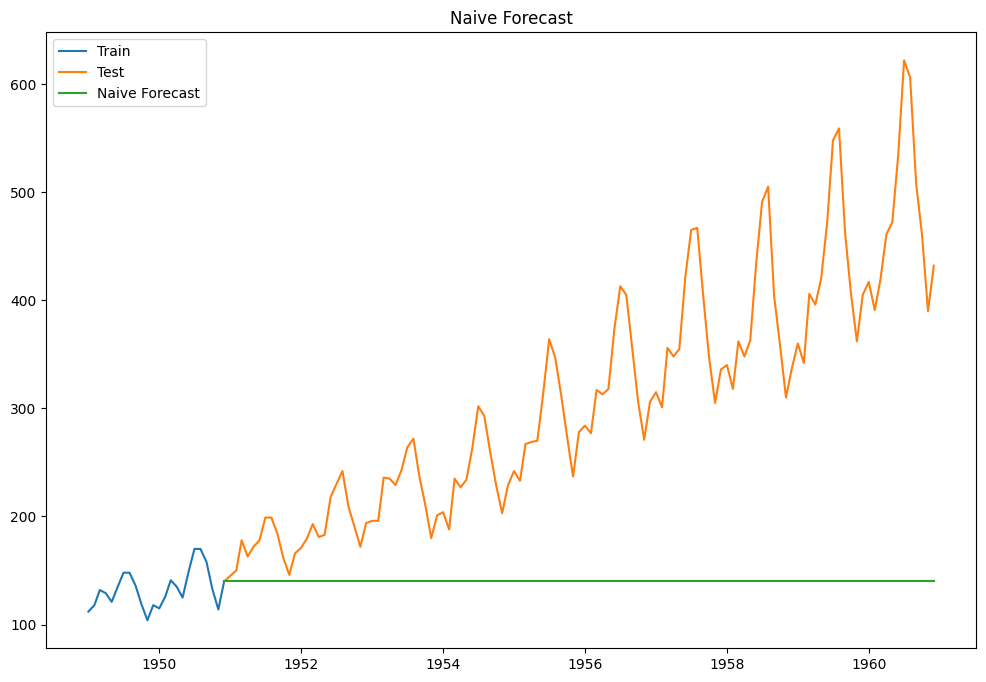

RMSE --->  200.9130192952016


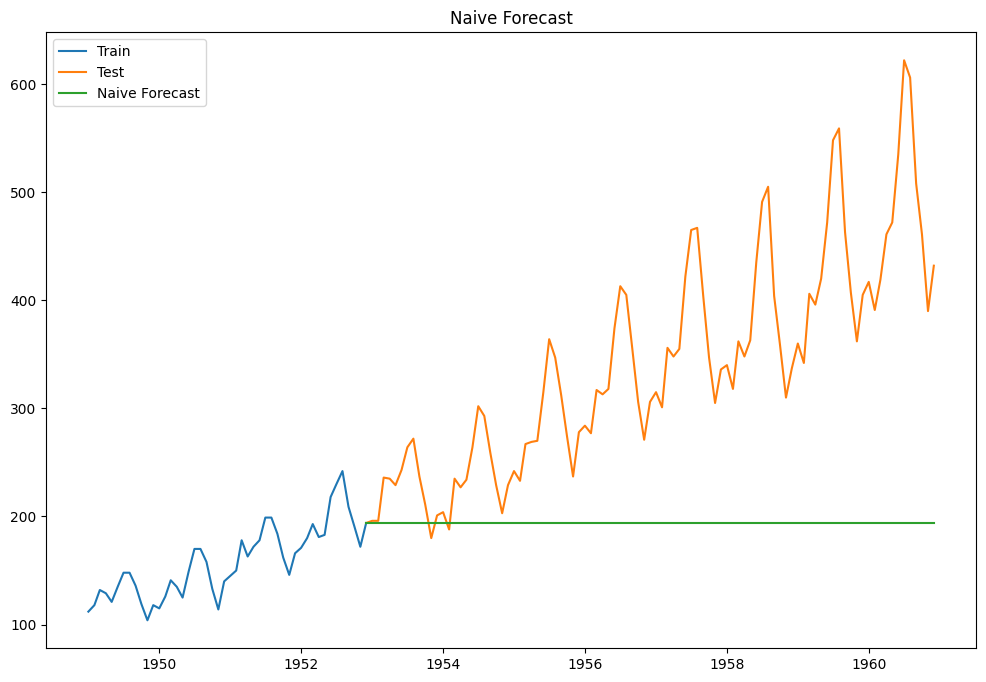

RMSE --->  176.39310012921672


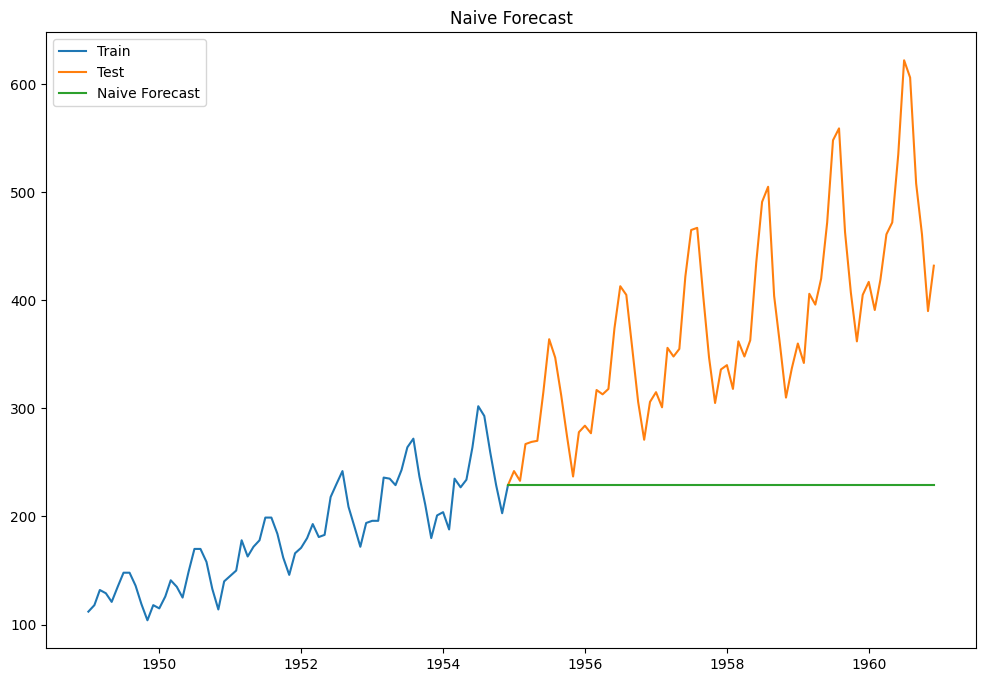

RMSE --->  170.51155908272588


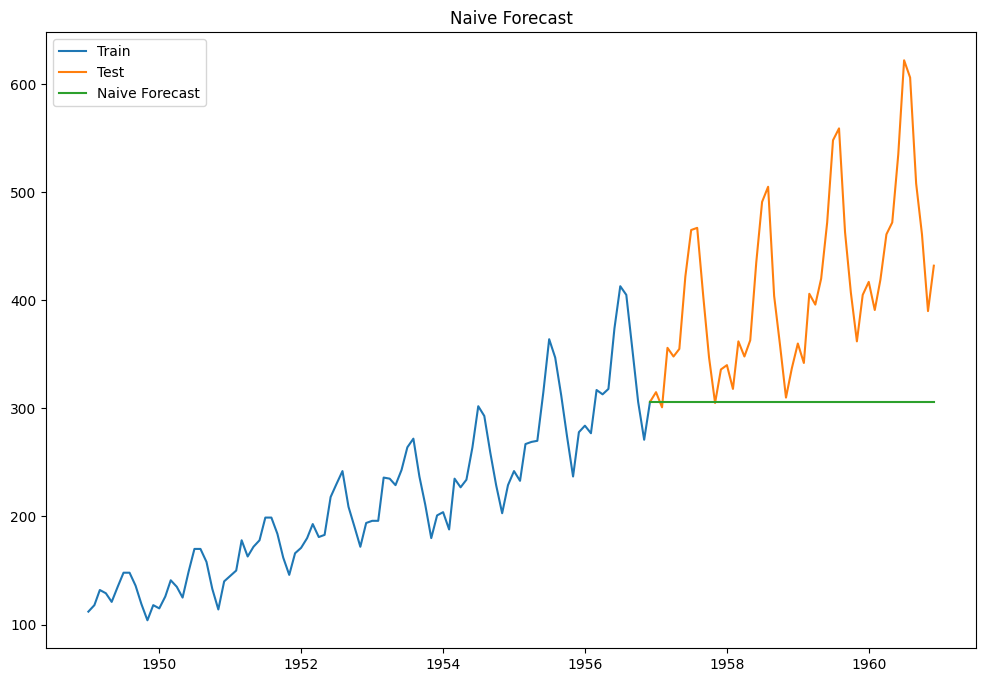

RMSE --->  131.24980077730262


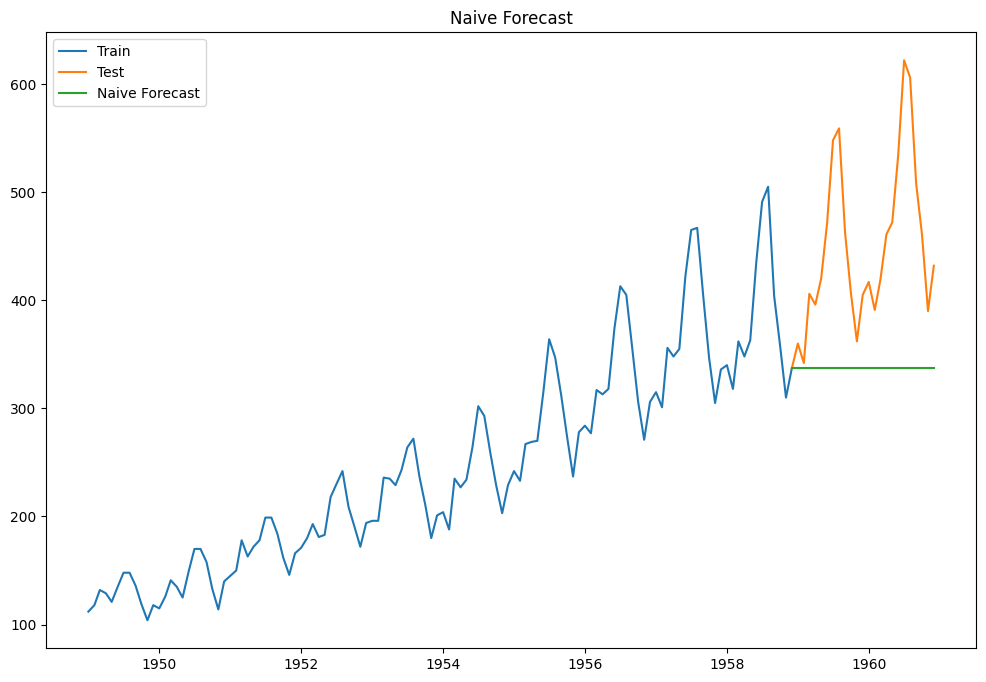

RMSE --->  134.55437562561838
Mean RMSE --> 162.72437098201303


In [ ]:
Eval_list= []
train_data,test_data  = Split(Data,Cross_validator = True)
for train,test in zip(train_data,test_data):
    train_d = Data.iloc[train]
    test_d = Data.iloc[test]
    y_hat = test_d.copy()
#     print(y_hat)
#     print( train_d['#Passengers'][len(train)-1])
    y_hat['naive'] = train_d['Passengers'][len(train)-1]
    plt.figure(figsize=(12,8))
    plt.plot(train_d.index, train_d['Passengers'], label='Train')
    plt.plot(test_d.index,test_d['Passengers'], label='Test')
    plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
    plt.legend(loc='best')
    plt.title("Naive Forecast")
    plt.show()
    Eval_list.append(np.sqrt(mean_squared_error(test_d['Passengers'],y_hat['naive'])))

    Evalution(test_d['Passengers'],y_hat['naive'])
print(f'Mean RMSE --> {np.mean(Eval_list)}')

- Overall naive forcast is too bad with long periods as it rely on the latest entry but with short period its good

# Simple Average

## Fixed

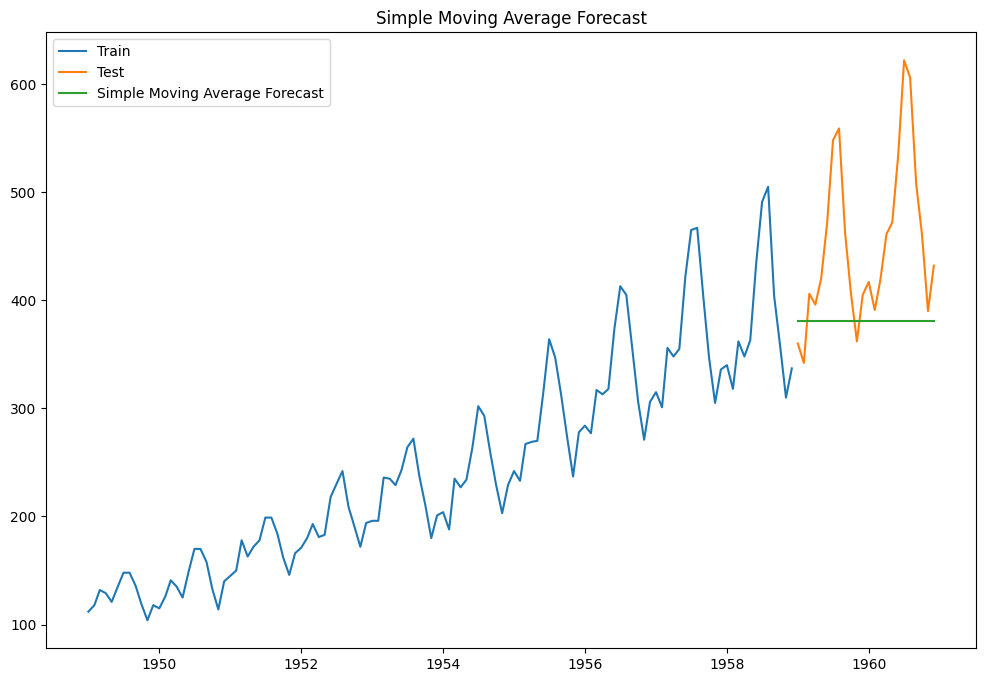

In [ ]:
train_data, val_data, test_data = Split(Data, Fixed_Partition=True)
data_train = train_data.append(val_data)
y_hat = test_data.copy()
y_hat['SMA'] = data_train['Passengers'].rolling(window=12).mean().iloc[-1]
plt.figure(figsize=(12, 8))
plt.plot(data_train.index, data_train['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(y_hat.index, y_hat['SMA'], label='Simple Moving Average Forecast')
plt.legend(loc='best')
plt.title("Simple Moving Average Forecast")
plt.show()


In [ ]:
Evalution(test_data['Passengers'],y_hat['SMA'])

RMSE --->  101.51137867254094


## ROLL

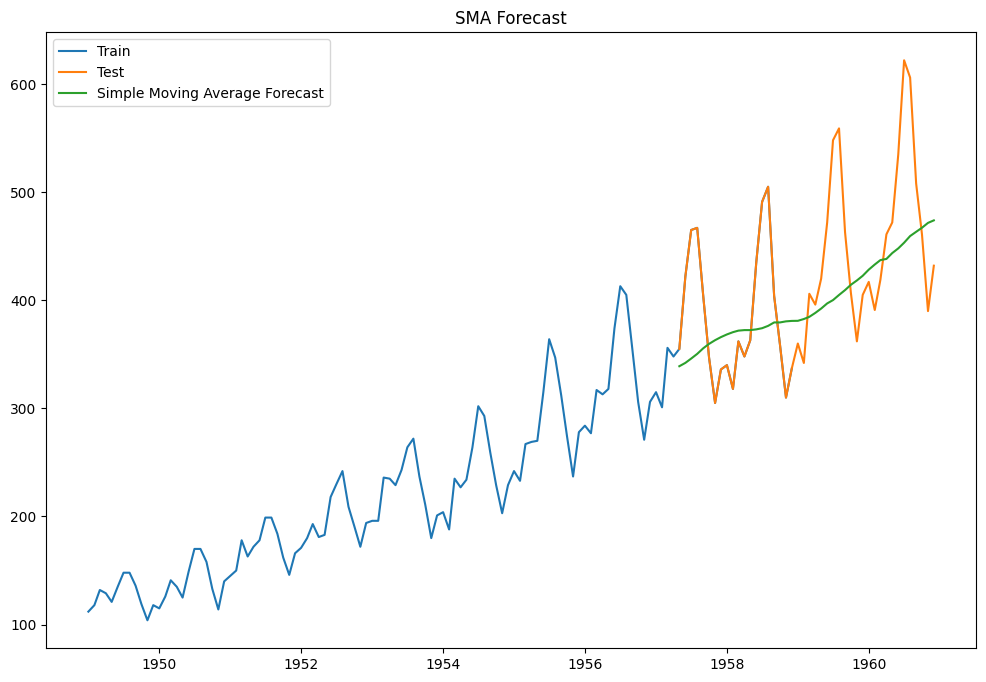

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)
SMA = []
test_index = []
test_val = []
for train,test in zip(train_data,test_data):
    y_hat = test.copy()
    SMA.append(train['Passengers'].rolling(window=12).mean().iloc[-1])
    test_val.append(test['Passengers'])
    test_index.append(test.index)
plt.figure(figsize=(12,8))
plt.plot(data_train.index, data_train['Passengers'], label='Train')
plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,SMA, label='Simple Moving Average Forecast')
plt.legend(loc='best')
plt.title("SMA Forecast")
plt.show()

In [ ]:
Evalution(test_val,SMA)

RMSE --->  70.70658222684801


## Cross

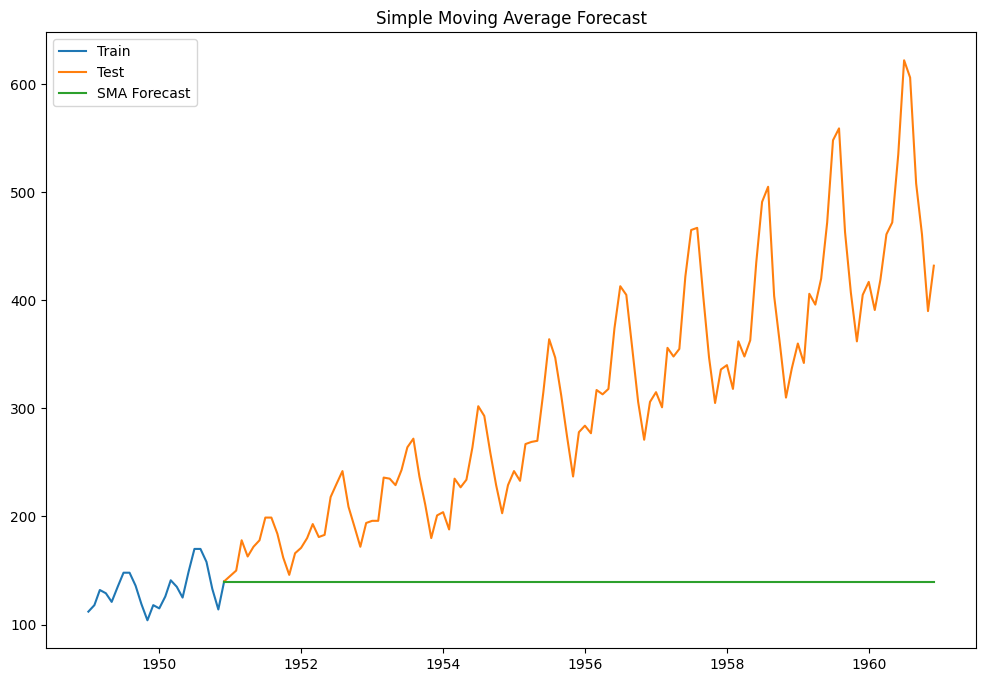

RMSE --->  201.19236394420696


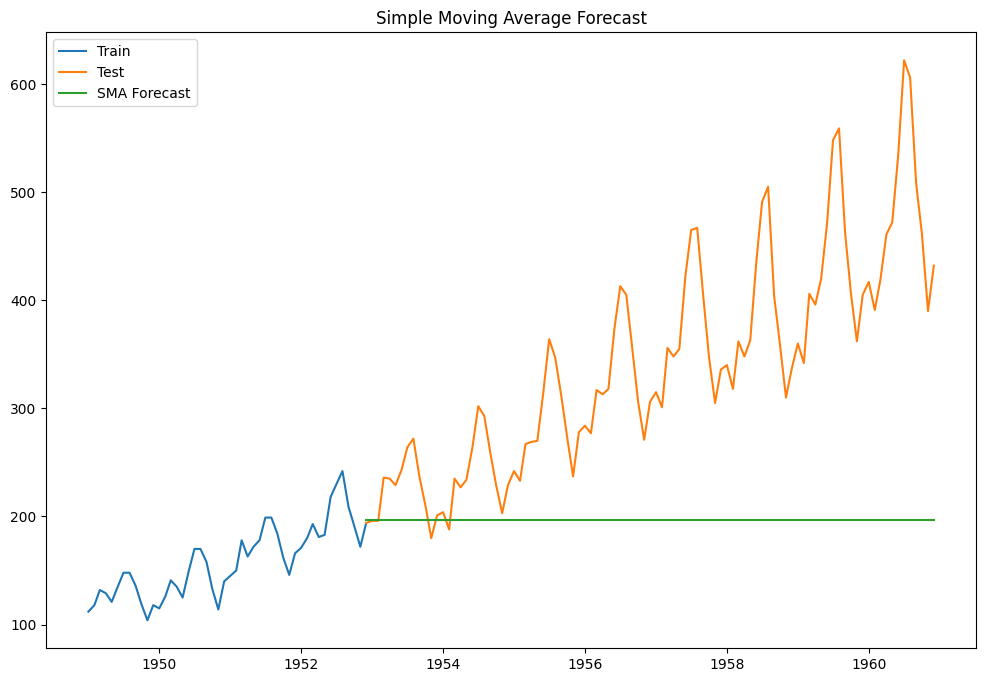

RMSE --->  173.92260395057468


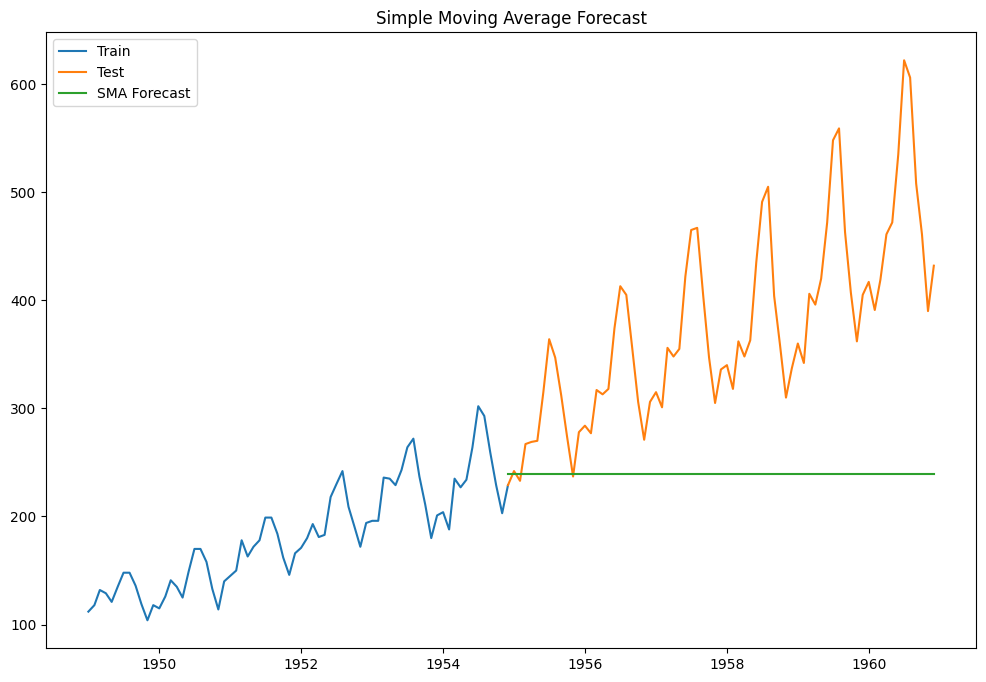

RMSE --->  162.06117454851


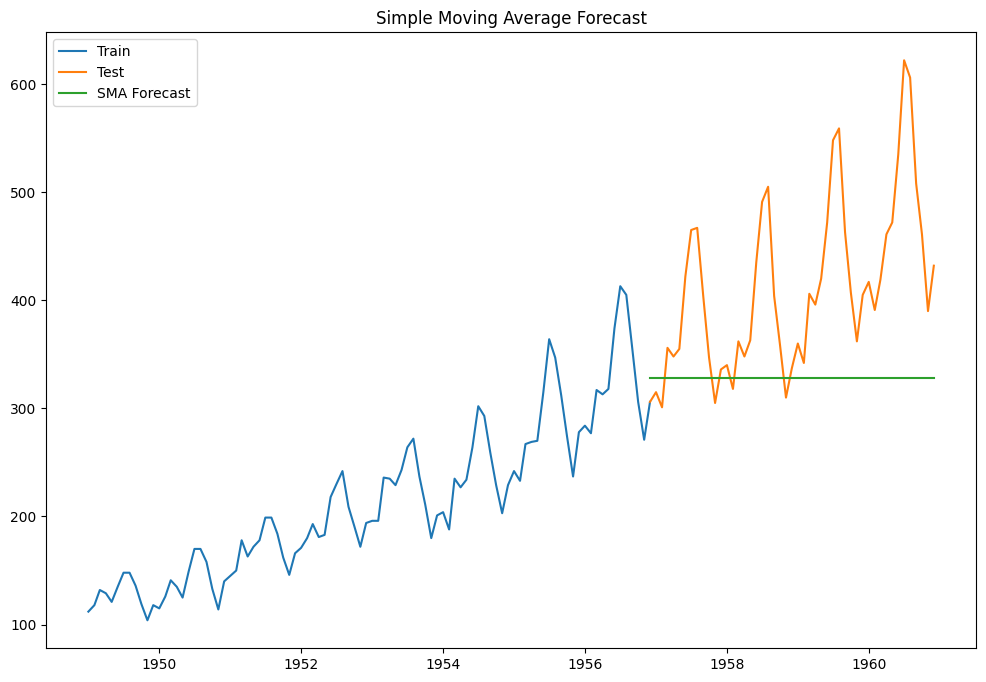

RMSE --->  114.17687339547946


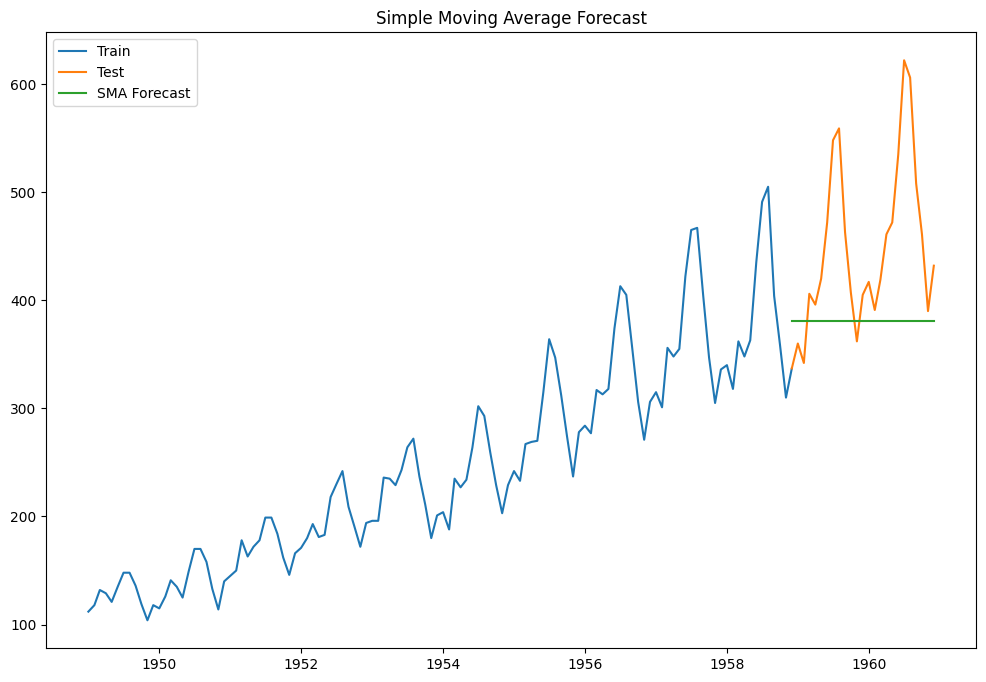

RMSE --->  101.51137867254094
Mean RMSE --> 150.5728789022624


In [ ]:
Eval_list = []
train_data,test_data  = Split(Data,Cross_validator = True)
for train,test in zip(train_data,test_data):
    train_d = Data.iloc[train]
    test_d = Data.iloc[test]
    y_hat = test_d.copy()

    y_hat['SMA'] = train_d['Passengers'].rolling(window=12).mean().iloc[-1]
    plt.figure(figsize=(12,8))
    plt.plot(train_d.index, train_d['Passengers'], label='Train')
    plt.plot(test_d.index,test_d['Passengers'], label='Test')
    plt.plot(y_hat.index,y_hat['SMA'], label='SMA Forecast')
    plt.legend(loc='best')
    plt.title("Simple Moving Average Forecast")
    plt.show()
    Eval_list.append(np.sqrt(mean_squared_error(test_d['Passengers'],y_hat['SMA'])))
    Evalution(test_d['Passengers'],y_hat['SMA'])
print(f'Mean RMSE --> {np.mean(Eval_list)}')

# Wieghted Moving Average

## Fixed

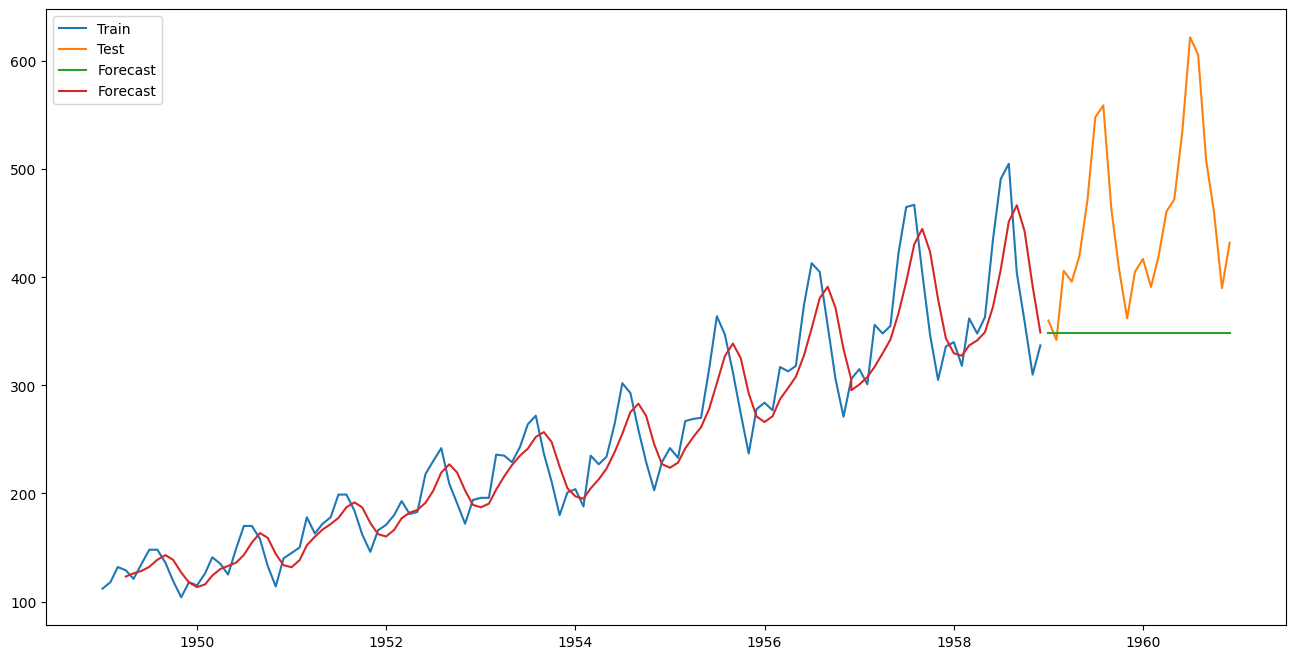

In [ ]:
train_data, val_data, test_data = Split(Data, Fixed_Partition=True)
data_train = train_data.append(val_data)
y_hat_avg = test_data.copy()
weights = [0.2,0.3,0.3,0.2]
y_hat_avg['moving_avg_forecast'] = data_train['Passengers'].rolling(len(weights)).apply(lambda x: np.dot(x, weights[::-1])).values[-1]
# forcast = data_train['Passengers'].rolling(len(weights)).apply(lambda x: np.dot(x, weights[::-1]))
plt.figure(figsize=(16,8))
plt.plot(data_train['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Forecast')
# plt.plot(forcast, label='Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
Evalution(test_data['Passengers'],y_hat_avg['moving_avg_forecast'])

RMSE --->  127.5065096377436


## ROLL

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)

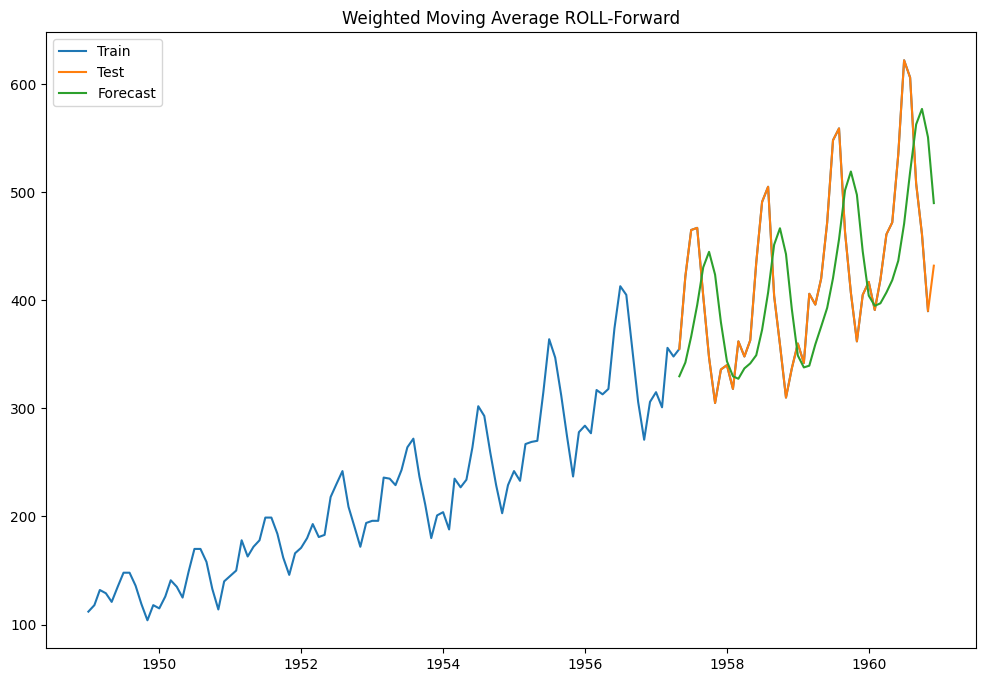

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)
Naive = []
test_index = []
test_val = []
weights = [0.2,0.3,0.3,0.2]
for train,test in zip(train_data,test_data):
    y_hat = test.copy()
    Naive.append(train['Passengers'].rolling(len(weights)).apply(lambda x: np.dot(x, weights[::-1])).values[-1])
    test_val.append(test['Passengers'])
    test_index.append(test.index)
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Passengers'], label='Train')
plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,Naive, label='Forecast')
plt.legend(loc='best')
plt.title("Weighted Moving Average ROLL-Forward")
plt.show()

In [ ]:
Evalution(test_val,Naive)

RMSE --->  80.14005921453447


## CRoss

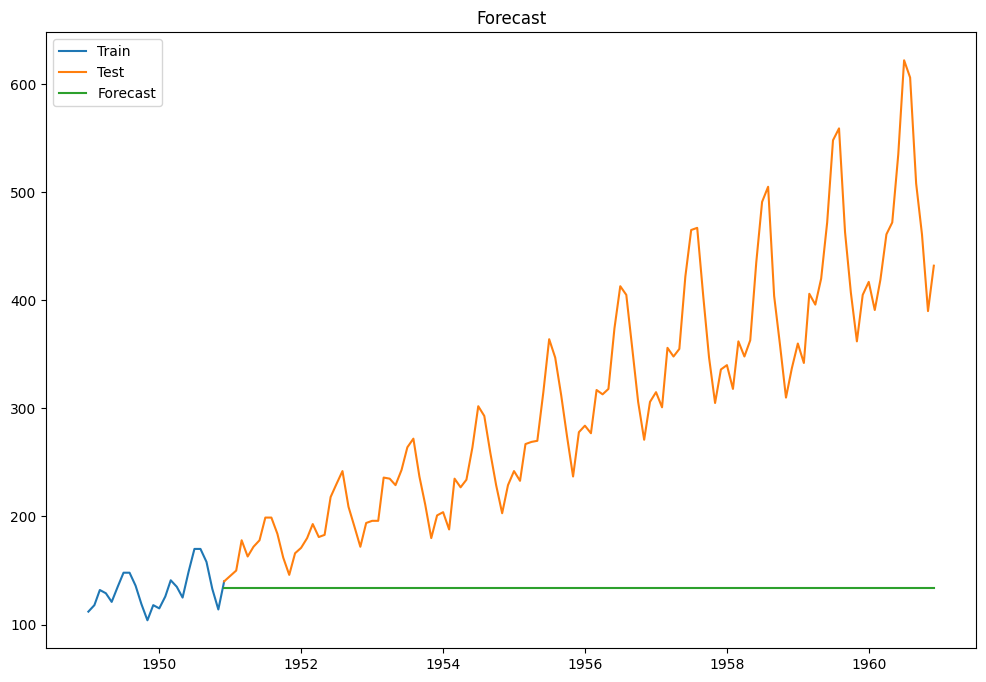

RMSE --->  206.21976743110454


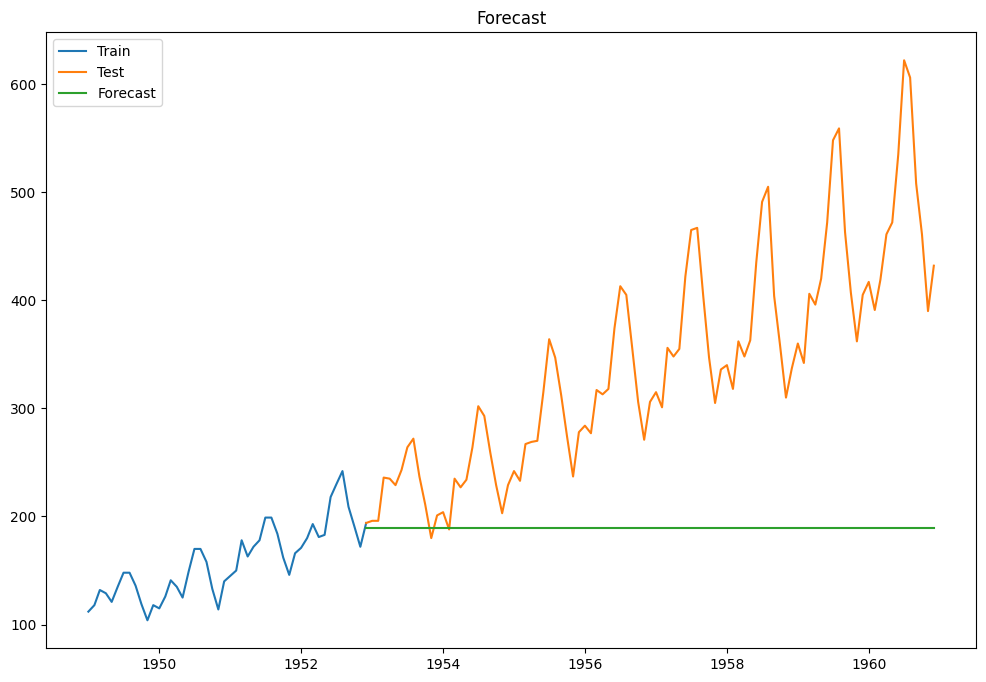

RMSE --->  180.12899873581435


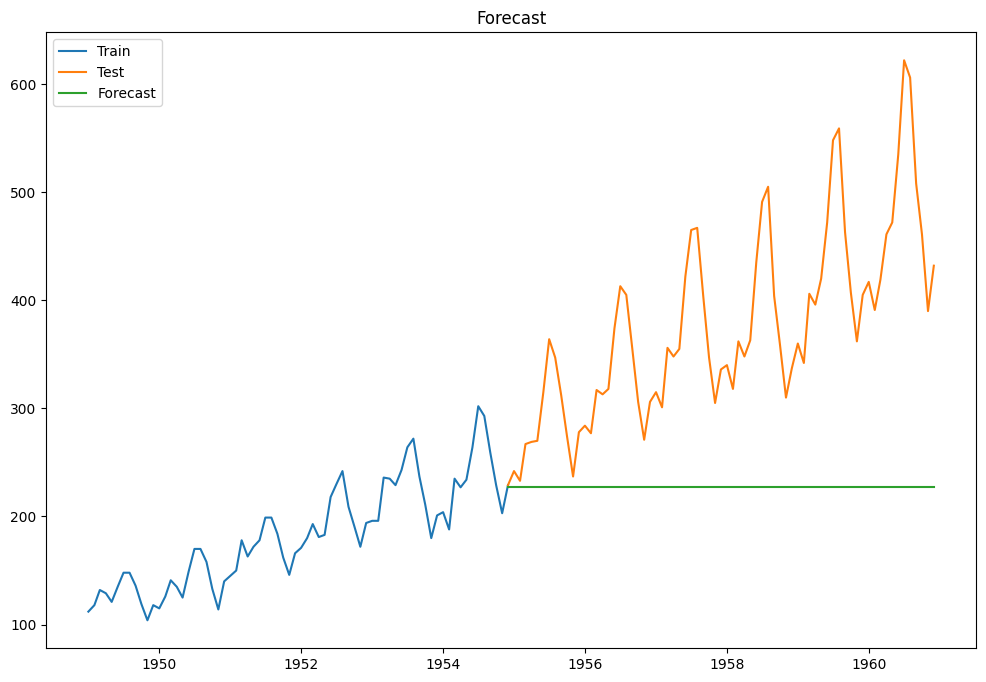

RMSE --->  172.06219487182415


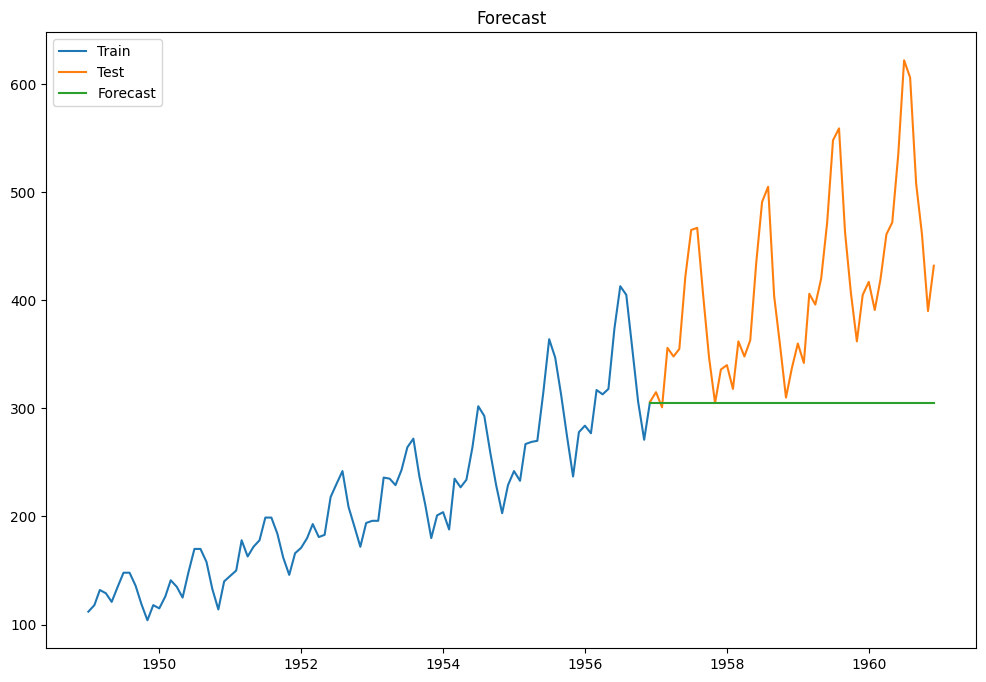

RMSE --->  131.8119880894057


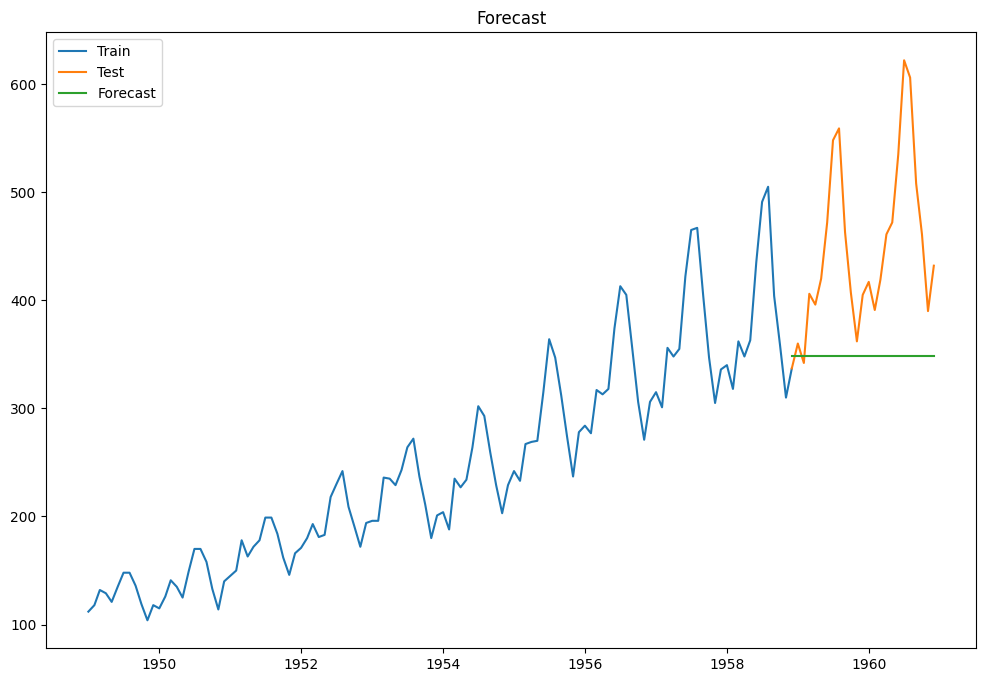

RMSE --->  124.9530231727108
Mean RMSE --> 163.0351944601719


In [ ]:
train_data,test_data  = Split(Data,Cross_validator = True)
Eval_list = []
weights = [0.2,0.3,0.3,0.2,]
for train,test in zip(train_data,test_data):
    train_d = Data.iloc[train]
    test_d = Data.iloc[test]
    y_hat = test_d.copy()
#     print(y_hat)
#     print( train_d['#Passengers'][len(train)-1])
    y_hat['WMA'] = train_d['Passengers'].rolling(len(weights)).apply(lambda x: np.dot(x, weights[::-1])).values[-1]
    plt.figure(figsize=(12,8))
    plt.plot(train_d.index, train_d['Passengers'], label='Train')
    plt.plot(test_d.index,test_d['Passengers'], label='Test')
    plt.plot(y_hat.index,y_hat['WMA'], label='Forecast')
    plt.legend(loc='best')
    plt.title("Forecast")
    plt.show()
    Eval_list.append(np.sqrt(mean_squared_error(test_d['Passengers'],y_hat['WMA'])))
    Evalution(test_d['Passengers'],y_hat['WMA'])
print(f'Mean RMSE --> {np.mean(Eval_list)}')

In [ ]:
import random

weights = []
for i in range(12):
    weights.append(round(random.uniform(0.1, 0.5), 2))
len(weights)

12

# **Simple Linear Regression Model**


## fixed

In [ ]:
index = np.arange(0,9)
index

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

<Axes: xlabel='quarter'>

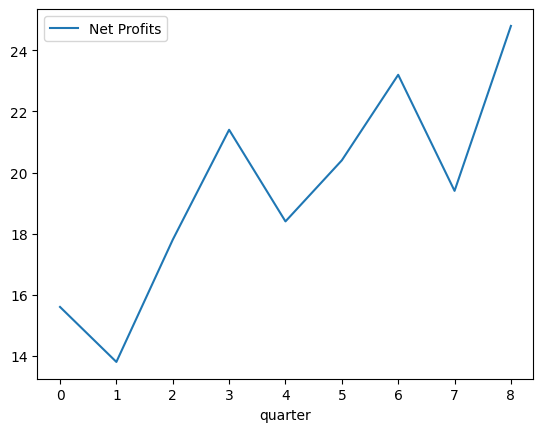

In [ ]:
data = {'quarter': index,
        'Net Profits': [15.6, 13.8, 17.8, 21.4, 18.4, 20.4, 23.2, 19.4, 24.8]}

df = pd.DataFrame(data)
df = df.set_index('quarter')
df.plot()

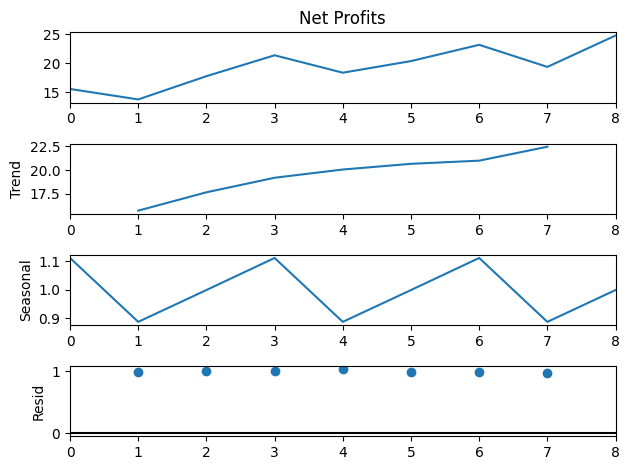

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results_decompose = seasonal_decompose(df['Net Profits'],model = 'multiplicative',period = 3)
results_decompose.plot()
plt.show()

In [ ]:
Seasonal=results_decompose.seasonal
Seasonal

quarter
0    1.112324
1    0.887971
2    0.999705
3    1.112324
4    0.887971
5    0.999705
6    1.112324
7    0.887971
8    0.999705
Name: seasonal, dtype: float64

In [ ]:
deseasonalized = df['Net Profits']/Seasonal
deseasonalized

quarter
0    14.024691
1    15.541046
2    17.805255
3    19.238999
4    20.721394
5    20.406022
6    20.857233
7    21.847557
8    24.807321
dtype: float64

In [ ]:
df['intercept'] = 1
df['t'] = np.arange(0,len(df))
df

Net Profits  intercept  t
quarter                           
0               15.6          1  0
1               13.8          1  1
2               17.8          1  2
3               21.4          1  3
4               18.4          1  4
5               20.4          1  5
6               23.2          1  6
7               19.4          1  7
8               24.8          1  8

In [ ]:
import statsmodels.api as sm
lm =sm.OLS(deseasonalized,df[['t','intercept']])
results = lm.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     88.58
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           3.19e-05
Time:                        08:12:26   Log-Likelihood:                -11.186
No. Observations:                   9   AIC:                             26.37
Df Residuals:                       7   BIC:                             26.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t              1.1554      0.123      9.412      0.0

In [ ]:
import statsmodels.api as sm
train_data, val_data, test_data = Split(Data, Fixed_Partition=True)
data_train = train_data.append(val_data)
data_train['intercept'] = 1
data_train['t'] = np.arange(0,len(data_train))
lm =sm.OLS(data_train['Passengers'],data_train[['t','intercept']])
results = lm.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Passengers   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     599.6
Date:                Thu, 06 Apr 2023   Prob (F-statistic):           4.44e-48
Time:                        12:29:53   Log-Likelihood:                -607.85
No. Observations:                 120   AIC:                             1220.
Df Residuals:                     118   BIC:                             1225.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t              2.4949      0.102     24.487      0.0

In [ ]:
y_hat = test_data.copy()
y_hat['t'] = np.arange(len(data_train),len(data_train) + len(y_hat))
y_hat['intercept']  = 1

In [ ]:
y_hat['forecast'] = results.predict(exog=y_hat[['t', 'intercept']])


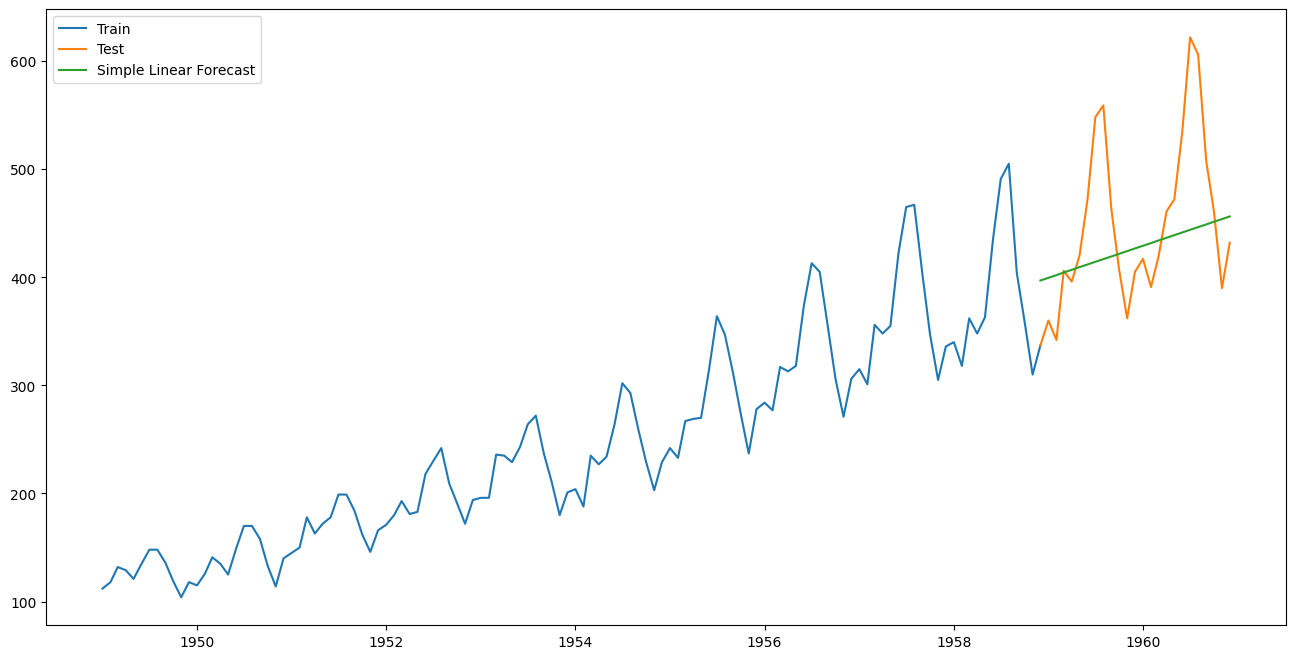

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(data_train['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(y_hat['forecast'], label='Simple Linear Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
Evalution(test_data['Passengers'],y_hat['forecast'])

RMSE --->  73.50209454067235


- In Fixed Paration the linear regression model predict the trend in the data in a good way but it perfom poorly on forcast data as it forcast without seasonality on trend

## ROLL

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)
test_data

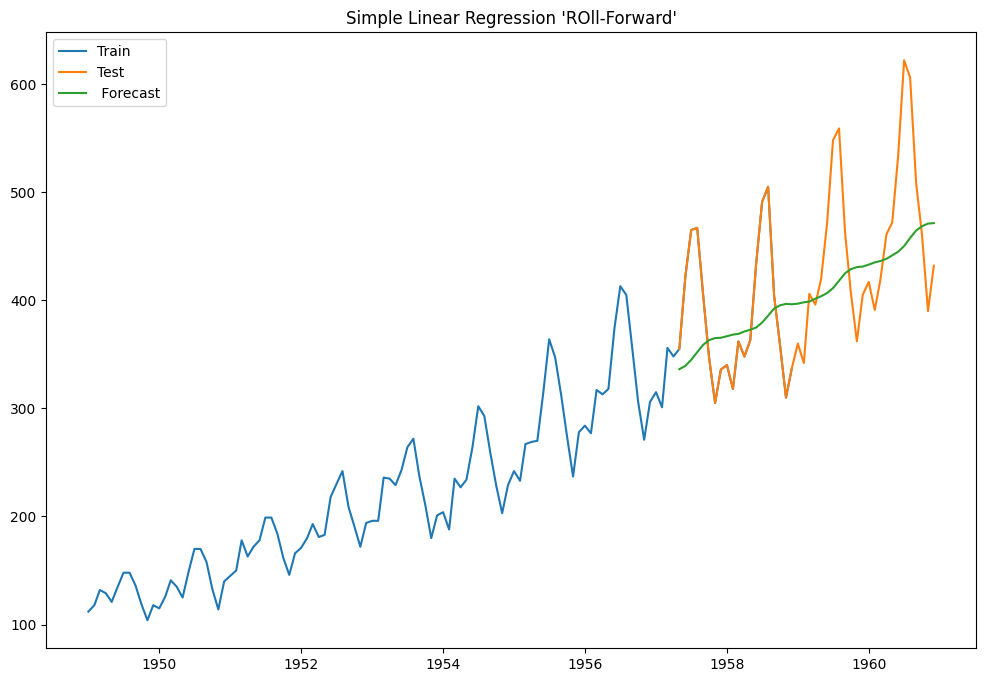

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)
Naive = []
test_index = []
test_val = []

for train,test in zip(train_data,test_data):
    y_hat = test.copy()
    train['intercept'] = 1
    train['t'] = np.arange(0,len(train))
    lm =sm.OLS(train['Passengers'],train[['t','intercept']])
    results = lm.fit()
    y_hat['t'] = np.arange(len(train),len(train) + len(y_hat))
    y_hat['intercept'] = 1
    Naive.append(results.predict(exog=y_hat[['t', 'intercept']]))
    test_val.append(test['Passengers'])
    test_index.append(test.index)
plt.figure(figsize=(12,8))
plt.plot(data_train.index, data_train['Passengers'], label='Train')
plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,Naive, label=' Forecast')
plt.legend(loc='best')
plt.title("Simple Linear Regression 'ROll-Forward'")
plt.show()

In [ ]:
Evalution(test_val,Naive)

RMSE --->  70.21600603918168


ROll Forward is way good than fixed partion as it feed with periodcally data so the linear equation adjusted with every new entry to the model thus leeds to good forcast and low mean square error in comaprsion with fixed partion techniqe

In [ ]:
ROll Forward 

## CROSS

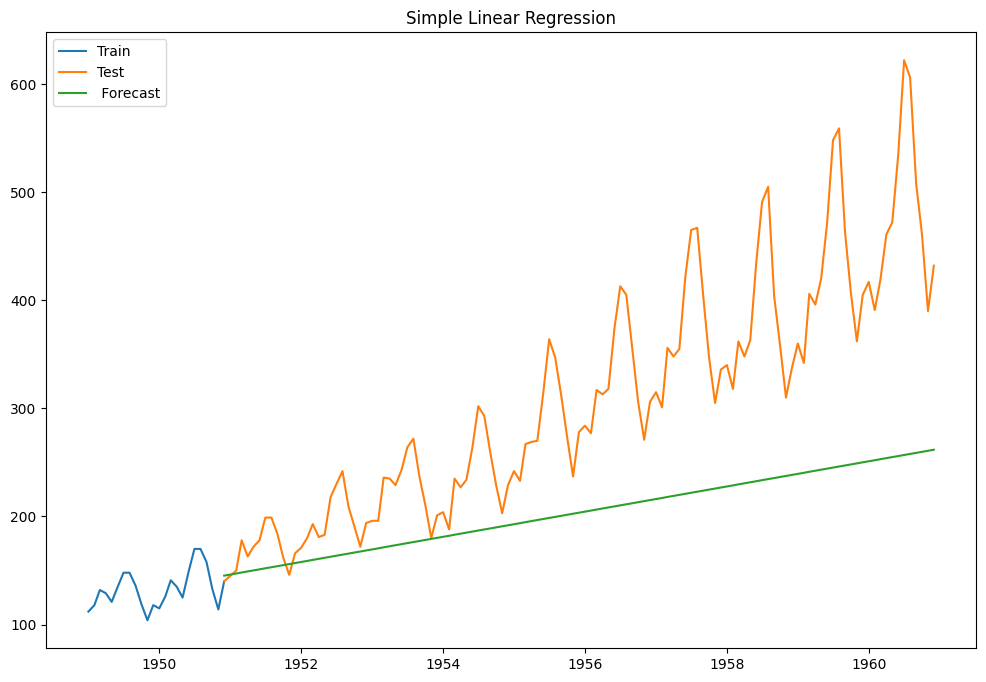

RMSE --->  132.2608744992813


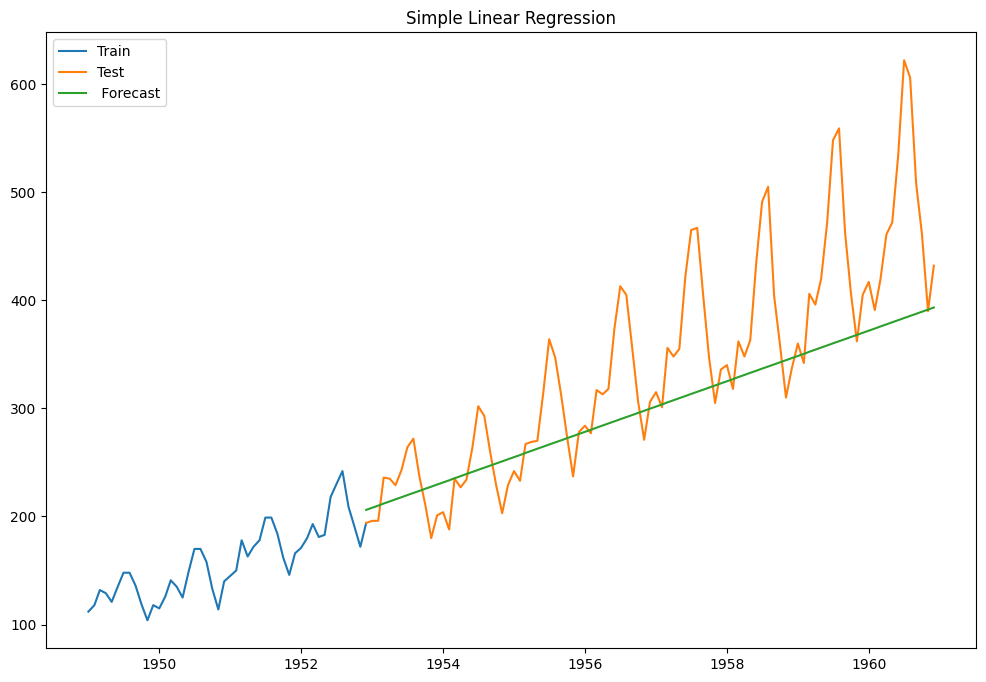

RMSE --->  72.47763029934512


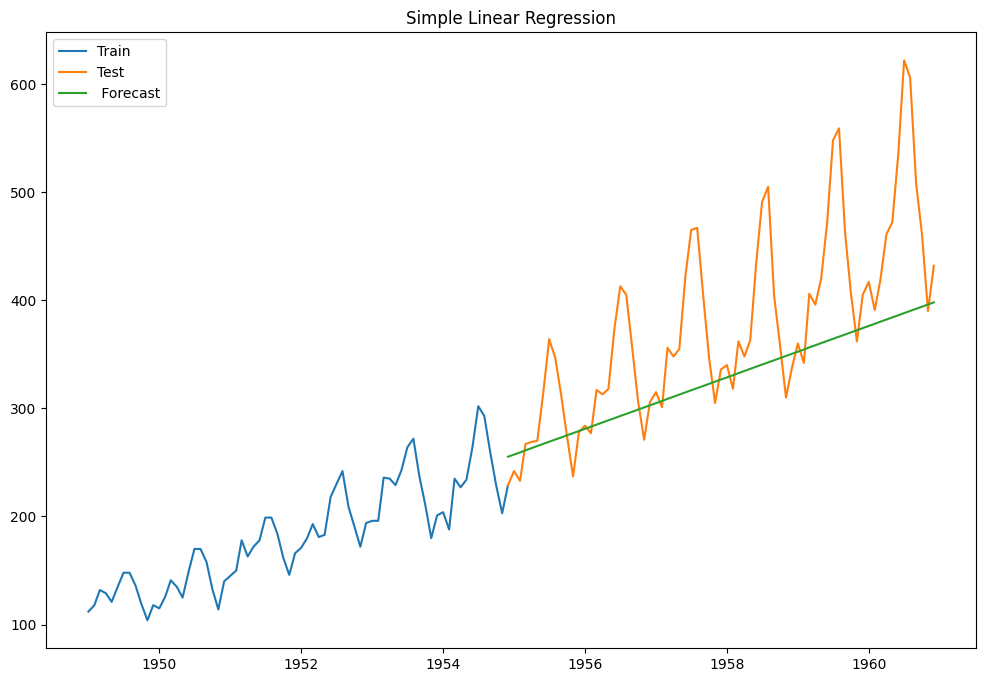

RMSE --->  79.25696477498519


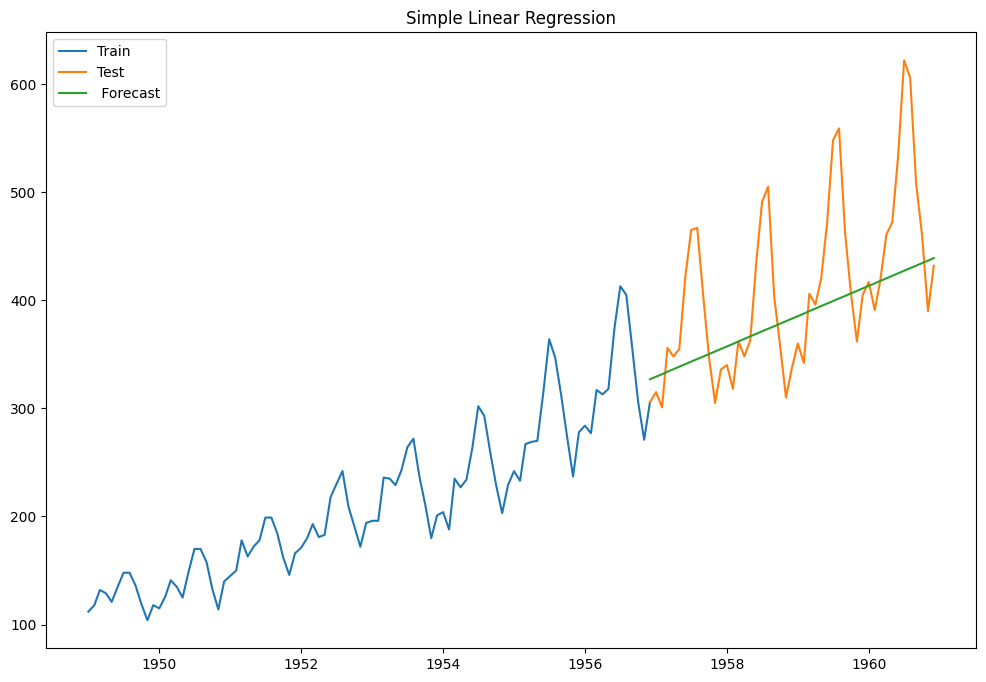

RMSE --->  71.03053983262116


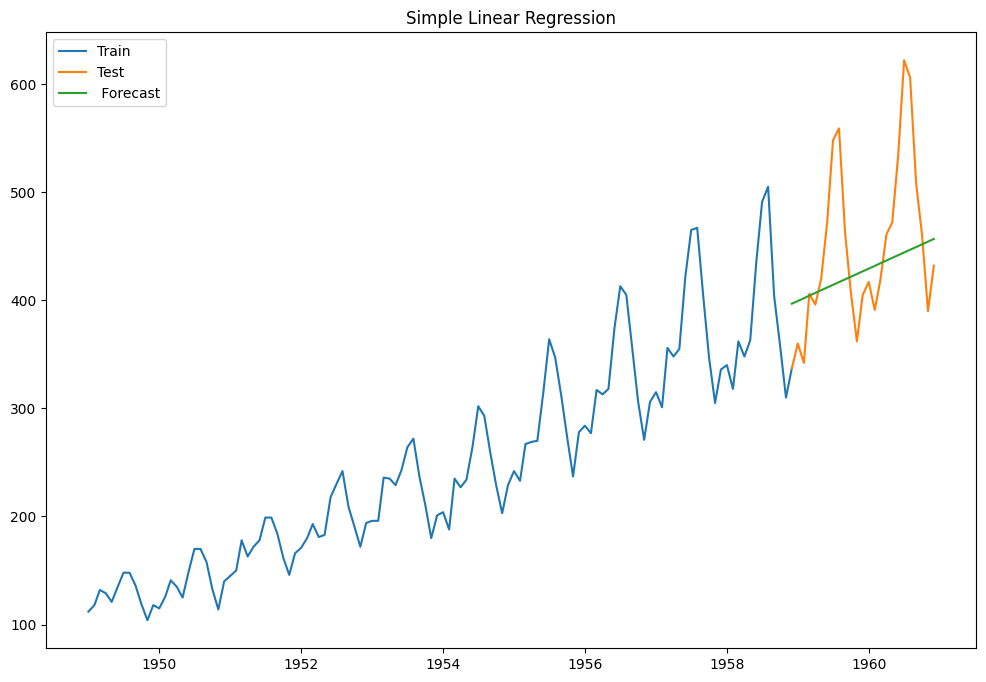

RMSE --->  73.42208422687158
Mean RMSE --> 85.68961872662086


In [ ]:
train_data,test_data  = Split(Data,Cross_validator = True)
Eval_list = []

for train,test in zip(train_data,test_data):
    train_d = Data.iloc[train]
    test_d = Data.iloc[test]
    y_hat = test_d.copy()
#     print(y_hat)
#     print( train_d['Passengers'][len(train)-1])
    train_d['t'] = np.arange(0,len(train_d))
    train_d['intercept'] = 1
    lm =sm.OLS(train_d['Passengers'],train_d[['t','intercept']])
    results = lm.fit()
    y_hat['t'] = np.arange(len(train),len(train) + len(y_hat))
    y_hat['intercept'] = 1
    y_hat['forecasr'] = results.predict(exog=y_hat[['t', 'intercept']])
    plt.figure(figsize=(12,8))
    plt.plot(train_d.index, train_d['Passengers'], label='Train')
    plt.plot(test_d.index,test_d['Passengers'], label='Test')
    plt.plot(y_hat.index,y_hat['forecasr'], label=' Forecast')
    plt.legend(loc='best')
    plt.title("Simple Linear Regression")
    plt.show()
    Eval_list.append(np.sqrt(mean_squared_error(test_d['Passengers'],y_hat['forecasr'])))
    Evalution(test_d['Passengers'],y_hat['forecasr'])
print(f'Mean RMSE --> {np.mean(Eval_list)}')

- in Cross Validaotr technique the model perfome badly with low amount of data as the linear regression model needs more data to perfome well 

overall linear regression model need more data to fit well also it good and peridcition for data if it not have seasonality and it has linear trend

# Classical Decomposition


## Fixed Partioninig

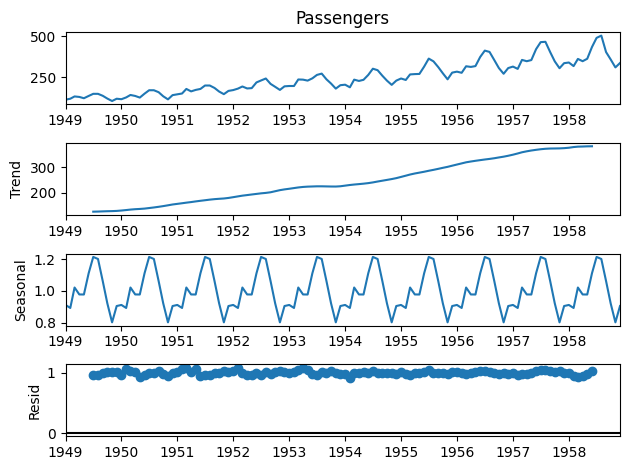

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results_decompose = seasonal_decompose(data_train['Passengers'],model = 'multiplicative',period = 12)
results_decompose.plot()
plt.show()

In [ ]:
train_data, val_data, test_data = Split(Data, Fixed_Partition=True)
data_train = train_data.append(val_data)
data_train['intercept'] = 1
data_train['t'] = np.arange(0,len(data_train))
lm =sm.OLS(data_train['Passengers'],data_train[['t','intercept']])
results_model = lm.fit()
results_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     607.7
Date:                Wed, 05 Apr 2023   Prob (F-statistic):           1.40e-48
Time:                        19:34:31   Log-Likelihood:                -612.36
No. Observations:                 121   AIC:                             1229.
Df Residuals:                     119   BIC:                             1234.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t              2.4692      0.100     24.651      0.000       2.271       2.667
intercept     98.2555      6.954     14.129      0.000      84.486     112.025
==============================================================================
Omnibus:                       17.976   Durbin-Watson:                   0.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.003
Skew:                           0.853   Prob(JB):                     1.67e-05
Kurtosis:                       4.205   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

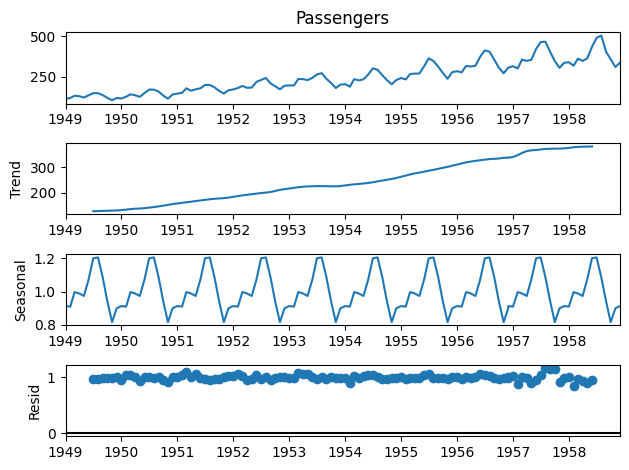

- we will use the simple linear model to forcast data as we will determine the trend component from the OLS model then we will multiply it with the seasonal specific for each month


In [ ]:
Seasonal  = results_decompose.seasonal


In [ ]:
y_hat = test_data.copy()
y_hat['t'] = np.arange(len(data_train),len(data_train) + len(y_hat))
y_hat['intercept']  = 1

In [ ]:
y_hat['forecast_trend'] = results_model.predict(exog=y_hat[['t', 'intercept']])

In [ ]:
forecast = []
for i in range(len(y_hat['forecast_trend'])):
  
  forecast.append(y_hat['forecast_trend'].iloc[i]*Seasonal[y_hat.index.month[i]])

In [ ]:
y_hat['forecast'] = forecast


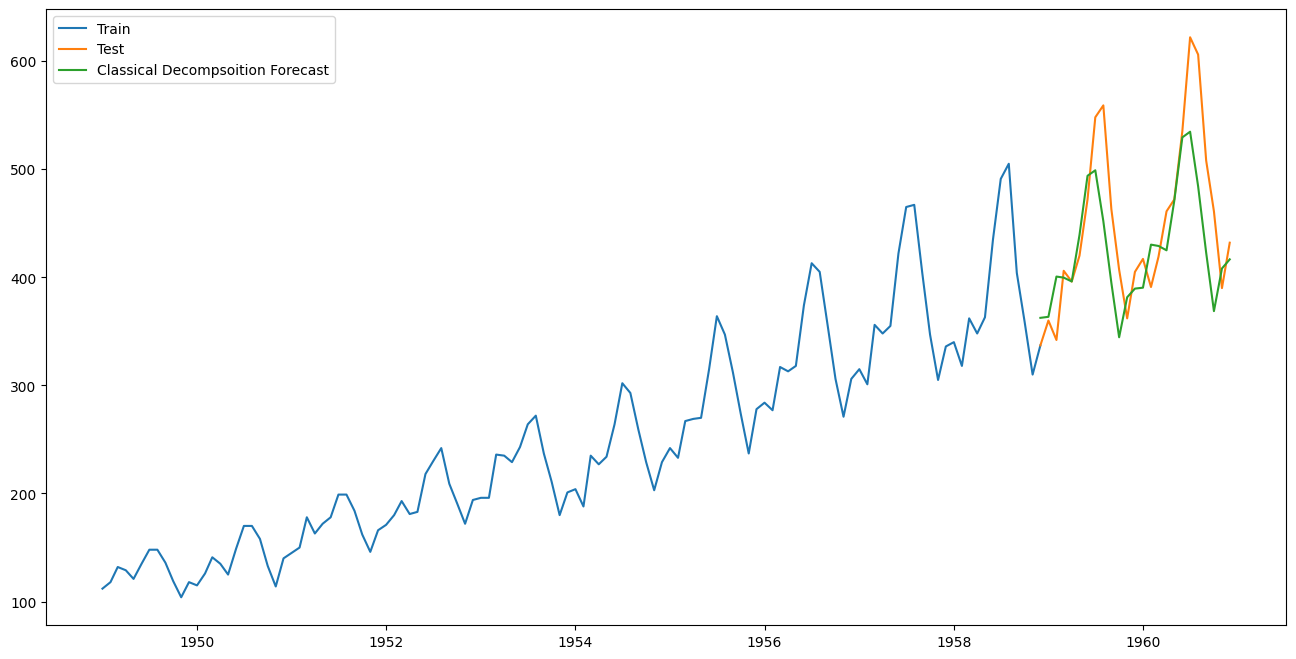

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(data_train['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(y_hat['forecast'], label='Classical Decompsoition Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
Evalution(test_data['Passengers'],y_hat['forecast'])

RMSE --->  53.12186464561343


- In Fixed paration by using the multiply the predicted trend to seasonality that decopomsed from Classical decompostion it generates a good forcast

## ROLL

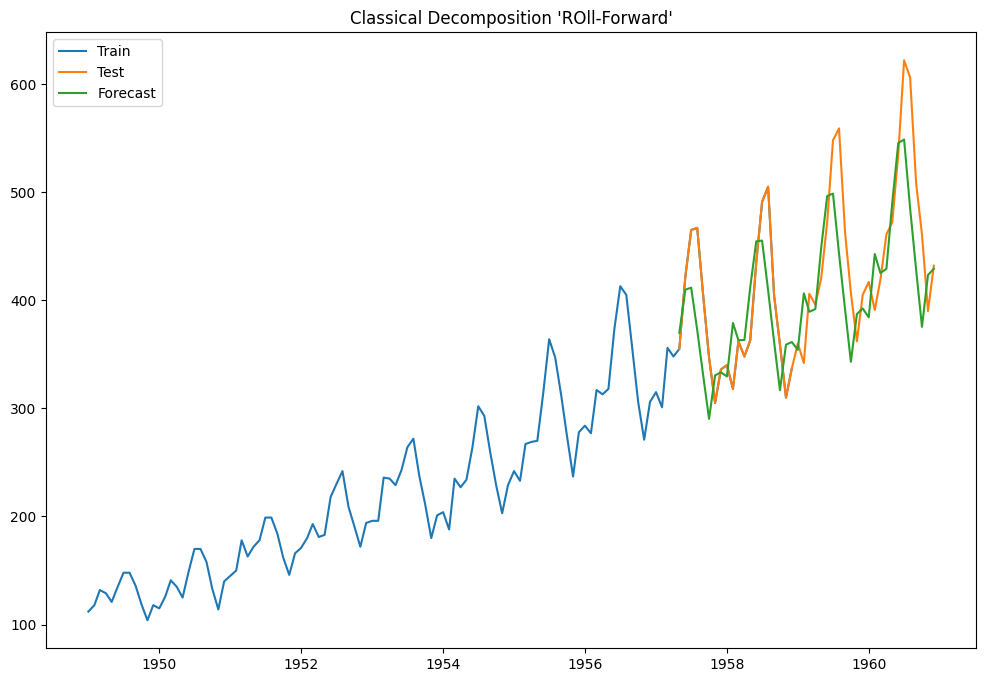

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)
trend = []
test_index = []
test_val = []
forecast = []



for train,test in zip(train_data,test_data):
    results_decompose = seasonal_decompose(train['Passengers'],model = 'multiplicative',period = 12)
    Seasonal  = results_decompose.seasonal
    y_hat = test.copy()
    train['intercept'] = 1
    train['t'] = np.arange(0,len(train))
    lm =sm.OLS(train['Passengers'],train[['t','intercept']])
    results_model = lm.fit()
    y_hat['t'] = np.arange(len(train),len(train) + len(y_hat))
    y_hat['intercept']  = 1
    y_hat['forecast_trend'] = results_model.predict(exog=y_hat[['t', 'intercept']])
    # print(y_hat)
    for i in range(len(y_hat['forecast_trend'])):
      forecast.append(y_hat['forecast_trend'].iloc[i]*Seasonal[y_hat.index.month[i]])
    
    test_val.append(test['Passengers'])
    test_index.append(test.index)



## PLot    
plt.figure(figsize=(12,8))
plt.plot(data_train.index, data_train['Passengers'], label='Train')
plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,forecast, label='Forecast')
plt.legend(loc='best')
plt.title("Classical Decomposition 'ROll-Forward'")
plt.show()

In [ ]:
Evalution(test_val,forecast)

RMSE --->  51.615320176862355


## Cross

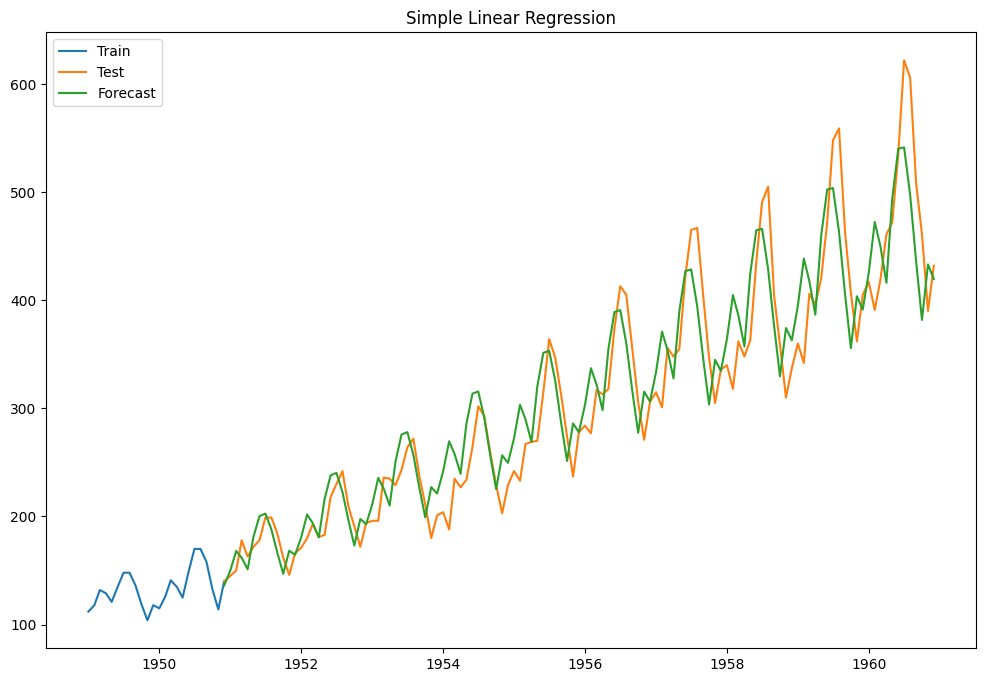

RMSE --->  38.443160641121885


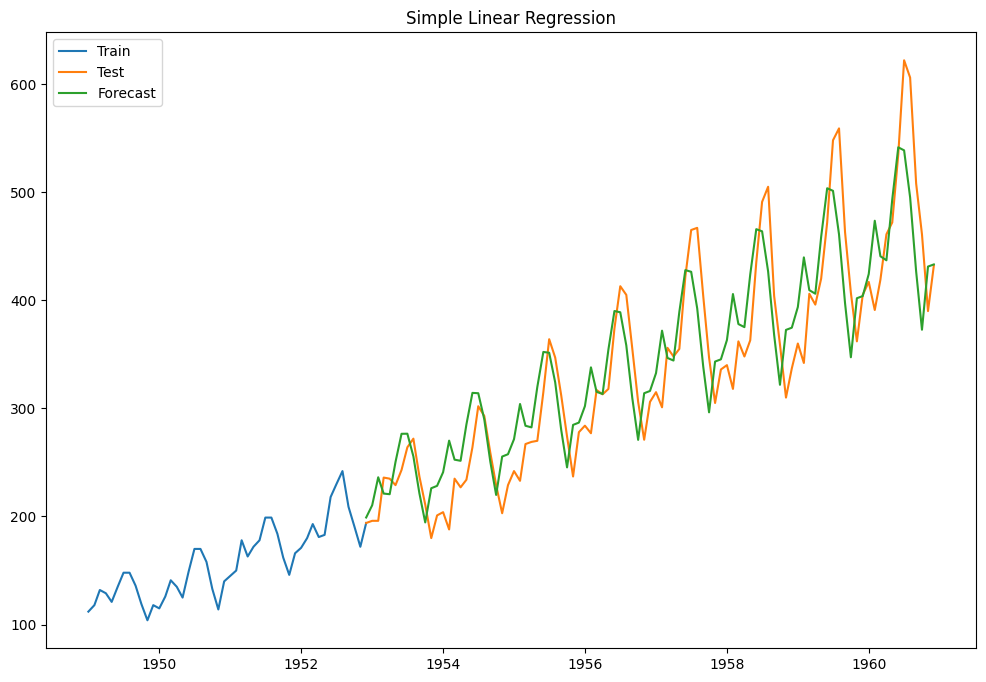

RMSE --->  43.51856710921361


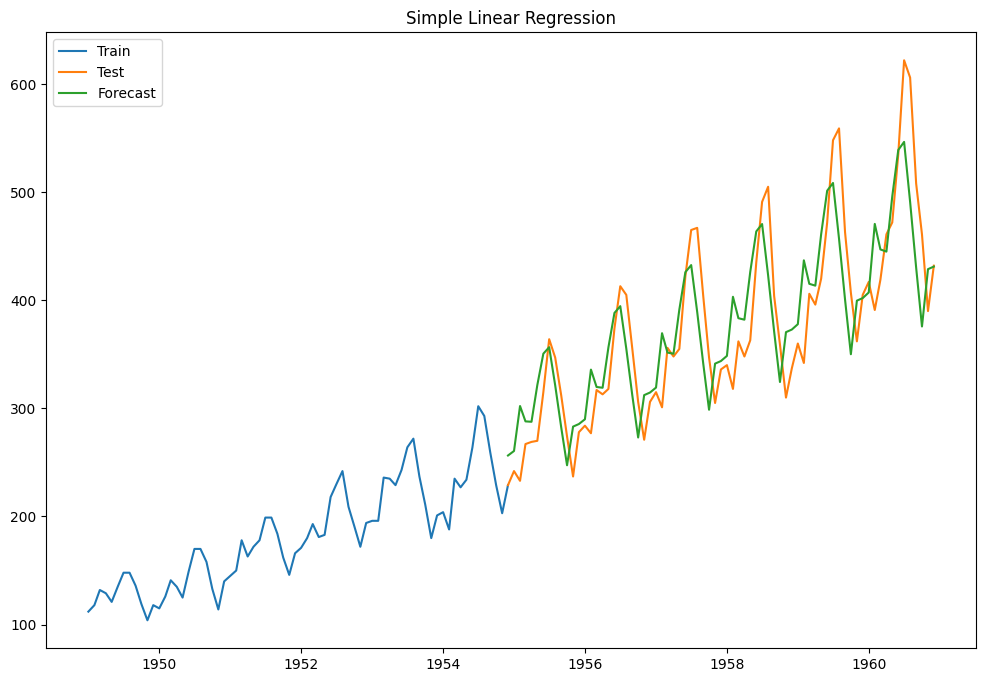

RMSE --->  45.54813871908357


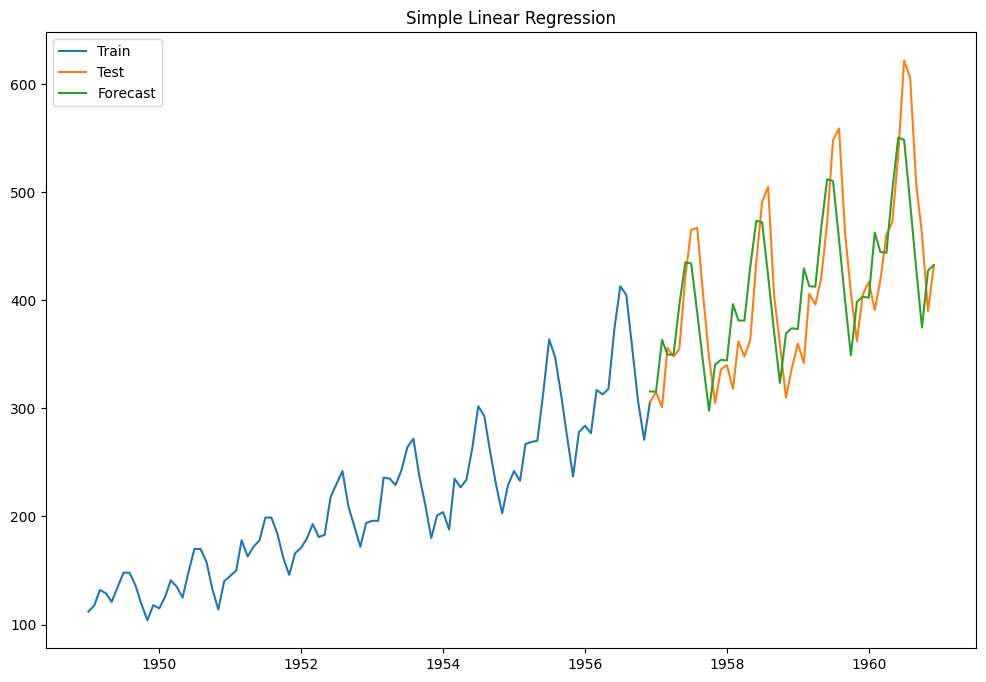

RMSE --->  49.986543958868545


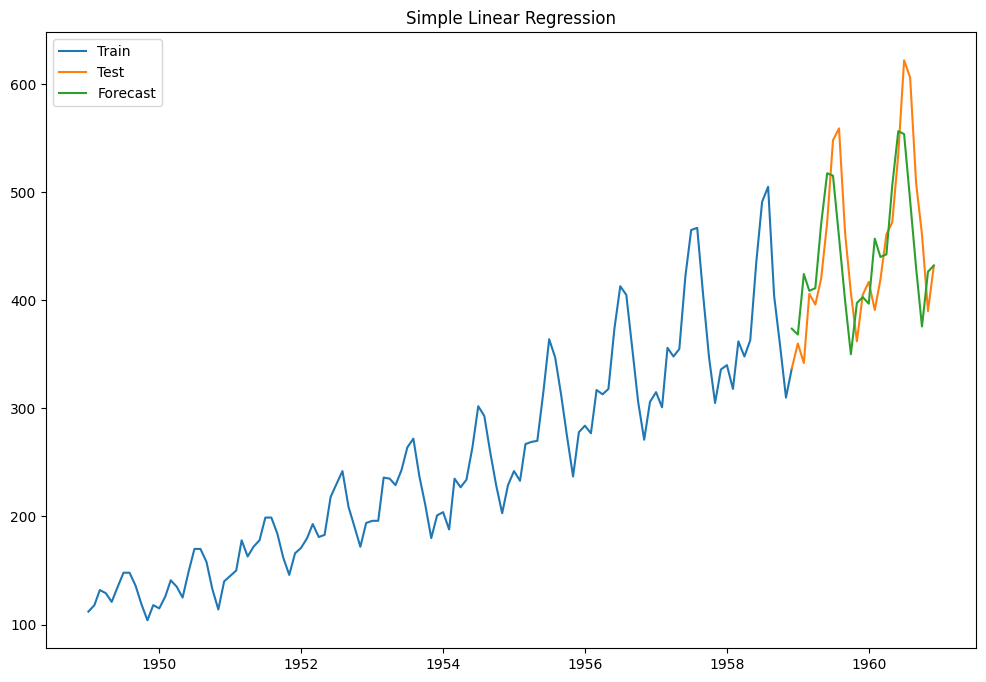

RMSE --->  53.761613841955956
Mean RMSE --> 46.251604854048715


In [ ]:
train_data,test_data  = Split(Data,Cross_validator = True)
Eval_list = []

for train,test in zip(train_data,test_data):
    forecast = []
    train_d = Data.iloc[train]
    test_d = Data.iloc[test]
    results_decompose = seasonal_decompose(train_d['Passengers'],model = 'multiplicative',period = 12)
    Seasonal  = results_decompose.seasonal
    y_hat = test_d.copy()
    train_d['intercept'] = 1
    train_d['t'] = np.arange(0,len(train_d))
    lm =sm.OLS(train_d['Passengers'],train_d[['t','intercept']])
    results = lm.fit()
    y_hat['t'] = np.arange(len(train),len(train) + len(y_hat))
    y_hat['intercept']=1
    y_hat['forecast_trend'] = results_model.predict(exog=y_hat[['t', 'intercept']])
    print(y_hat)
    print(Seasonal)
    for i in range(len(y_hat['forecast_trend'])):
      forecast.append(y_hat['forecast_trend'].iloc[i]*Seasonal[y_hat.index.month[i]])
    y_hat['forecast'] = forecast



    plt.figure(figsize=(12,8))
    plt.plot(train_d.index, train_d['Passengers'], label='Train')
    plt.plot(test_d.index,test_d['Passengers'], label='Test')
    plt.plot(y_hat.index,y_hat['forecast'], label='Forecast')
    plt.legend(loc='best')
    plt.title("Simple Linear Regression")
    plt.show()
    Eval_list.append(np.sqrt(mean_squared_error(test_d['Passengers'],y_hat['forecast'])))
    Evalution(test_d['Passengers'],y_hat['forecast'])
print(f'Mean RMSE --> {np.mean(Eval_list)}')

AS we depend on linear regression model to predict trend in the data then   multiply it to the seasonality component derived from classical decomposition we found that 
 -  in roll forward is the best technique as it generates low RMSE also the trend model adjust when we add perdically dataa to the trend model 
 - by looking in cross validtor we will see it genertate poorly perdications as linear model needs more data to be fitted well

# Seasonal-Trend decomposition using LOESS (STL)

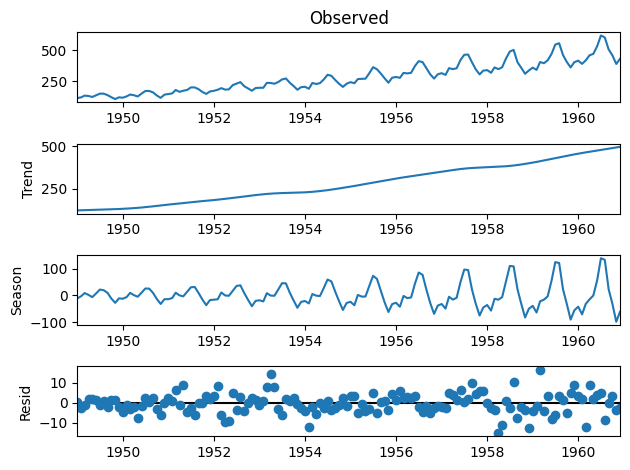

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(Data,period = 12)
res = stl.fit()
fig = res.plot()

In [ ]:
Seasonal = res.seasonal
Seasonal[:24]

Month
1959-01-01    -38.051990
1959-02-01    -63.162092
1959-03-01    -17.796530
1959-04-01    -15.929124
1959-05-01     -5.068203
1959-06-01     56.217534
1959-07-01    121.280357
1959-08-01    116.259707
1959-09-01     23.787835
1959-10-01    -32.141001
1959-11-01    -89.029624
1959-12-01    -53.987456
1960-01-01    -41.237909
1960-02-01    -69.871527
1960-03-01    -21.975116
1960-04-01    -18.108462
1960-05-01     -5.267234
1960-06-01     61.396888
1960-07-01    133.071998
1960-08-01    127.660982
1960-09-01     25.594978
1960-10-01    -34.197439
1960-11-01    -95.814330
1960-12-01    -58.835207
Name: season, dtype: float64

<Axes: xlabel='Month'>

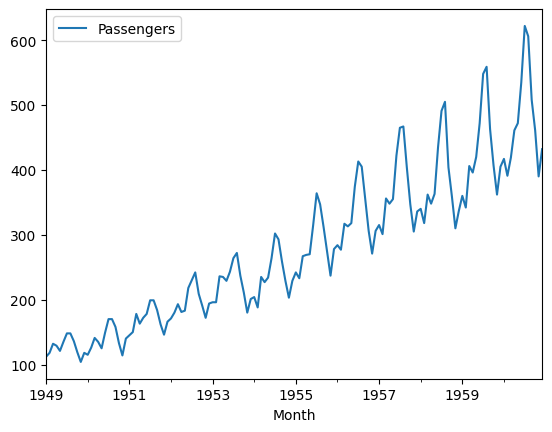

In [ ]:
Data.plot()

## Fixed Partioninig

In [ ]:
import statsmodels.api as sm
train_data, val_data, test_data = Split(Data, Fixed_Partition=True)
data_train = train_data.append(val_data)


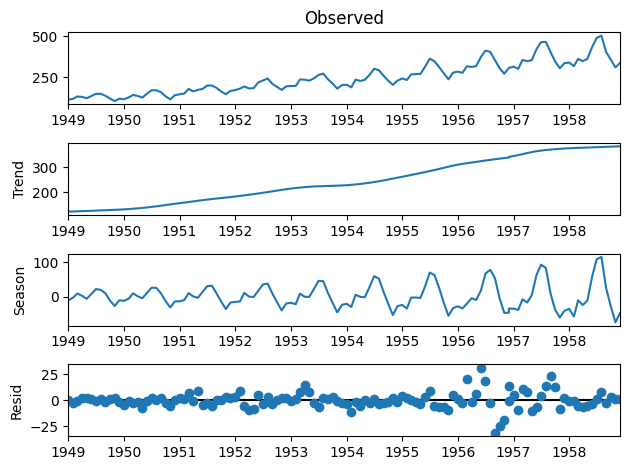

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(data_train, period = 12)
res = stl.fit()
fig = res.plot()

- we will use the simple linear model to forcast data as we will determine the trend component from the OLS model then we will multiply it with the seasonal specific for each month


In [ ]:
Seasonal = res.seasonal

In [ ]:
data_train['intercept'] = 1
data_train['t'] = np.arange(0,len(data_train))
lm =sm.OLS(data_train['Passengers'],data_train[['t','intercept']])
results_model = lm.fit()
print(results_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Passengers   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     607.7
Date:                Wed, 05 Apr 2023   Prob (F-statistic):           1.40e-48
Time:                        20:04:33   Log-Likelihood:                -612.36
No. Observations:                 121   AIC:                             1229.
Df Residuals:                     119   BIC:                             1234.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t              2.4692      0.100     24.651      0.0

In [ ]:
y_hat = test_data.copy()
y_hat['t'] = np.arange(len(data_train),len(data_train) + len(y_hat))
y_hat['intercept']  = 1

In [ ]:
y_hat['forecast_trend'] = results_model.predict(exog=y_hat[['t', 'intercept']])

In [ ]:
y_hat['forecast_trend']

Month
1958-12-01    397.023554
1959-01-01    399.492711
1959-02-01    401.961868
1959-03-01    404.431026
1959-04-01    406.900183
1959-05-01    409.369340
1959-06-01    411.838497
1959-07-01    414.307655
1959-08-01    416.776812
1959-09-01    419.245969
1959-10-01    421.715127
1959-11-01    424.184284
1959-12-01    426.653441
1960-01-01    429.122599
1960-02-01    431.591756
1960-03-01    434.060913
1960-04-01    436.530070
1960-05-01    438.999228
1960-06-01    441.468385
1960-07-01    443.937542
1960-08-01    446.406700
1960-09-01    448.875857
1960-10-01    451.345014
1960-11-01    453.814172
1960-12-01    456.283329
Name: forecast_trend, dtype: float64

In [ ]:
Seasonal[y_hat.index.month[0]]

-11.123600466208408

In [ ]:
y_hat['forecast_trend'].iloc[0]+Seasonal[y_hat.index.month[0]]

383.54634996014056

In [ ]:
forecast = []
for i in range(len(y_hat['forecast_trend'])):
  
  forecast.append(y_hat['forecast_trend'].iloc[i]+Seasonal[y_hat.index.month[i]])

In [ ]:
y_hat['forecast'] = forecast


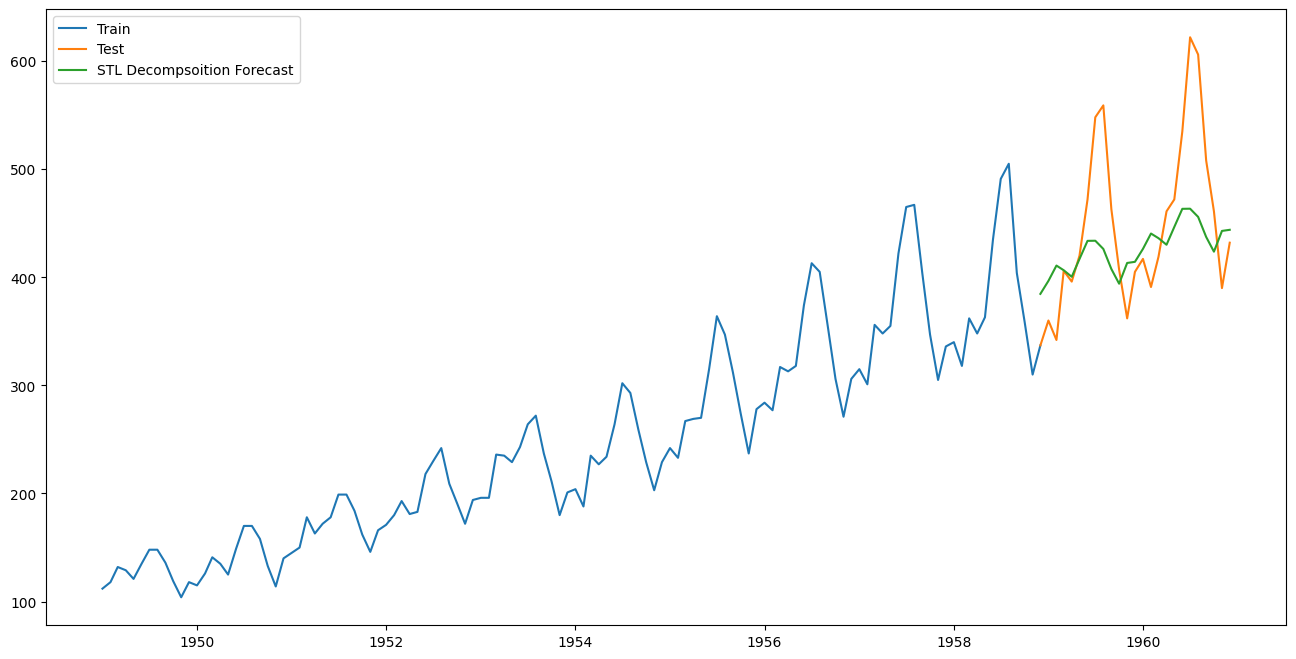

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(data_train['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(y_hat['forecast'], label='STL Decompsoition Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
Evalution(test_data['Passengers'],y_hat['forecast'])

RMSE --->  67.2452220076166


## ROLL

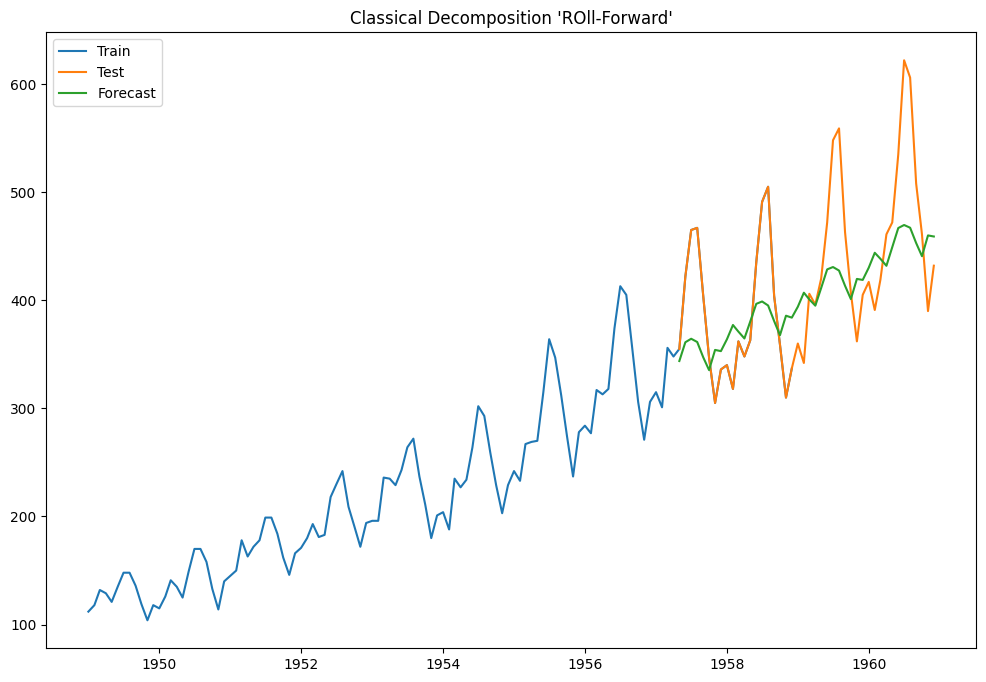

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)
trend = []
test_index = []
test_val = []
forecast = []



for train,test in zip(train_data,test_data):
    stl = STL(train['Passengers'], period = 12)
    res = stl.fit()
    Seasonal  = res.seasonal
    y_hat = test.copy()
    train['intercept'] = 1
    train['t'] = np.arange(0,len(train))
    lm =sm.OLS(train['Passengers'],train[['t','intercept']])
    results_model = lm.fit()
    y_hat['t'] = np.arange(len(train),len(train) + len(y_hat))
    y_hat['intercept']  = 1
    y_hat['forecast_trend'] = results_model.predict(exog=y_hat[['t', 'intercept']])
    # print(y_hat)
    for i in range(len(y_hat['forecast_trend'])):
      forecast.append(y_hat['forecast_trend'].iloc[i]+Seasonal[y_hat.index.month[i]])
    
    test_val.append(test['Passengers'])
    test_index.append(test.index)




## PLot    
plt.figure(figsize=(12,8))
plt.plot(data_train.index, data_train['Passengers'], label='Train')
plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,forecast, label='Forecast')
plt.legend(loc='best')
plt.title("STL Decomposition 'ROll-Forward'")
plt.show()

In [ ]:
Evalution(test_val,forecast)

RMSE --->  62.48723829027598


## Cross

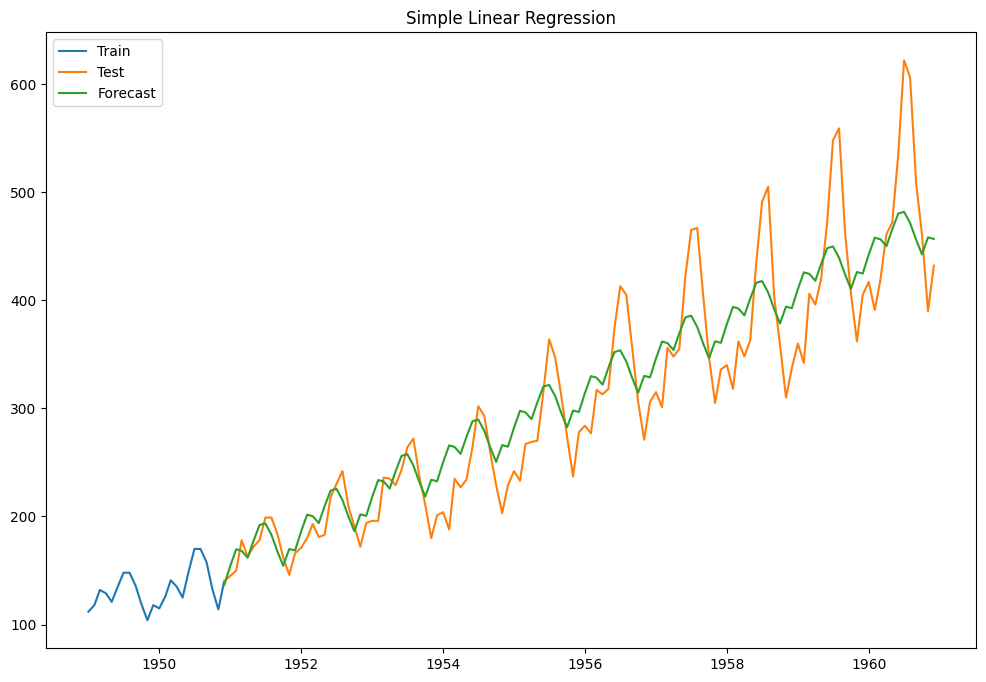

RMSE --->  43.04087988104458


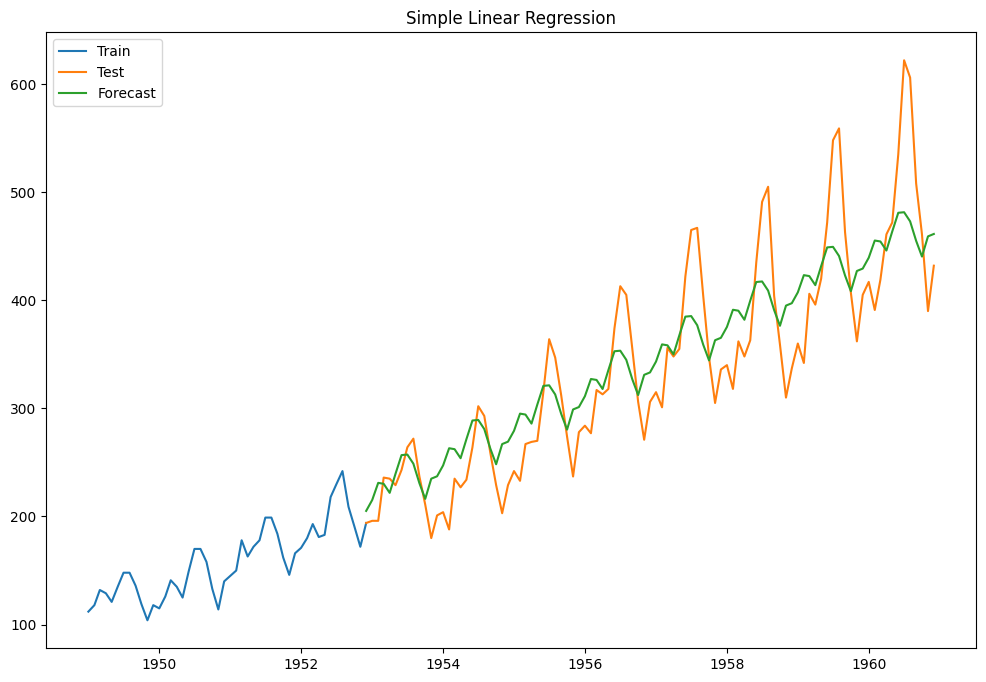

RMSE --->  47.029329368689844


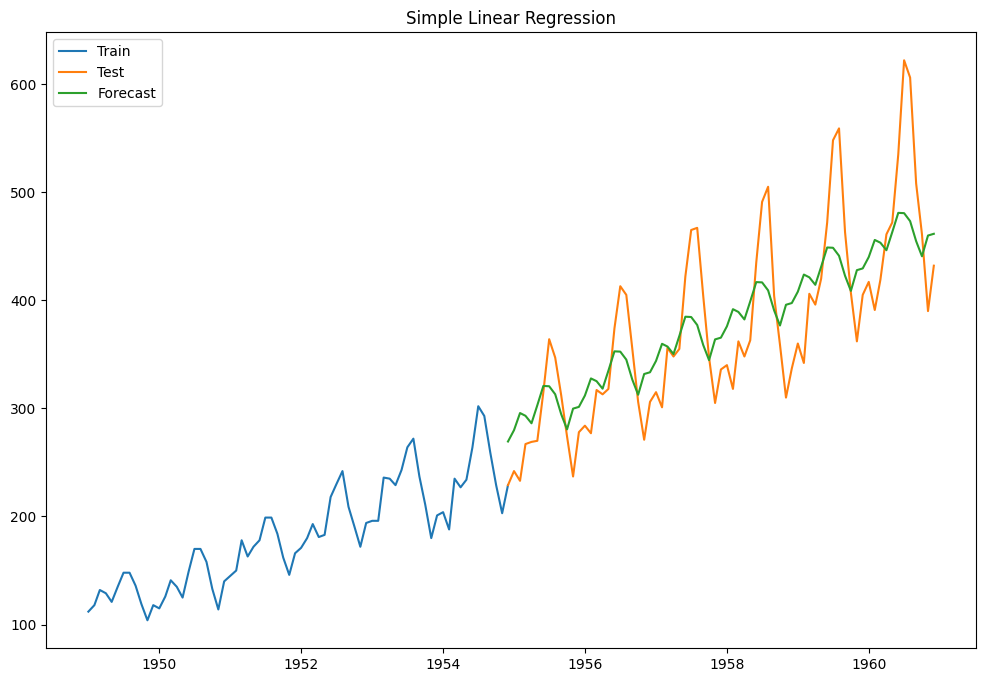

RMSE --->  51.4589216380913


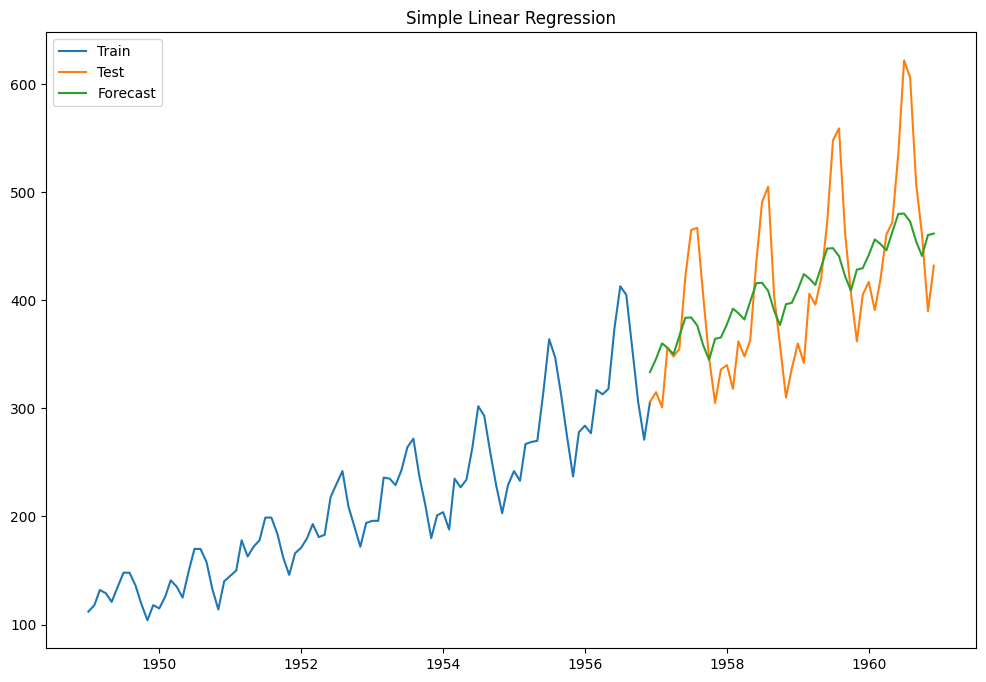

RMSE --->  57.54882610503399


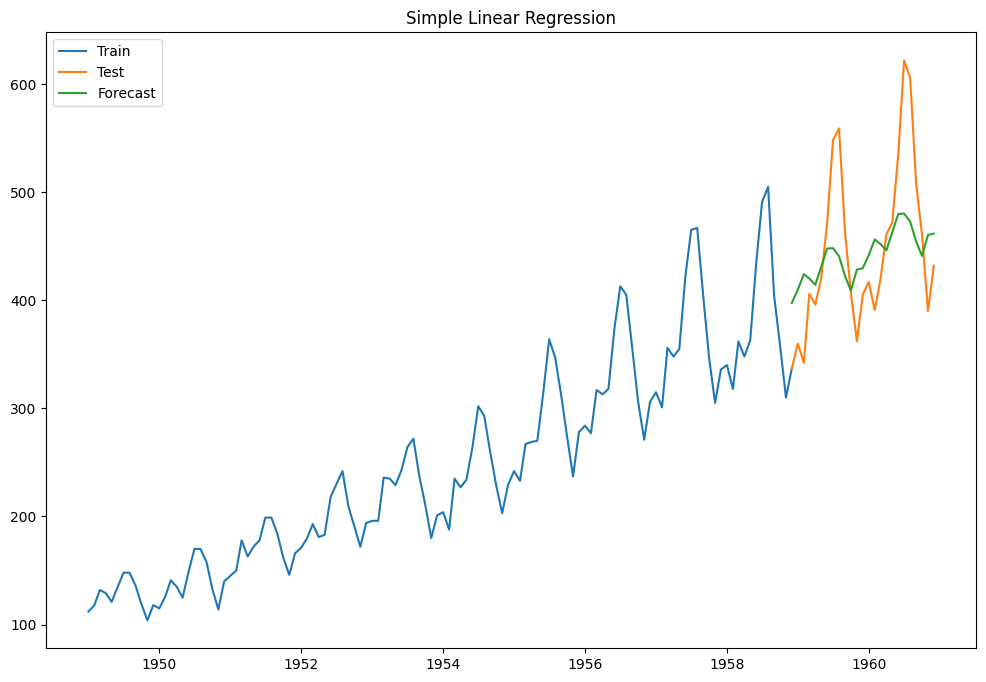

RMSE --->  63.56682829368684
Mean RMSE --> 52.52895705730931


In [ ]:
train_data,test_data  = Split(Data,Cross_validator = True)
Eval_list = []

for train,test in zip(train_data,test_data):
    forecast = []
    train_d = Data.iloc[train]
    test_d = Data.iloc[test]
    y_hat = test_d.copy()
    train_d['intercept'] = 1
    train_d['t'] = np.arange(0,len(train_d))
    lm =sm.OLS(train_d['Passengers'],train_d[['t','intercept']])
    stl = STL(train_d['Passengers'], period = 12)
    res = stl.fit()
    Seasonal  = res.seasonal
    y_hat['t'] = np.arange(len(train),len(train) + len(y_hat))
    y_hat['intercept']=1
    y_hat['forecast_trend'] = results_model.predict(exog=y_hat[['t', 'intercept']])

    for i in range(len(y_hat['forecast_trend'])):
      
      forecast.append(y_hat['forecast_trend'].iloc[i]+Seasonal[y_hat.index.month[i]])
    y_hat['forecast'] = forecast



    plt.figure(figsize=(12,8))
    plt.plot(train_d.index, train_d['Passengers'], label='Train')
    plt.plot(test_d.index,test_d['Passengers'], label='Test')
    plt.plot(y_hat.index,y_hat['forecast'], label='Forecast')
    plt.legend(loc='best')
    plt.title("Simple Linear Regression")
    plt.show()
    Eval_list.append(np.sqrt(mean_squared_error(test_d['Passengers'],y_hat['forecast'])))
    Evalution(test_d['Passengers'],y_hat['forecast'])
print(f'Mean RMSE --> {np.mean(Eval_list)}')

# ARIMA MODEL

## Check **Stationarity** of The Data

- We Have Four Ways to check the stationarity of the data
  -   By Looking at the plot
     
  - Summary Statisitics
  - Histogram plot
  - Statistical Test **ADF**

## Looking at the plot

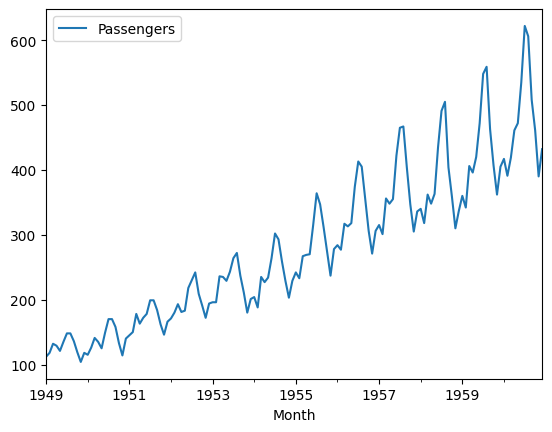

In [ ]:
Data.plot()
plt.show()

- By Looking at the plot we found that the data is **non stationary** as it has **trend **and **seasonality** also its **non stationary** in **vairance** 

## Summary Statisitics
- We will split the data into chunks and calculate mean and variance for every chunck 

In [ ]:
Chunk_1 = Data[:48]
Chunk_2 = Data[48:96]
Chunk_3 = Data[96:]

In [ ]:
print(f'Chunk 1 : Mean = {Chunk_1["Passengers"].mean()}, Variance = {Chunk_1["Passengers"].var()}' )
print(f'Chunk 2 : Mean = {Chunk_2["Passengers"].mean()}, Variance = {Chunk_2["Passengers"].var()}' )
print(f'Chunk 3 : Mean = {Chunk_3["Passengers"].mean()}, Variance = {Chunk_3["Passengers"].var()}' )

Chunk 1 : Mean = 158.375, Variance = 1094.6648936170213
Chunk 2 : Mean = 269.0416666666667, Variance = 3105.9982269503544
Chunk 3 : Mean = 413.4791666666667, Variance = 6161.999556737588


- From The Summary Statistics,
  - We found that there is a huge change from one chunck to another so this a huge indection that the data is **non stationary**

## Histogram Plot

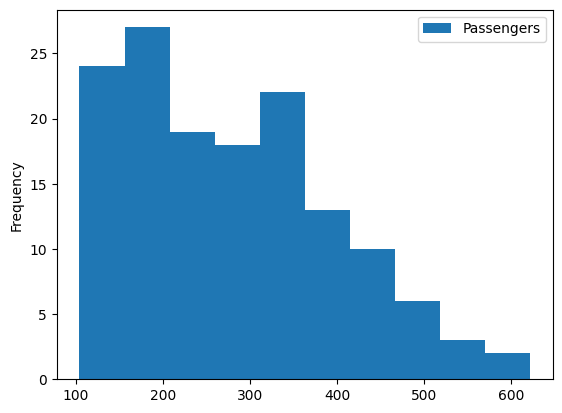

In [ ]:
Data.plot(kind='hist')
plt.show()

- From Histogram Plot
  - we Fount that the plot is Right skewwed so the data is **Non Stationary**

## Augmented Dickey-Fuller Test **(ADF)**

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(Data)
adf_stat = result[0]
p_value = result[1]
print(f'ADF Test Statistics: {adf_stat}')
print(f'p-value: {p_value}')
alpha = 0.05  
if p_value <= alpha:
    print('Reject null hypothesis. Data is stationary.')
else:
    print('Fail to reject null hypothesis. Data is non-stationary.')

ValueError: ignored

- We have tried all the test and all of them confirmed that the data is non stationary so now we will make it **Stationary**

## Covert To Stationary 

In [ ]:
train_data, val_data, test_data = Split(Data, Fixed_Partition=True)
data_train = train_data.append(val_data)

<Axes: xlabel='Month'>

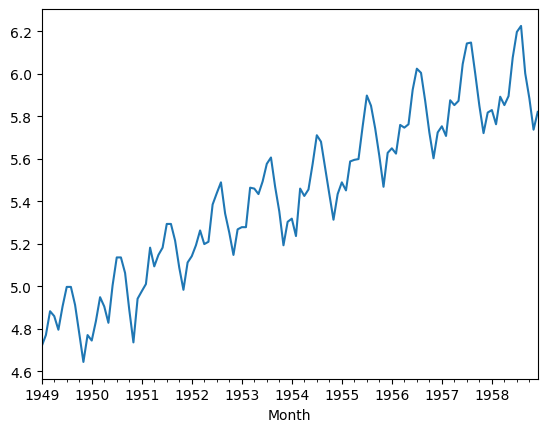

In [ ]:
from scipy import stats
from scipy.special import inv_boxcox
data_train['Passengers_Box'] = stats.boxcox(data_train['Passengers'] , lmbda=0)
data_train['Passengers_Box'].plot()

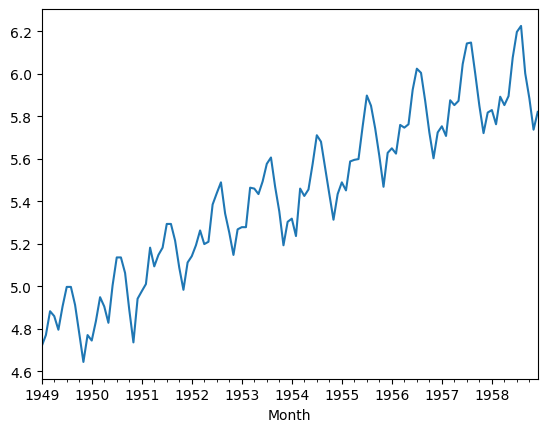

In [ ]:
# Apply log Transforamtion to make data stationary in variance
Data_log = data_train['Passengers_Box']
Data_log.plot()
plt.show()

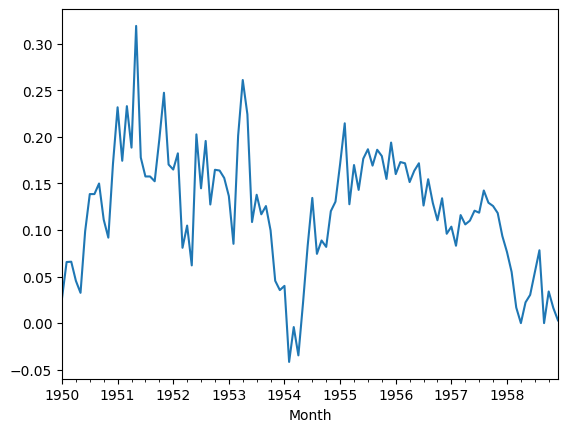

In [ ]:
# # Remove Seasonality Applying Differencing With lag = 12
data_seasonal_diff  = data_train['Passengers_Box'].diff(periods = 12)
data_seasonal_diff = data_seasonal_diff.dropna()
data_seasonal_diff.plot()
plt.show()


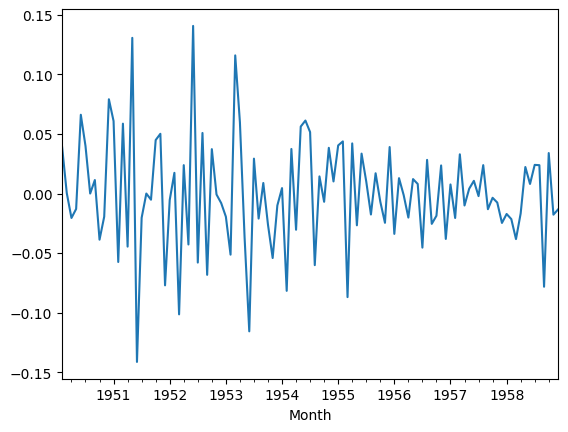

In [ ]:
# Remove Trend Applying Differencing "First difference"
data_trend_diff  = data_seasonal_diff.diff(periods = 1)
data_trend_diff = data_trend_diff.dropna()
data_trend_diff.plot()
plt.show()

In [ ]:
# Now Lets Check The Stationarity of the data using ADF
Stationary_data = data_trend_diff
result = adfuller(Stationary_data)
adf_stat = result[0]
p_value = result[1]
print(f'ADF Test Statistics: {adf_stat}')
print(f'p-value: {p_value}')
alpha = 0.05  
if p_value <= alpha:
    print('Reject null hypothesis. Data is stationary.')
else:
    print('Fail to reject null hypothesis. Data is non-stationary.')

ADF Test Statistics: -4.004616296917234
p-value: 0.001386530934090797
Reject null hypothesis. Data is stationary.


- As Data became Stationary lets Apply ARIMA

## Apply ARIMA

- Befor Applying ARIMA Lets plot ACF & PACF to Determine ARIMA Model

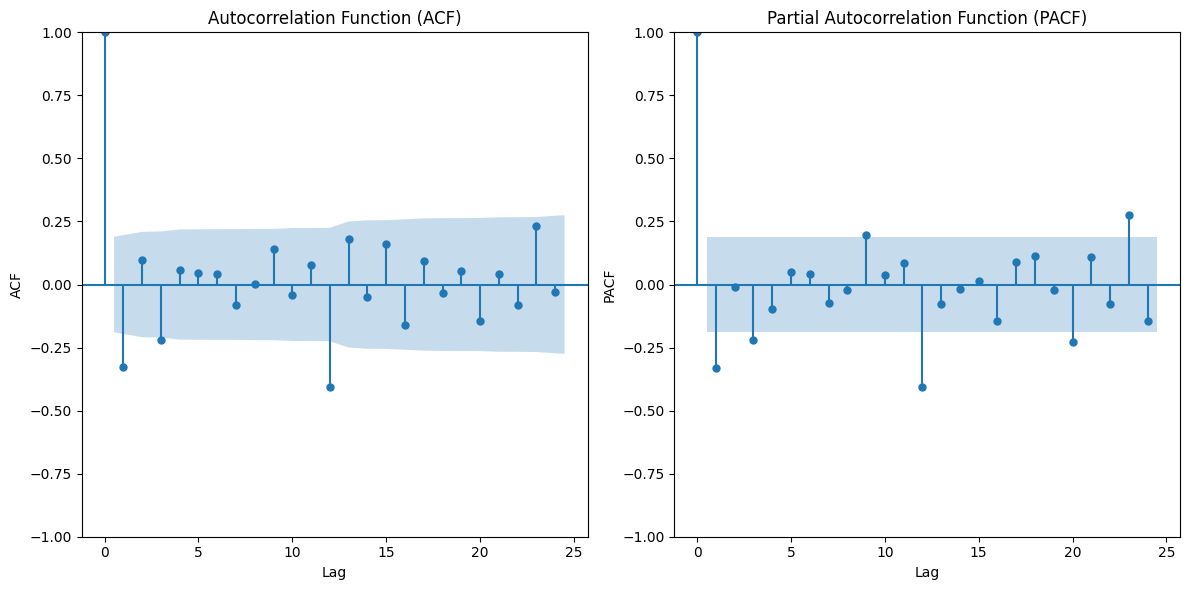

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(Stationary_data, lags=24, ax=ax1)
ax1.set_xlabel('Lag')
ax1.set_ylabel('ACF')
ax1.set_title('Autocorrelation Function (ACF)')


plot_pacf(Stationary_data, lags=24, ax=ax2)
ax2.set_xlabel('Lag')
ax2.set_ylabel('PACF')
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
# ARIMA MODEL  (2,1,2)
model = ARIMA(endog=data_train['Passengers_Box'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Passengers_Box   No. Observations:                  120
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 107.730
Date:                Wed, 05 Apr 2023   AIC                           -205.461
Time:                        21:33:21   BIC                           -191.565
Sample:                    01-01-1949   HQIC                          -199.818
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2555      0.191      1.336      0.181      -0.119       0.630
ar.L2          0.2383      0.237      1.007      0.314      -0.226       0.702
ma.L1         -0.1103      0.142     -0.775      0.4

In [ ]:
# ARIMA MODEL  (2,1,0)

model = ARIMA(endog=data_train['Passengers_Box'], order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  121
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 103.458
Date:                Wed, 05 Apr 2023   AIC                           -200.917
Time:                        11:50:58   BIC                           -192.554
Sample:                             0   HQIC                          -197.520
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2175      0.110      1.970      0.049       0.001       0.434
ar.L2         -0.1628      0.117     -1.396      0.163      -0.391       0.066
sigma2         0.0104      0.002      5.557      0.0

In [ ]:
# ARIMA MODEL  (0,1,2)

model = ARIMA(endog=data_train['Passengers_Box'], order=(0,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  121
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 103.610
Date:                Wed, 05 Apr 2023   AIC                           -201.221
Time:                        11:50:59   BIC                           -192.858
Sample:                             0   HQIC                          -197.825
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1893      0.096      1.978      0.048       0.002       0.377
ma.L2         -0.1975      0.095     -2.081      0.037      -0.384      -0.011
sigma2         0.0104      0.002      5.220      0.0

In [ ]:
model = ARIMA(endog = data_train['Passengers_Box'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

- From the Two plots
  - we use try this model ARIMA(2,1,2) 


## Fixed Partition

In [ ]:
train_data, val_data, test_data = Split(Data, Fixed_Partition=True)
data_train = train_data.append(val_data)


In [ ]:
from scipy import stats
from scipy.special import inv_boxcox
data_train['Passengers_Box'] ,lam = stats.boxcox(data_train['Passengers'] )

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(endog=data_train['Passengers_Box'] , order=(1,1,1))
model_fit = model.fit()

In [ ]:
residuals = model_fit.resid

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Passengers_Box   No. Observations:                  121
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 119.512
Date:                Wed, 05 Apr 2023   AIC                           -229.025
Time:                        20:01:59   BIC                           -215.087
Sample:                             0   HQIC                          -223.365
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6574      0.050     32.943      0.000       1.559       1.756
ar.L2         -0.8979      0.040    -22.457      0.000      -0.976      -0.820
ma.L1         -1.8192      0.061    -29.606      0.0

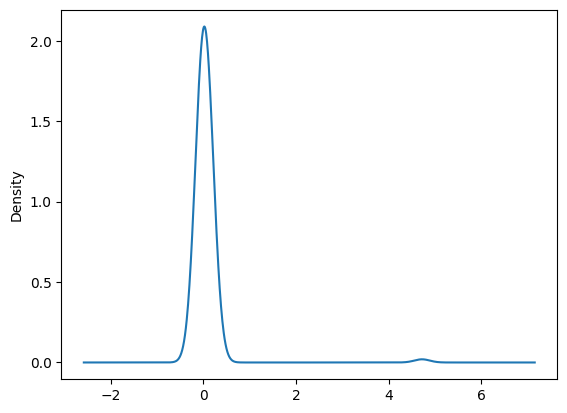

In [ ]:
residuals.plot(kind= 'kde');

In [ ]:
forecast=  model_fit.forecast(len(test_data))

predicted_values = inv_boxcox(forecast,lam)

test_data['y_hat'] = predicted_values.to_list()


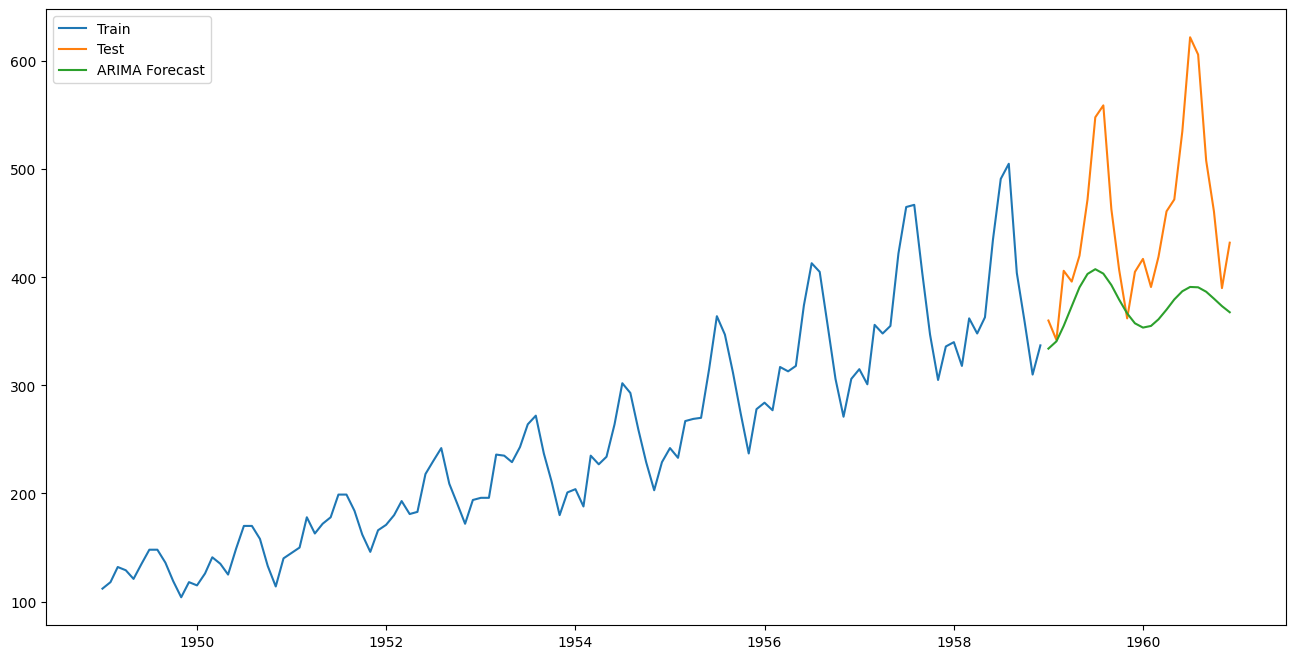

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(data_train['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(test_data['y_hat'], label='ARIMA Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
Evalution(test_data['y_hat'],test_data['Passengers'])

TypeError: ignored

## ROLL

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)
trend = []
test_index = []
test_val = []
forecast_data = []

for train,test in zip(train_data,test_data):
    model = ARIMA(endog=np.log(train), order=(2,1,2))
    model_fit = model.fit()
    # print(f'train -->{train.iloc[-1]}')
    # print(f'test -->{test}')
    # print(f'prediction -->{np.exp(model_fit.forecast())}')
    y_hat = test.copy()
    forecast_data.append(np.exp(model_fit.forecast(len(test))))
    test_val.append(test['Passengers'])
    test_index.append(test.index)





ValueError: ignored

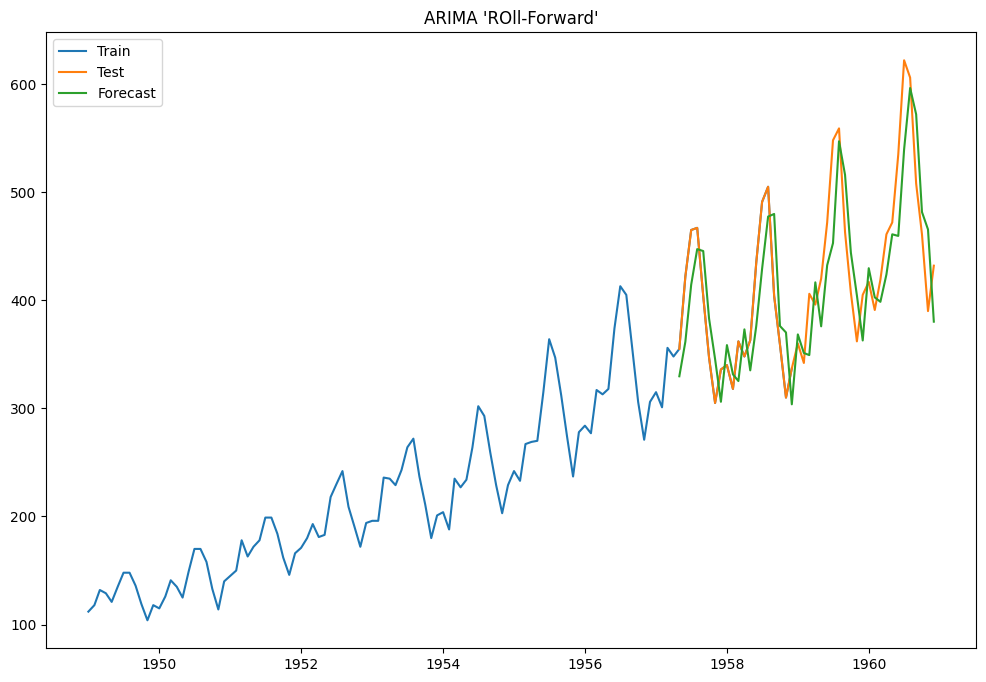

In [ ]:

## PLot    
plt.figure(figsize=(12,8))
plt.plot(data_train.index, data_train['Passengers'], label='Train')
plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,forecast_data, label='Forecast')
plt.legend(loc='best')
plt.title("ARIMA 'ROll-Forward'")
plt.show()

In [ ]:
Evalution(forecast_data,test_val)

RMSE --->  44.44030523752023


## Cross

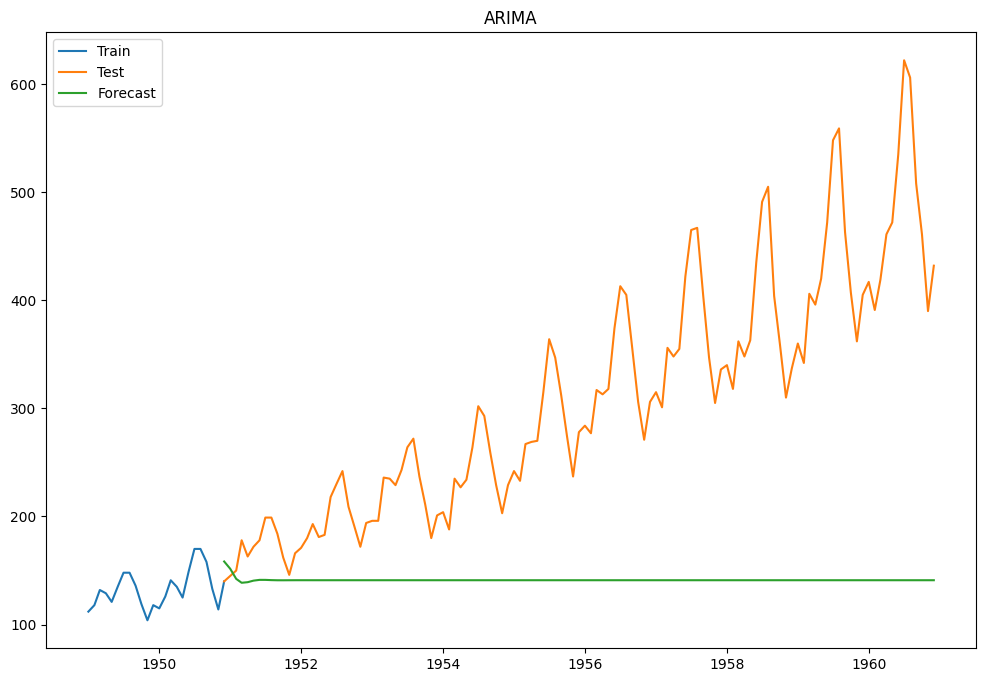

RMSE --->  200.04729921483238


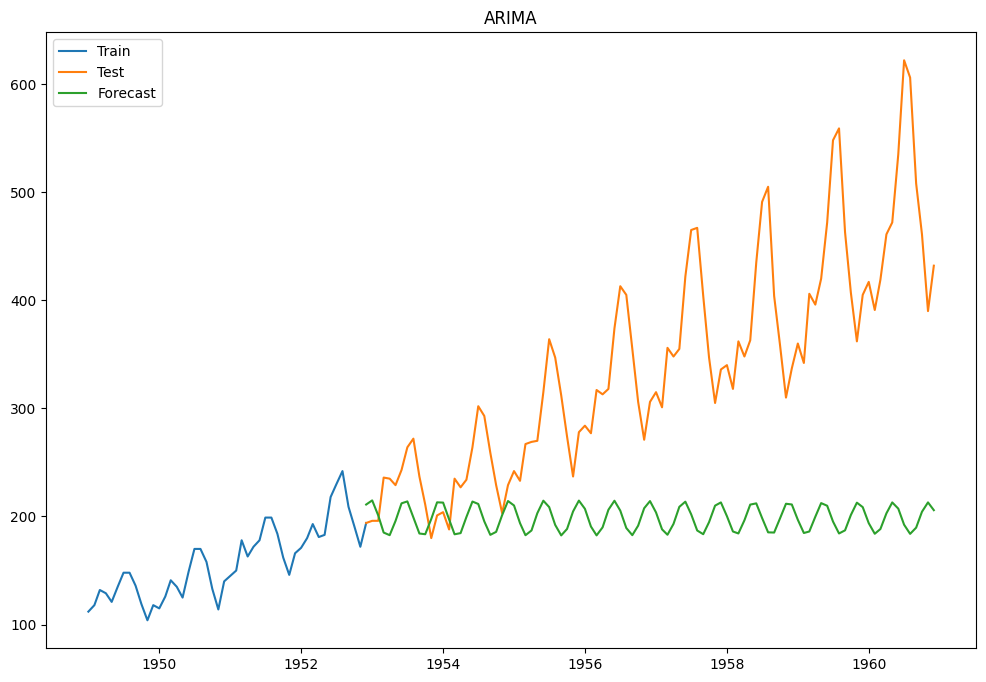

RMSE --->  173.57809835608475


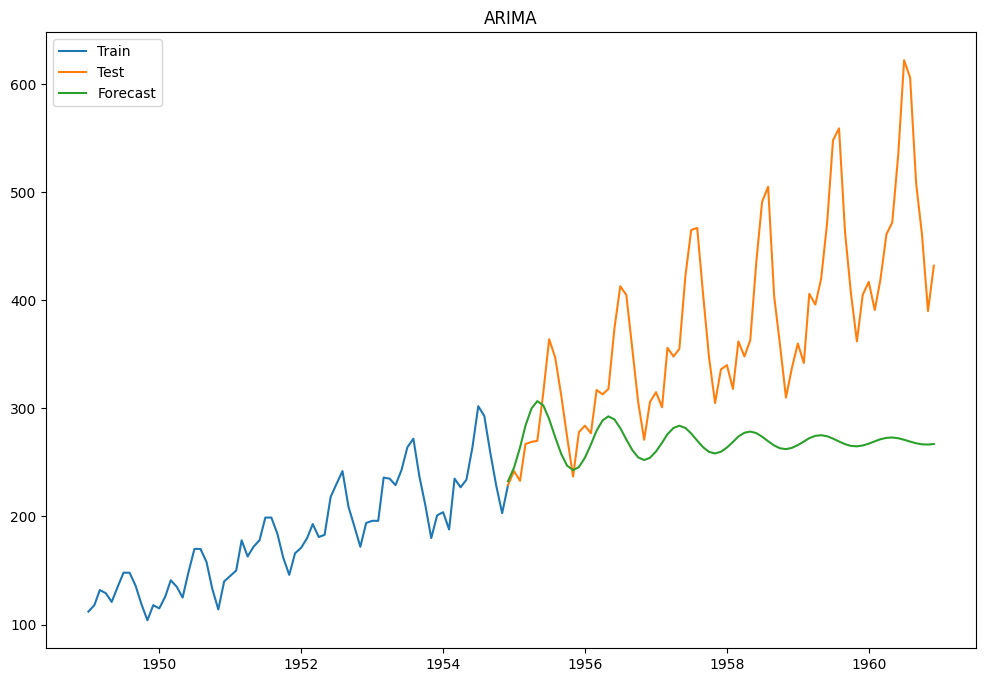

RMSE --->  136.06581727252808


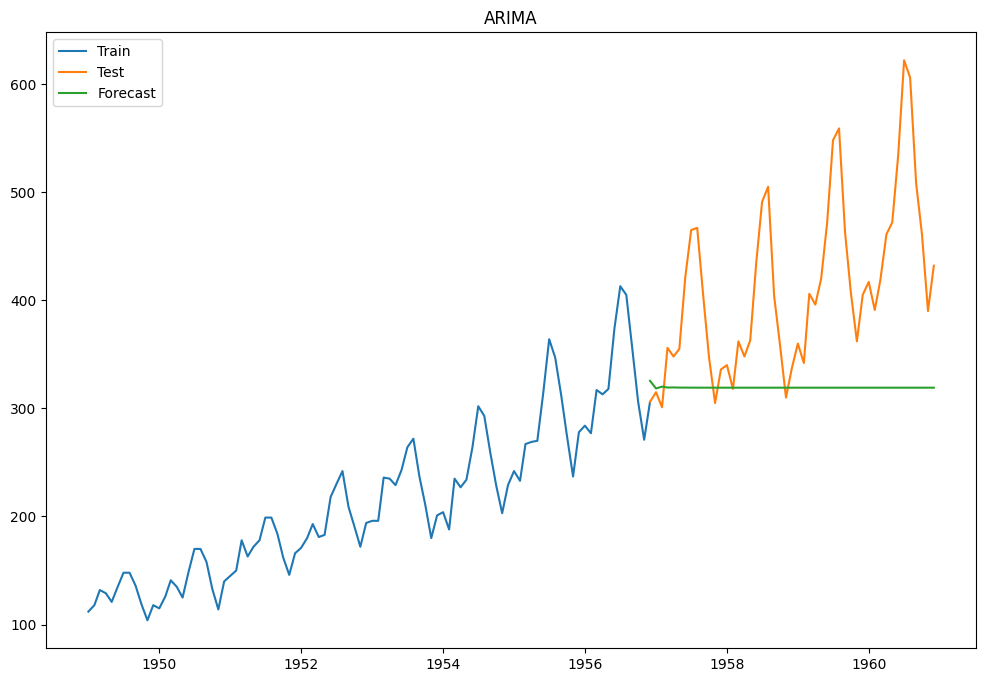

RMSE --->  120.97475446943989


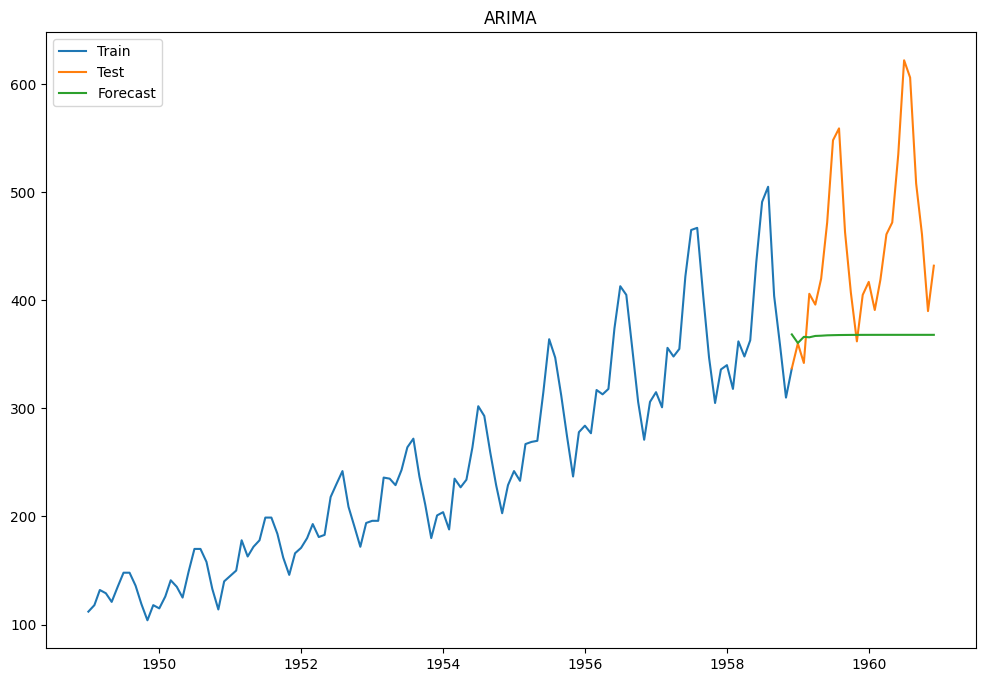

RMSE --->  110.54878268911281
Mean RMSE --> 148.2429504003996


In [ ]:
train_data,test_data  = Split(Data,Cross_validator = True)
Eval_list = []

for train,test in zip(train_data,test_data):
    forecast = []
    train_d = Data.iloc[train]
    test_d = Data.iloc[test]
    y_hat = test_d.copy()
    model = ARIMA(endog=np.log(train_d), order=(2,1,2))
    model_fit = model.fit()
    forecast=  model_fit.forecast(len(test_d))
    predicted_values = np.exp(forecast)
    y_hat['forecast'] = predicted_values.to_list()





    plt.figure(figsize=(12,8))
    plt.plot(train_d.index, train_d['Passengers'], label='Train')
    plt.plot(test_d.index,test_d['Passengers'], label='Test')
    plt.plot(y_hat.index,y_hat['forecast'], label='Forecast')
    plt.legend(loc='best')
    plt.title("ARIMA")
    plt.show()
    Eval_list.append(np.sqrt(mean_squared_error(test_d['Passengers'],y_hat['forecast'])))
    Evalution(test_d['Passengers'],y_hat['forecast'])
print(f'Mean RMSE --> {np.mean(Eval_list)}')

# S-ARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Fixed Partition

In [ ]:
train_data, val_data, test_data = Split(Data, Fixed_Partition=True)
data_train = train_data.append(val_data)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = SARIMAX(endog=np.log(data_train), order=(2,1,2),seasonal_order=(1,1,1,12))
model_fit = model.fit()

In [ ]:
residuals = model_fit.resid

In [ ]:
print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:                             Passengers   No. Observations:                  121
Model:             SARIMAX(10, 1, 10)x(1, 1, [1], 12)   Log Likelihood                 163.345
Date:                                Wed, 05 Apr 2023   AIC                           -280.690
Time:                                        13:13:44   BIC                           -219.001
Sample:                                             0   HQIC                          -255.677
                                                - 121                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2820      1.456     -0.194      0.846      -3.135       2.571
ar.

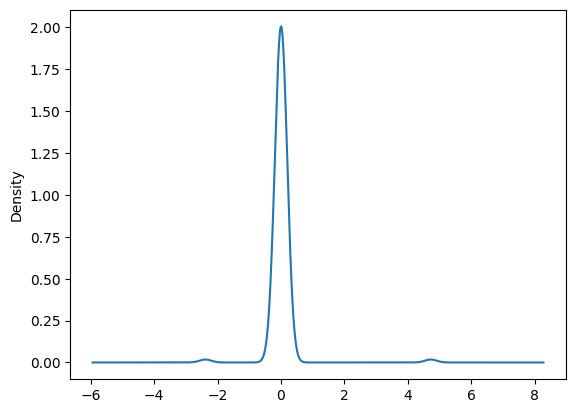

In [ ]:
residuals.plot(kind= 'kde');

In [ ]:
forecast=  model_fit.forecast(len(test_data))

predicted_values = np.exp(forecast)
test_data['y_hat'] = predicted_values.to_list()


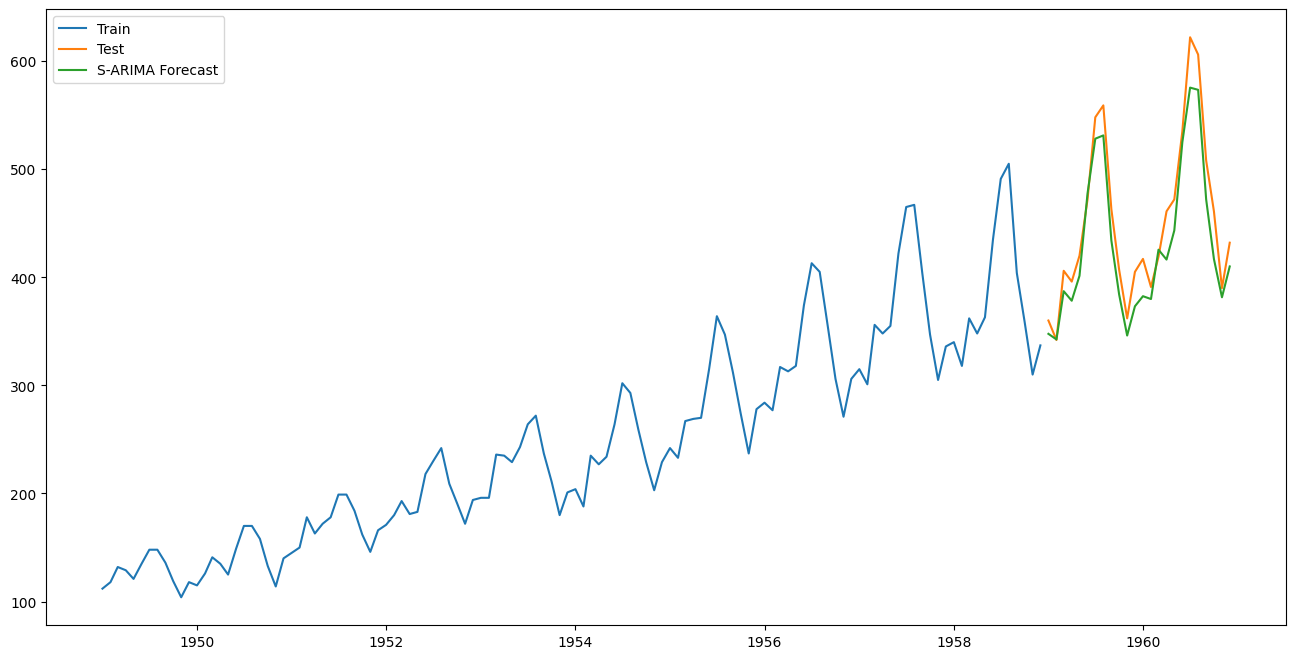

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(data_train['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(test_data['y_hat'], label='S-ARIMA Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
Evalution(test_data['y_hat'],test_data['Passengers'])

RMSE --->  26.053468794293522


## ROLL

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)
trend = []
test_index = []
test_val = []
forecast_data = []



for train,test in zip(train_data,test_data):
    model =SARIMAX(endog=np.log(train), order=(2,1,2),seasonal_order=(1,1,1,12))
    model_fit = model.fit()
    # print(f'train -->{train.iloc[-1]}')
    # print(f'test -->{test}')
    # print(f'prediction -->{np.exp(model_fit.forecast())}')
    y_hat = test.copy()
    forecast_data.append(np.exp(model_fit.forecast(len(test))))
    test_val.append(test['Passengers'])
    test_index.append(test.index)





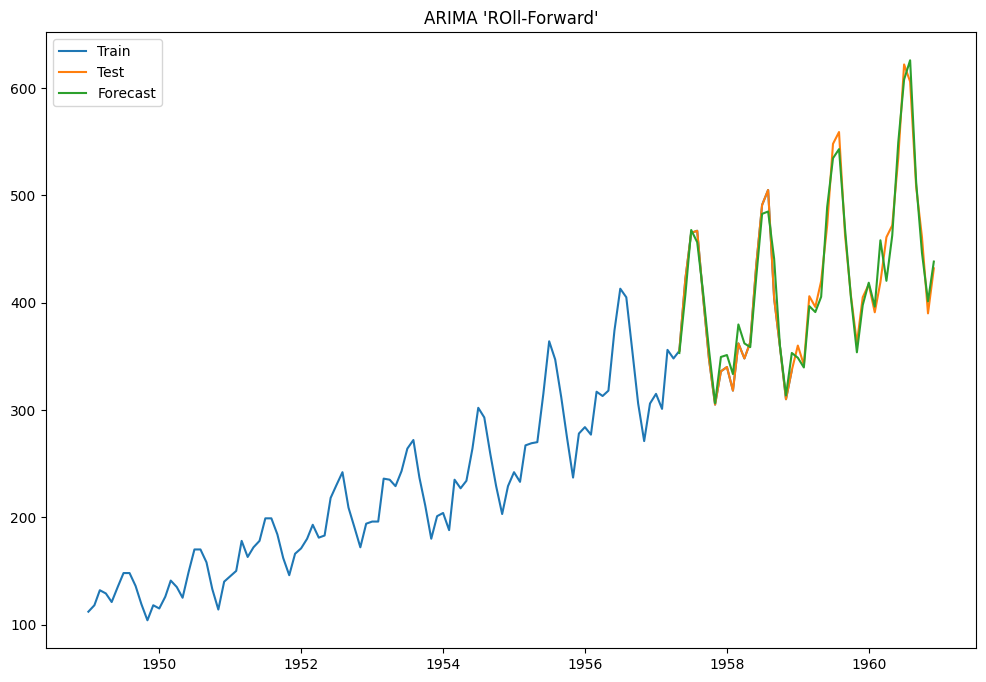

In [ ]:

## PLot    
plt.figure(figsize=(12,8))
plt.plot(data_train.index, data_train['Passengers'], label='Train')
plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,forecast_data, label='Forecast')
plt.legend(loc='best')
plt.title("S-ARIMA 'ROll-Forward'")
plt.show()

In [ ]:
Evalution(forecast_data,test_val)

RMSE --->  14.748331084051731


## Cross

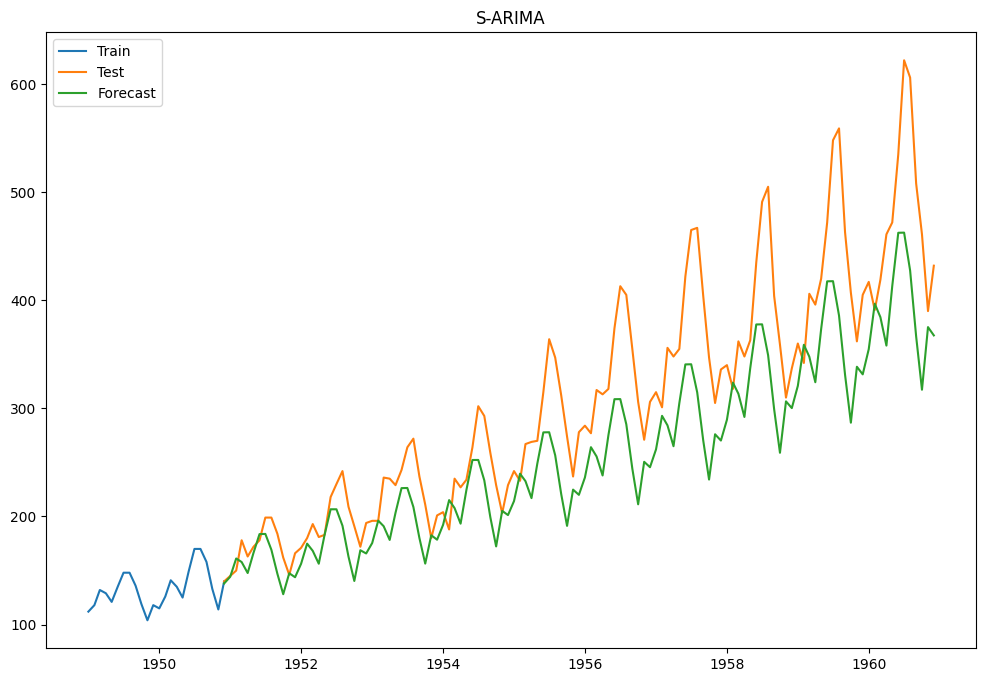

RMSE --->  67.81843705537472


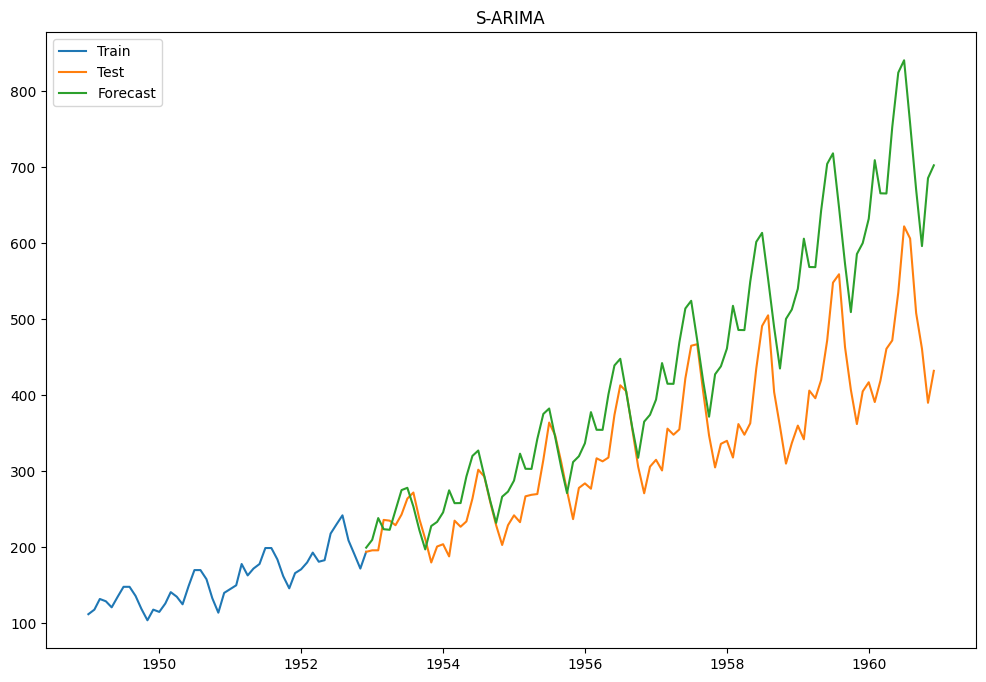

RMSE --->  125.73998804699212


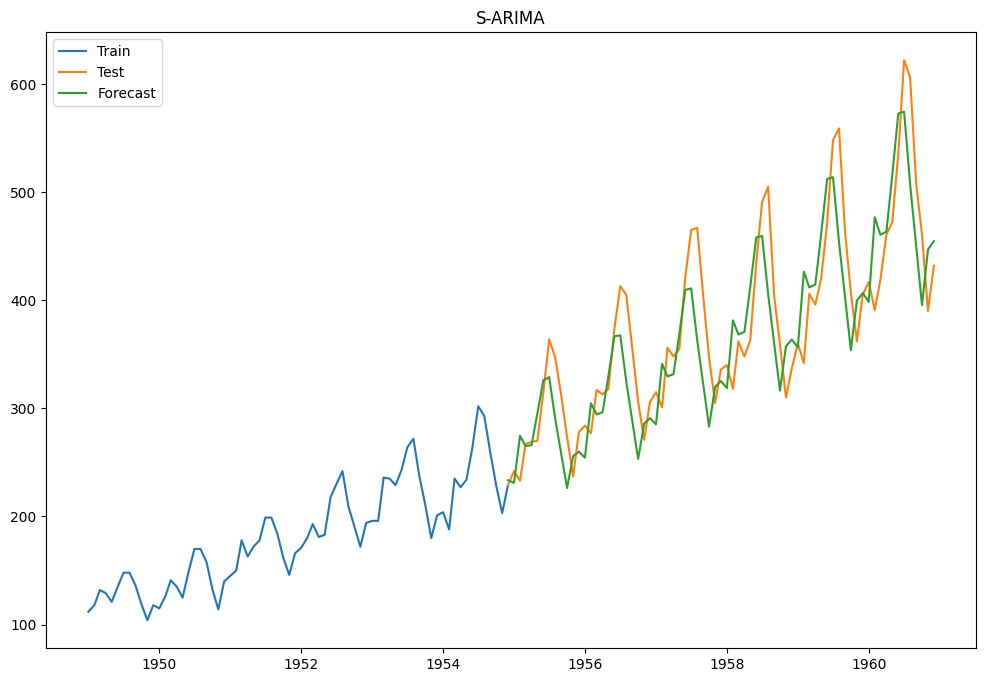

RMSE --->  45.79114774360094


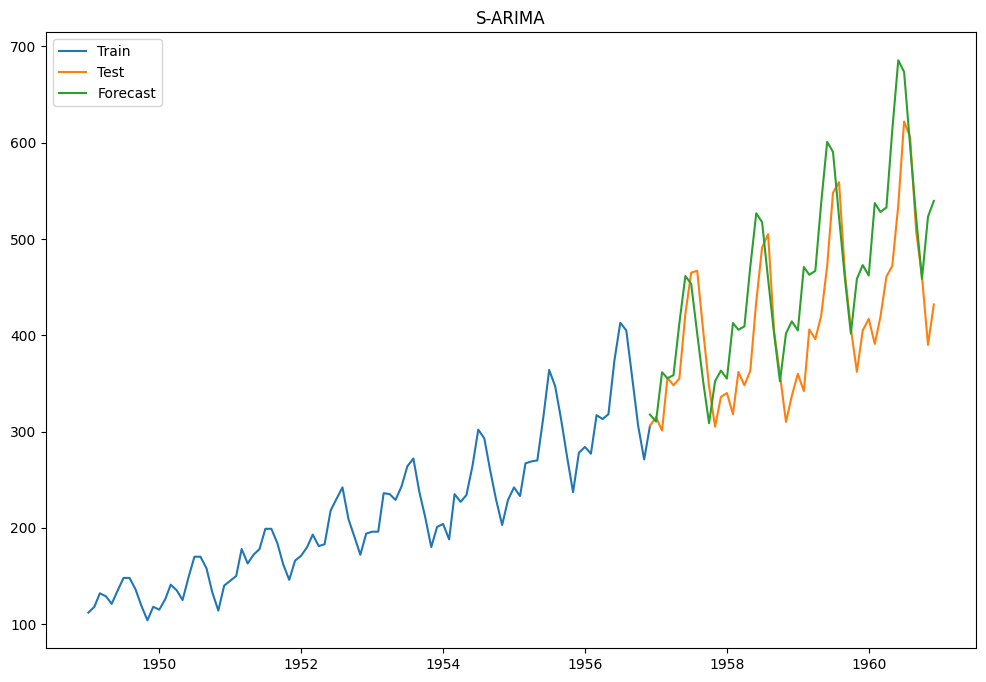

RMSE --->  73.12154327765872


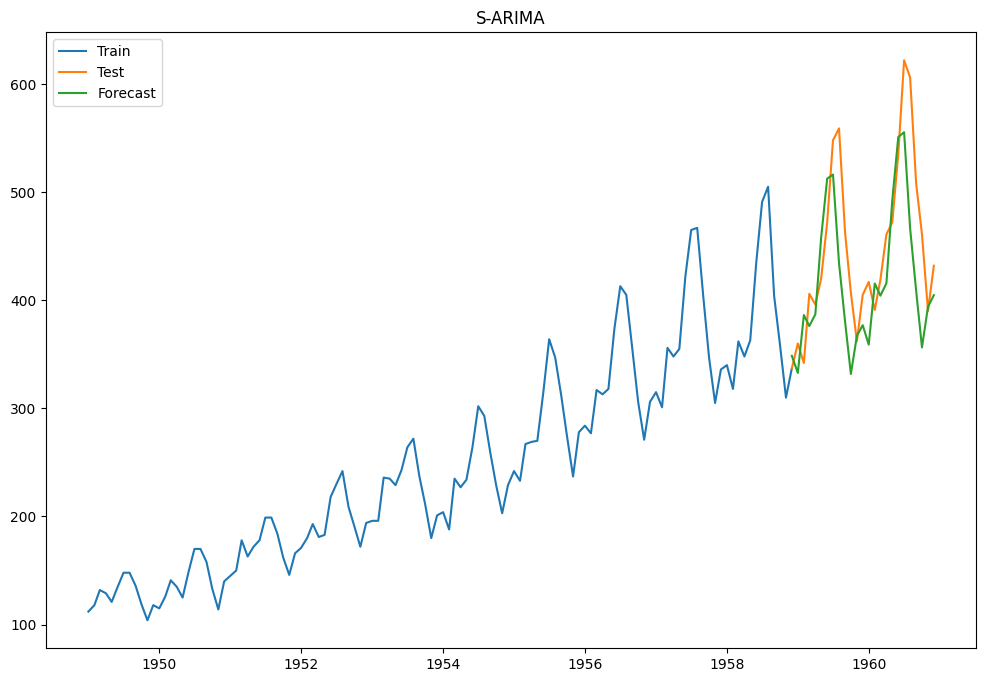

RMSE --->  59.687531225986845
Mean RMSE --> 74.43172946992266


In [ ]:
train_data,test_data  = Split(Data,Cross_validator = True)
Eval_list = []

for train,test in zip(train_data,test_data):
    forecast = []
    train_d = Data.iloc[train]
    test_d = Data.iloc[test]
    y_hat = test_d.copy()
    model = SARIMAX(endog=np.log(train_d), order=(2,1,2),seasonal_order=(1,1,1,12))
    model_fit = model.fit()
    forecast=  model_fit.forecast(len(test_d))
    predicted_values = np.exp(forecast)
    y_hat['forecast'] = predicted_values.to_list()





    plt.figure(figsize=(12,8))
    plt.plot(train_d.index, train_d['Passengers'], label='Train')
    plt.plot(test_d.index,test_d['Passengers'], label='Test')
    plt.plot(y_hat.index,y_hat['forecast'], label='Forecast')
    plt.legend(loc='best')
    plt.title("S-ARIMA")
    plt.show()
    Eval_list.append(np.sqrt(mean_squared_error(test_d['Passengers'],y_hat['forecast'])))
    Evalution(test_d['Passengers'],y_hat['forecast'])
print(f'Mean RMSE --> {np.mean(Eval_list)}')

In [ ]:
Sarima_model  =  SARIMAX(e)

# Exponential Smoothing  

## Double exponential smoothing

In [ ]:
import plotly.graph_objects as go
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

## Fixed Partition

### Additive Approach

In [ ]:
train_data, val_data, test_data = Split(Data, Fixed_Partition=True)
data_train = train_data.append(val_data)

In [ ]:
# Holt's Linear Trend Method (Double Exponential Smoothing – Additive Approach)
model = Holt(data_train['Passengers']).fit(optimized=True)
forecasts = model.forecast(len(test_data))
forecasts

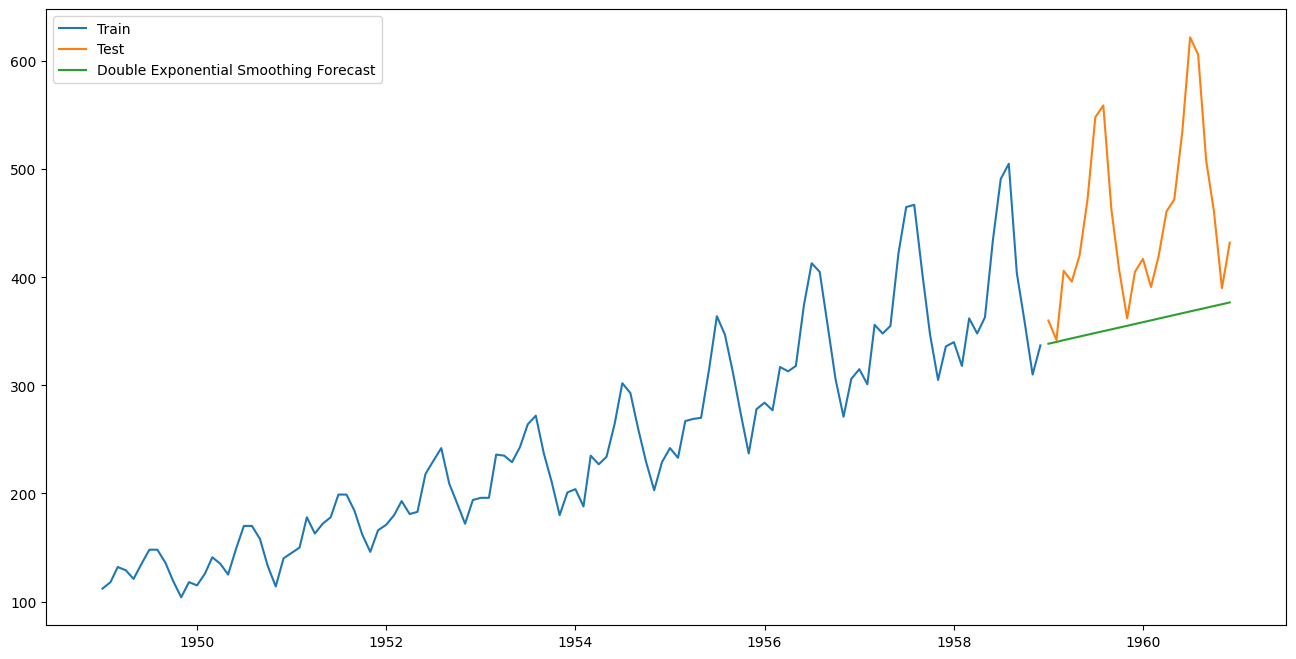

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(data_train['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(forecasts, label = 'Double Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
Evalution(forecasts,test_data['Passengers'])

RMSE --->  136.4600308353549


### Multiplicative Approach

In [ ]:
# Exponential Trend Method (Double Exponential Smoothing - Multiplicative Approach)
model = ExponentialSmoothing(data_train['Passengers'], trend='mul').fit(optimized=True)
forecasts = model.forecast(len(test_data))


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



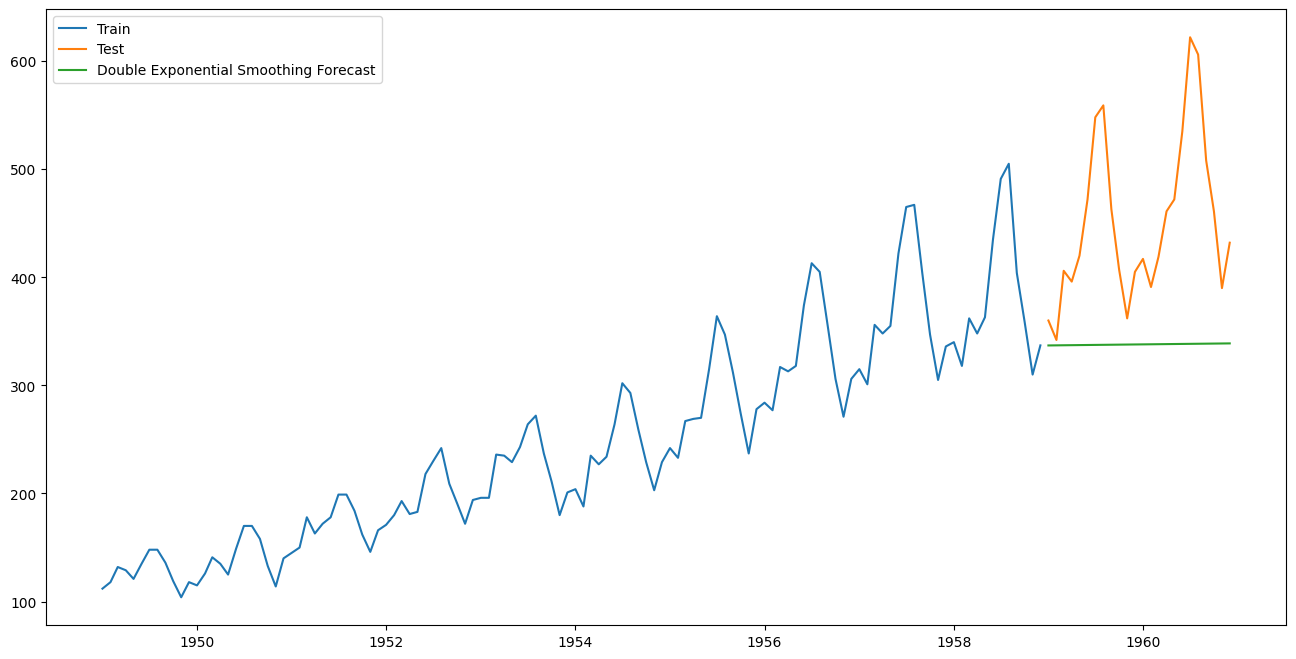

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(data_train['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(forecasts, label = 'Double Exponential Smoothing Forecast - Multiplicative Approach ')
plt.legend(loc='best')
plt.show()

## ROLL

### Additive Apporach

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)
trend = []
test_index = []
test_val = []
forecast_data = []

for train,test in zip(train_data,test_data):
    model = Holt(train['Passengers']).fit(optimized=True)
    forecasts = model.forecast(len(test))
    forecast_data.append(forecasts)
    test_val.append(test['Passengers'])
    test_index.append(test.index)





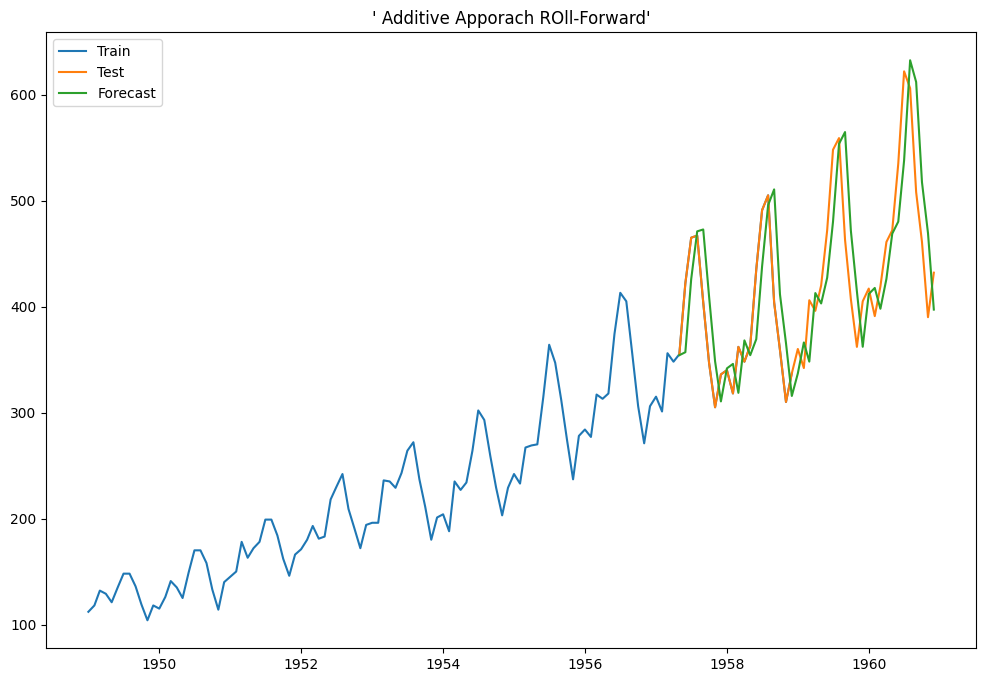

In [ ]:

## PLot    
plt.figure(figsize=(12,8))
plt.plot(data_train.index, data_train['Passengers'], label='Train')
plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,forecast_data, label='Forecast')
plt.legend(loc='best')
plt.title("Double Exponential Smoothing - Multiplicative Approach")
plt.show()

In [ ]:
Evalution(forecast_data,test_val)

RMSE --->  49.68414289271368


### Multiplicative Apporach

In [ ]:
train_data,test_data  = Split(Data,Roll_Forward = True)
trend = []
test_index = []
test_val = []
forecast_data = []

for train,test in zip(train_data,test_data):
    model =  ExponentialSmoothing(train['Passengers'], trend='mul').fit(optimized=True)
    forecasts = model.forecast(len(test))
    forecast_data.append(forecasts)
    test_val.append(test['Passengers'])
    test_index.append(test.index)

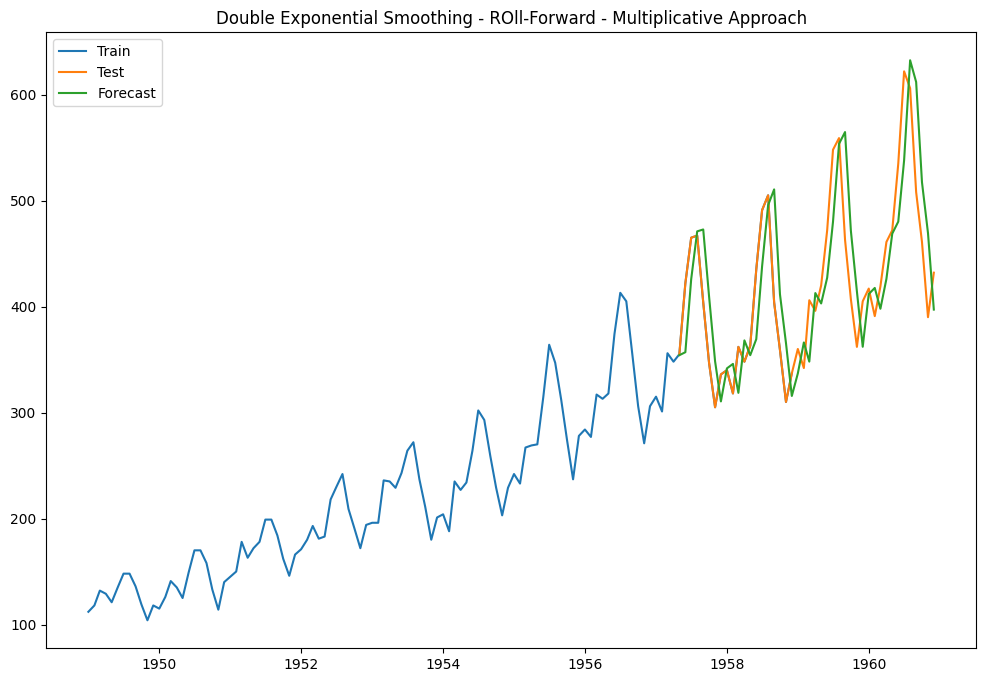

In [ ]:

## PLot    
plt.figure(figsize=(12,8))
plt.plot(data_train.index, data_train['Passengers'], label='Train')
plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,forecast_data, label='Forecast')
plt.legend(loc='best')
plt.title("Double Exponential Smoothing - ROll-Forward - Multiplicative Approach")
plt.show()

In [ ]:
Evalution(forecast_data,test_val)

RMSE --->  50.10393463138074


## Cross

### Additive Apporach 

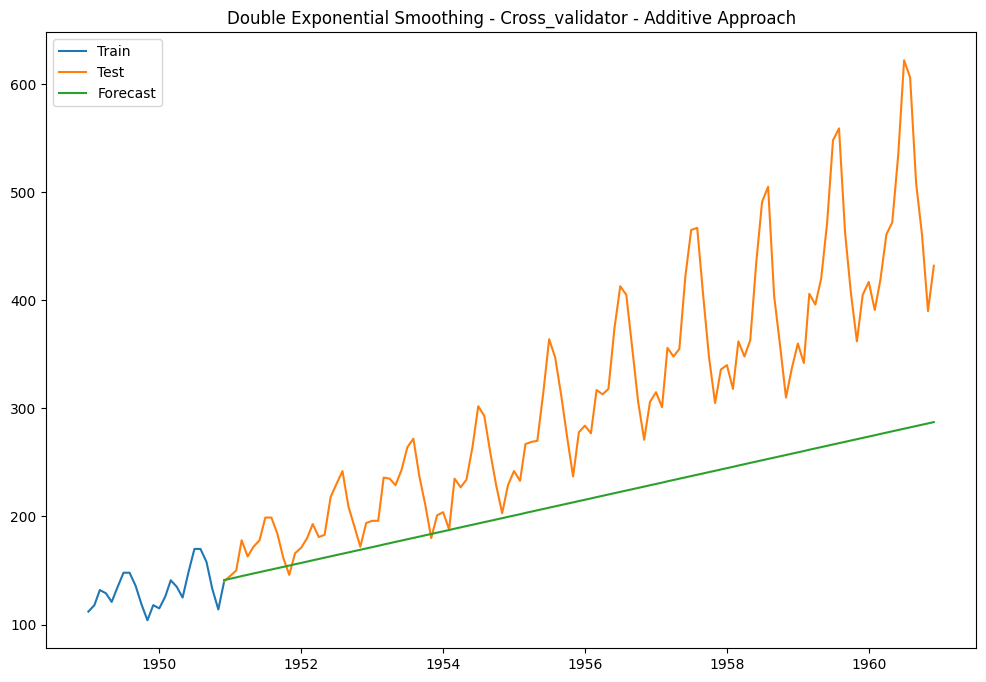

RMSE --->  119.65376137561096


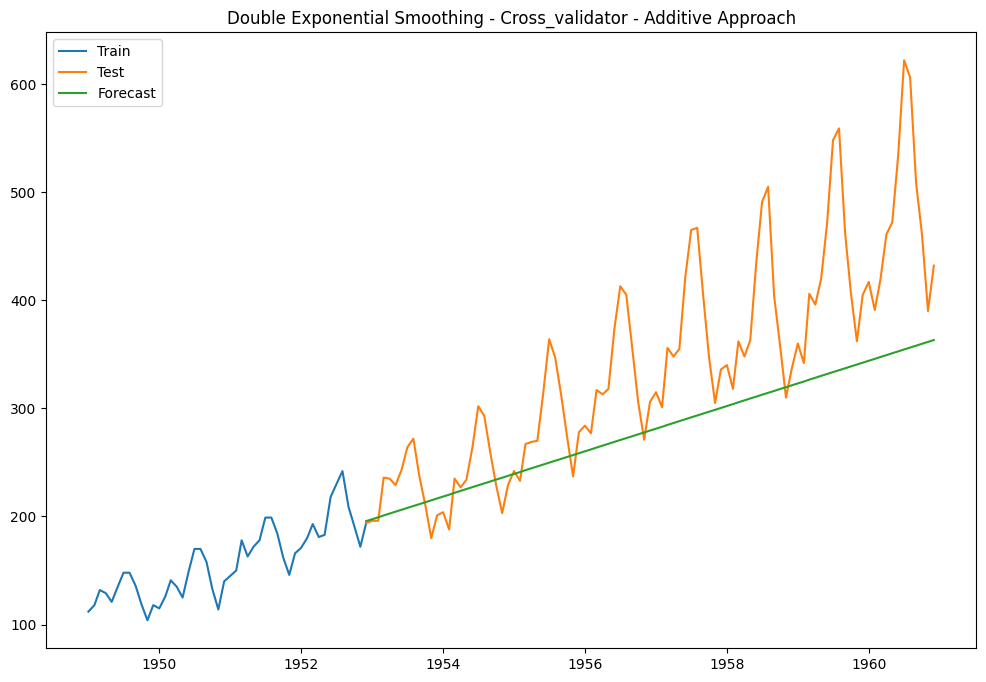

RMSE --->  87.50154032948564


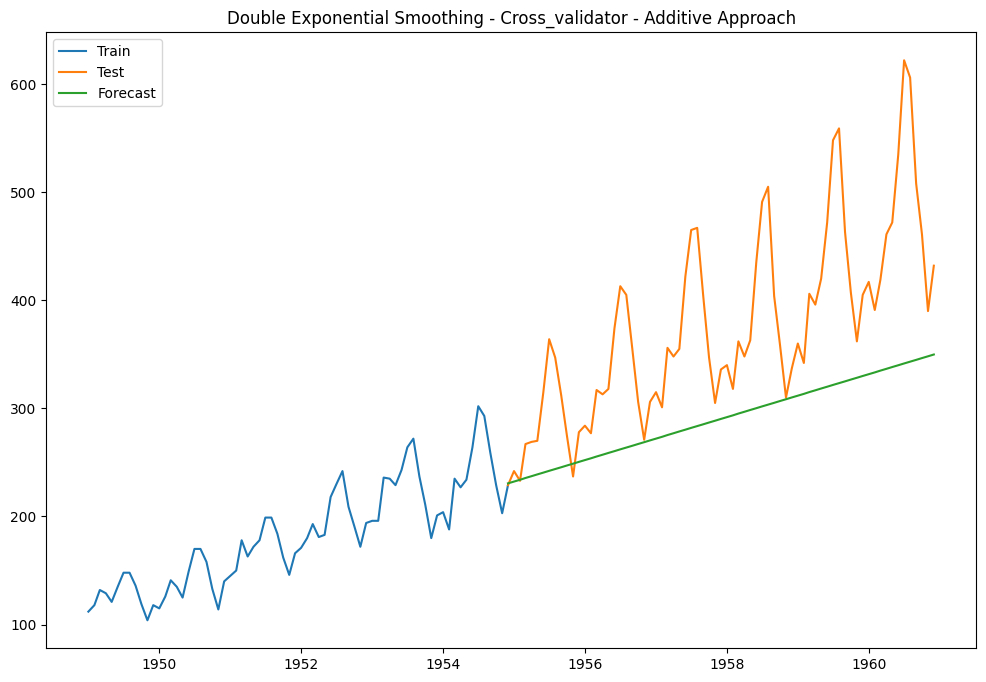

RMSE --->  107.4460859409439


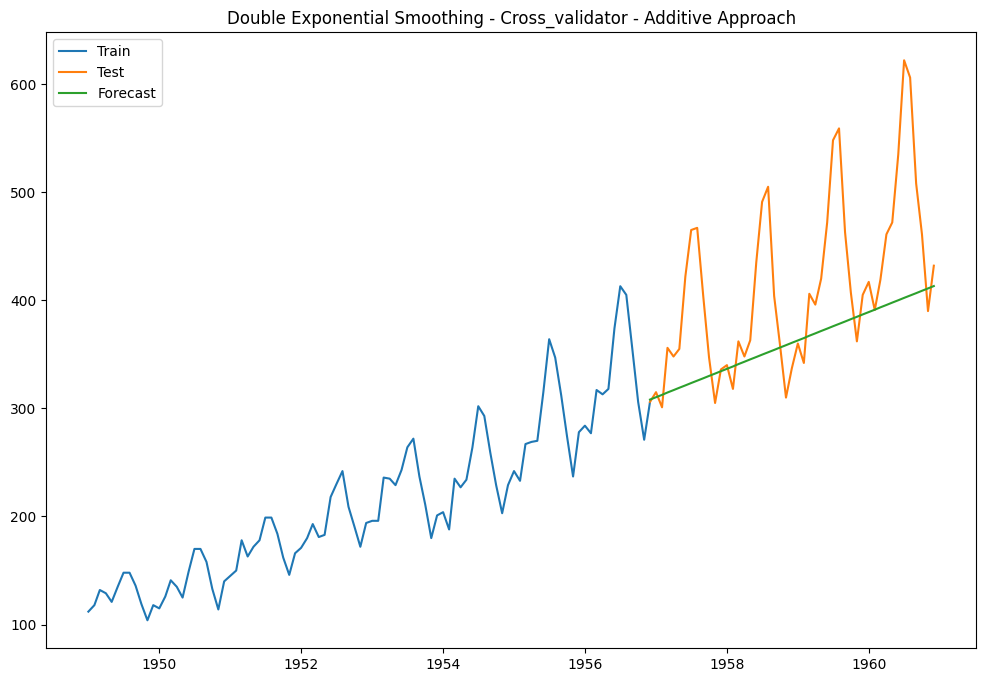

RMSE --->  82.84444810262197


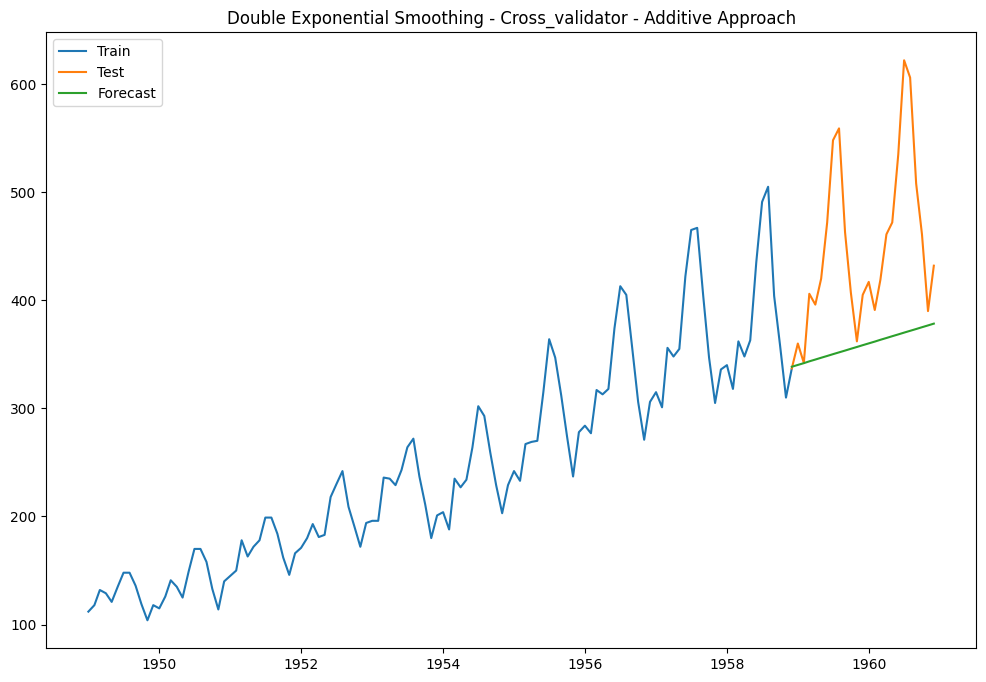

RMSE --->  114.62934664852014
Mean RMSE --> 102.41503647943652


In [ ]:
train_data,test_data  = Split(Data,Cross_validator = True)
Eval_list = []

for train,test in zip(train_data,test_data):
    forecast = []
    train_d = Data.iloc[train]
    test_d = Data.iloc[test]
    y_hat = test_d.copy()
    model = Holt(train_d['Passengers']).fit(optimized=True)
    forecasts = model.forecast(len(test_d))
 
    plt.figure(figsize=(12,8))
    plt.plot(train_d.index, train_d['Passengers'], label='Train')
    plt.plot(test_d.index,test_d['Passengers'], label='Test')
    plt.plot(y_hat.index,forecasts, label='Forecast')
    plt.legend(loc='best')
    plt.title("Double Exponential Smoothing - Cross_validator - Additive Approach")
    plt.show()
    Eval_list.append(np.sqrt(mean_squared_error(test_d['Passengers'],forecasts)))
    Evalution(test_d['Passengers'],forecasts)
print(f'Mean RMSE --> {np.mean(Eval_list)}')

### Multiplicative Approach

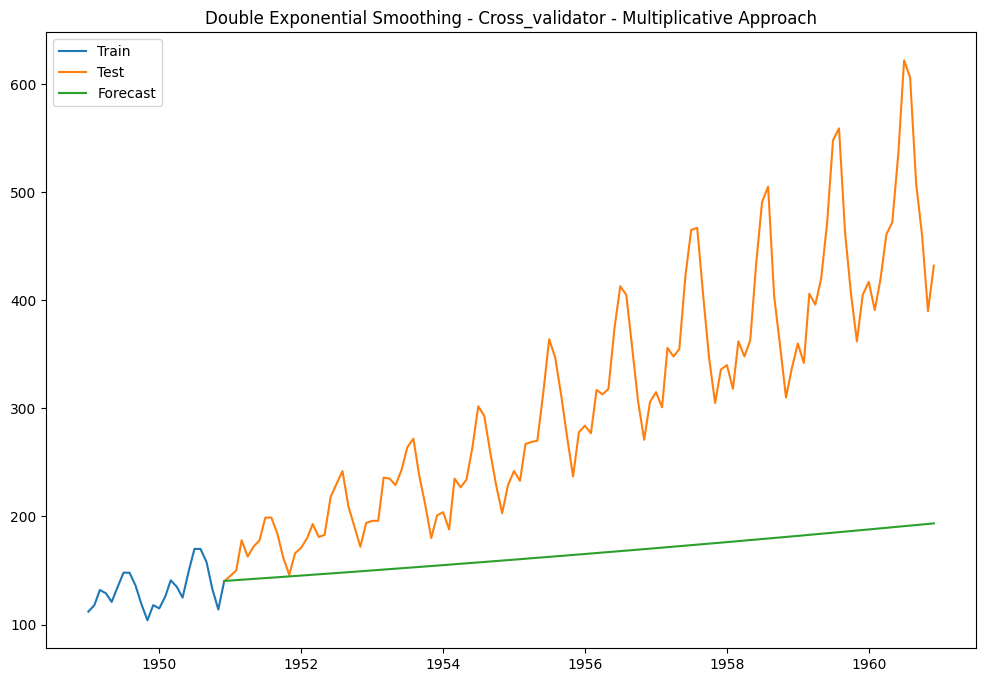

RMSE --->  172.0089296261751


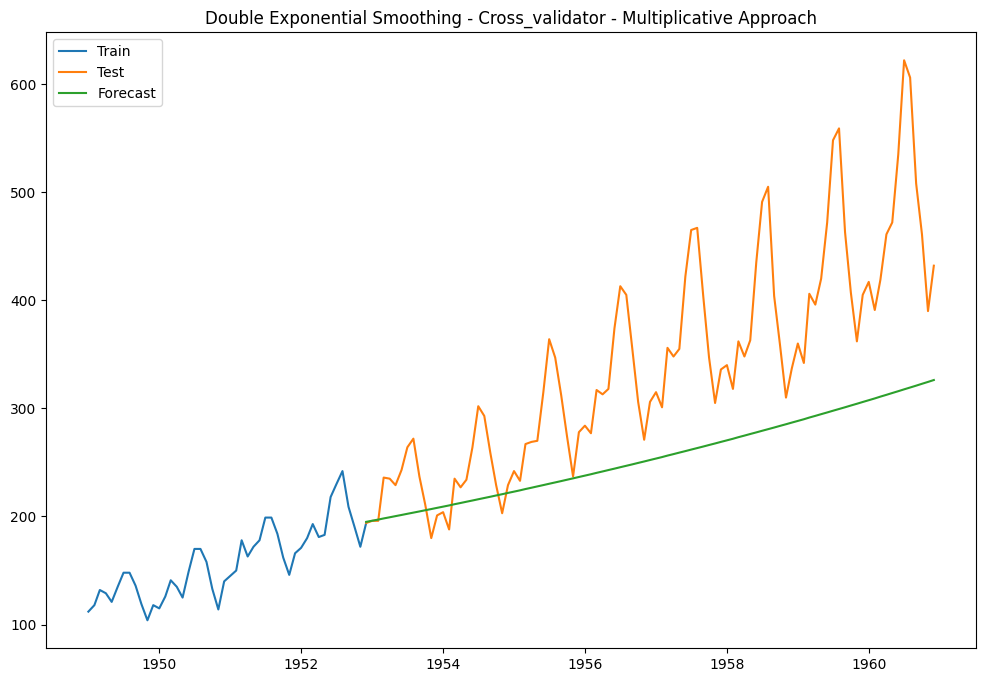

RMSE --->  109.81681733620114


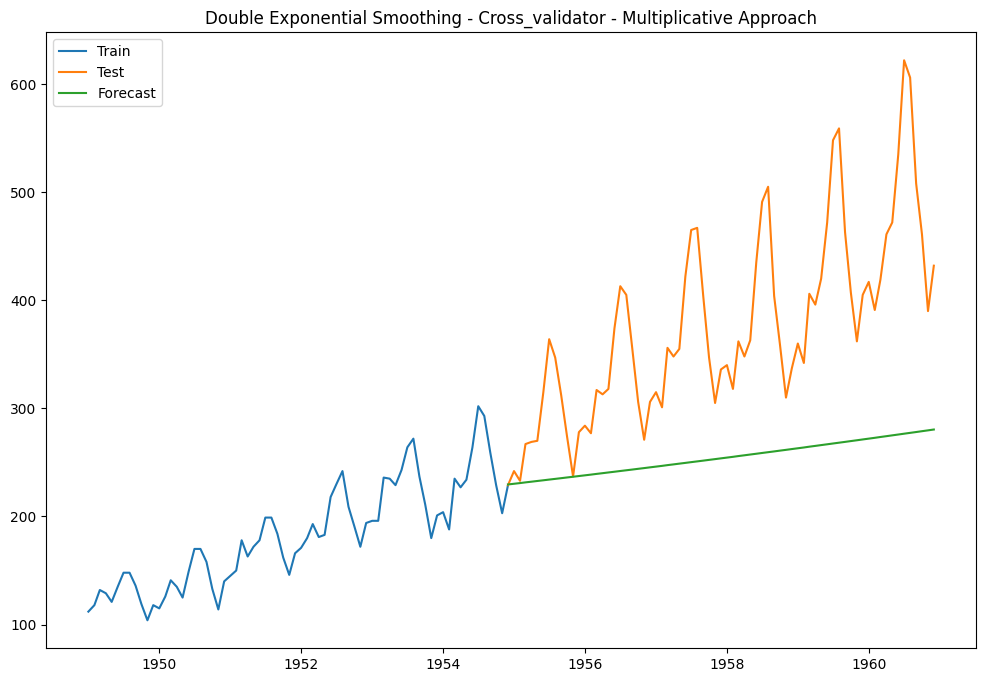

RMSE --->  143.54075526561158


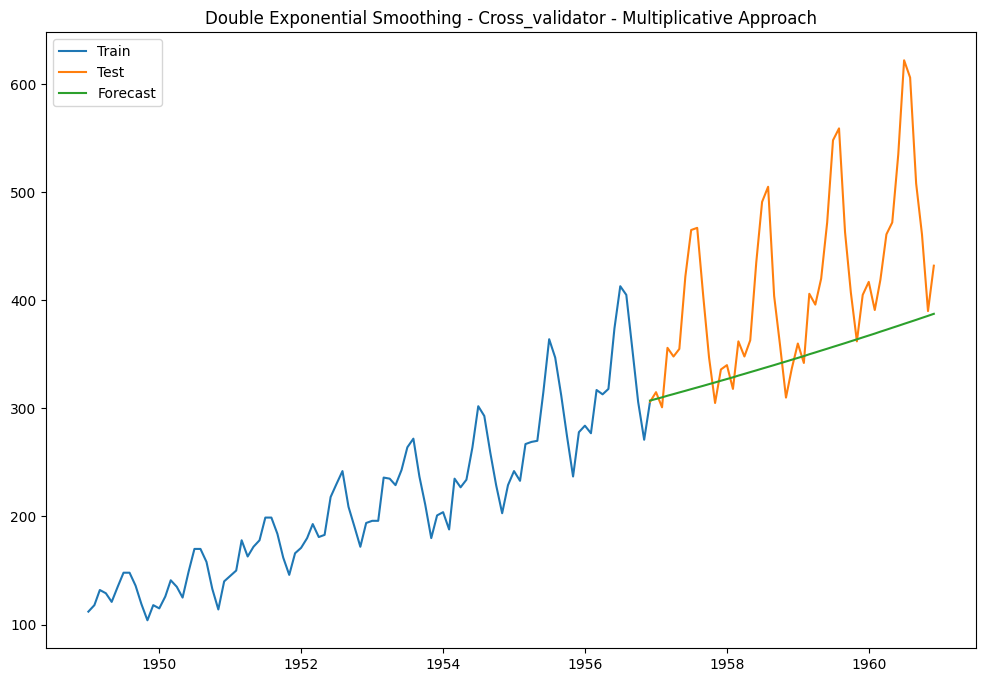

RMSE --->  94.02625917019823


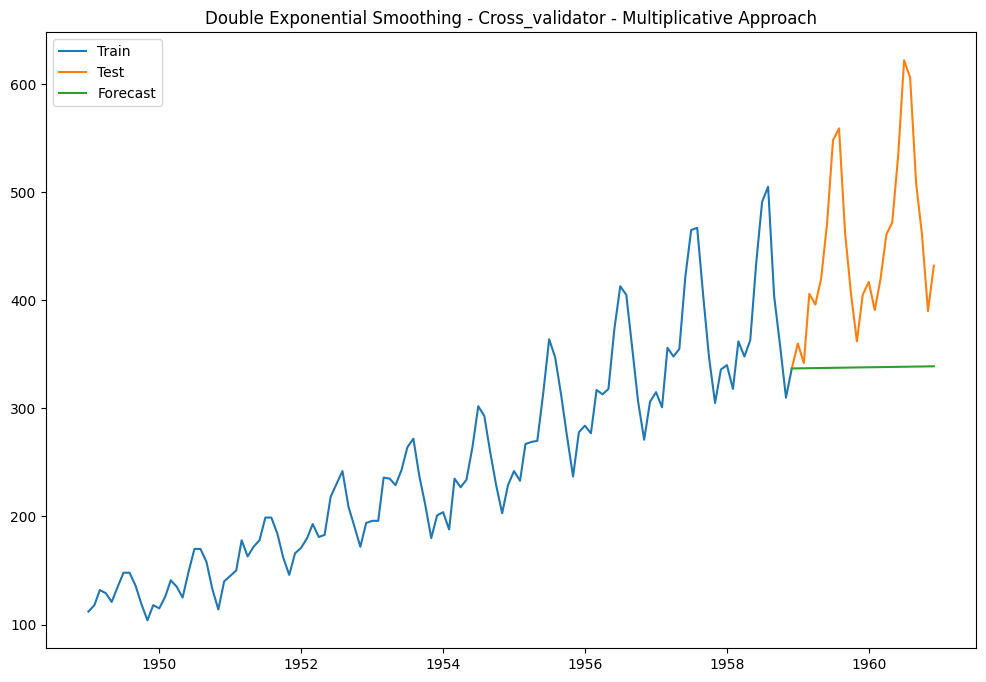

RMSE --->  133.63548391451545
Mean RMSE --> 130.6056490625403


In [ ]:
train_data,test_data  = Split(Data,Cross_validator = True)
Eval_list = []

for train,test in zip(train_data,test_data):
    forecast = []
    train_d = Data.iloc[train]
    test_d = Data.iloc[test]
    y_hat = test_d.copy()
    model = ExponentialSmoothing(train_d['Passengers'], trend='mul').fit(optimized=True)
    forecasts = model.forecast(len(test_d))
 
    plt.figure(figsize=(12,8))
    plt.plot(train_d.index, train_d['Passengers'], label='Train')
    plt.plot(test_d.index,test_d['Passengers'], label='Test')
    plt.plot(y_hat.index,forecasts, label='Forecast')
    plt.legend(loc='best')
    plt.title("Double Exponential Smoothing - Cross_validator - Multiplicative Approach")
    plt.show()
    Eval_list.append(np.sqrt(mean_squared_error(test_d['Passengers'],forecasts)))
    Evalution(test_d['Passengers'],forecasts)
print(f'Mean RMSE --> {np.mean(Eval_list)}')

# FaceBook Prophet

In [ ]:
!pip install prophet

## Fixed Partation

In [ ]:
def fixed_partition(data, test_size):
  df_train = data[ : -test_size]
  df_test = data[-test_size : ]
  return df_train, df_test

def roll_forward(data, window_size, test_size):
    num_folds = len(data) - window_size - test_size + 1
    for i in range(num_folds):
        train_start = 0
        train_end = i + window_size
        test_start = train_end
        test_end = test_start + test_size

        df_train = data.iloc[train_start:train_end]
        df_test = data.iloc[test_start:test_end]

        yield df_train, df_test

def cross_validation(data, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    for i, (train_index, test_index) in enumerate(tscv.split(data)):
        train_size = int((i+1)/n_splits * len(data))
        if i == n_splits-1:
            train_size = len(data) - len(test_index)
        train_data = data.iloc[:train_size]
        test_data = data.iloc[train_size:]
        splits.append((train_data, test_data))
    return splits

In [ ]:
# Rename the columns
data_FB = df.rename(columns={'Month': 'ds', 'Passengers': 'y'})



In [ ]:
from prophet import Prophet
train_data,test_data = fixed_partition(data_FB, 24)



In [ ]:
model = Prophet()
model.fit(train_data)
future_dates = model.make_future_dataframe(periods=24, freq='MS')
forecast = model.predict(future_dates[-24:])


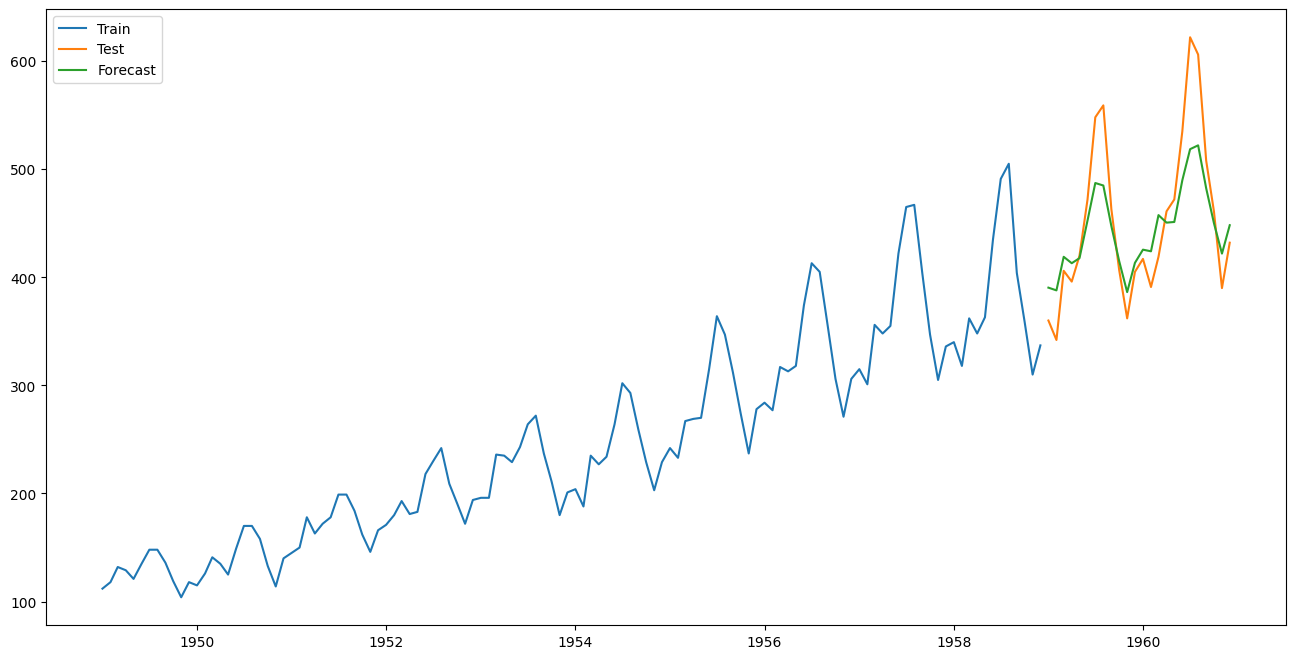

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(data_train['ds'],data_train['y'], label='Train')
plt.plot(test_data['ds'],test_data['y'], label='Test')
plt.plot(forecast['ds'].tolist(),forecast['yhat'].tolist(), label = 'Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
Evalution(forecast['yhat'].tolist(),test_data['y'])

RMSE --->  40.35218846265365


## Roll

In [ ]:
train_data,test_data  = Split(data_FB,Roll_Forward = True)
trend = []
test_index = []
test_val = []
forecast_data = []
for train,test in roll_forward(data_FB, 120, 1):
    model = Prophet()
    model.fit(train)
    future_dates = model.make_future_dataframe(periods=1, freq='MS')
    forecast = model.predict(future_dates)
    forecast_data.append(forecast['yhat'].iloc[-1])
    test_val.append(test['y'])
    test_index.append(test['ds'])

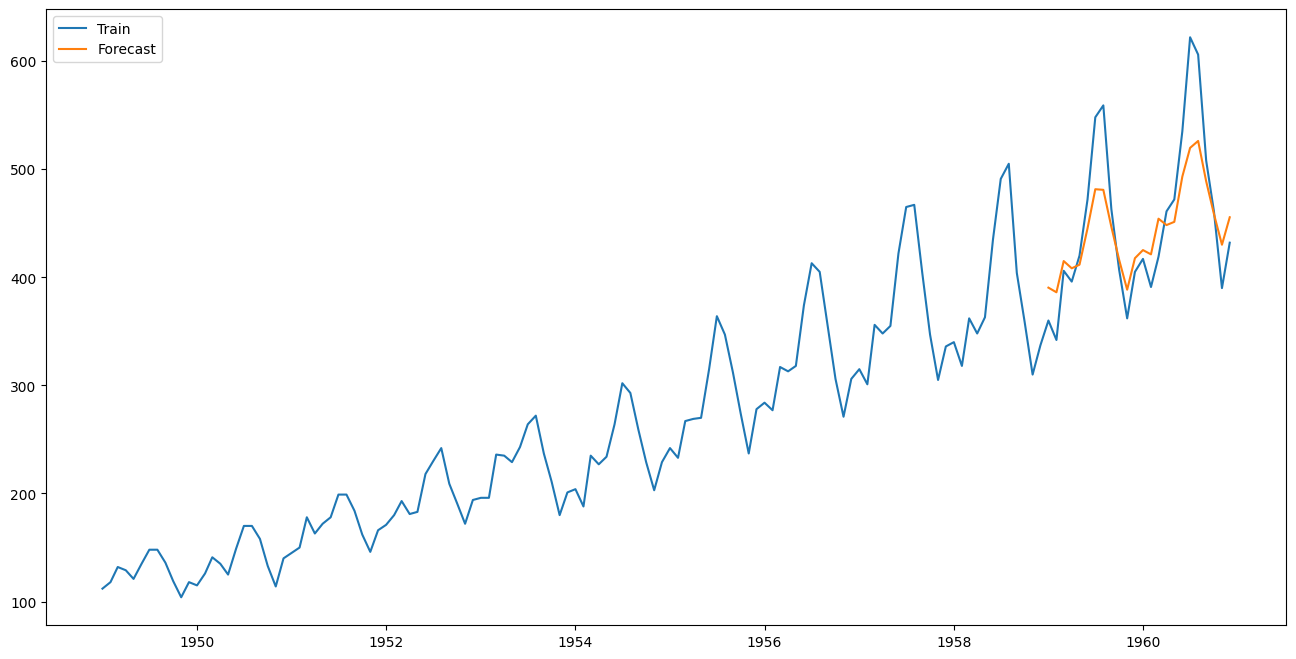

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(data_FB['ds'],data_FB['y'], label='Train')
# plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,forecast_data, label = 'Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
Evalution(test_val,forecast_data)

RMSE --->  39.27442732511225


## Cross

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntkfn3ct/5kkyaab7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntkfn3ct/ghzcnhsr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28974', 'data', 'file=/tmp/tmpntkfn3ct/5kkyaab7.json', 'init=/tmp/tmpntkfn3ct/ghzcnhsr.json', 'output', 'file=/tmp/tmpntkfn3ct/prophet_modelg1_co1yw/prophet_model-20230406145727.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:57:27 - cmdstanpy - INFO - Chain [1] start processing
IN

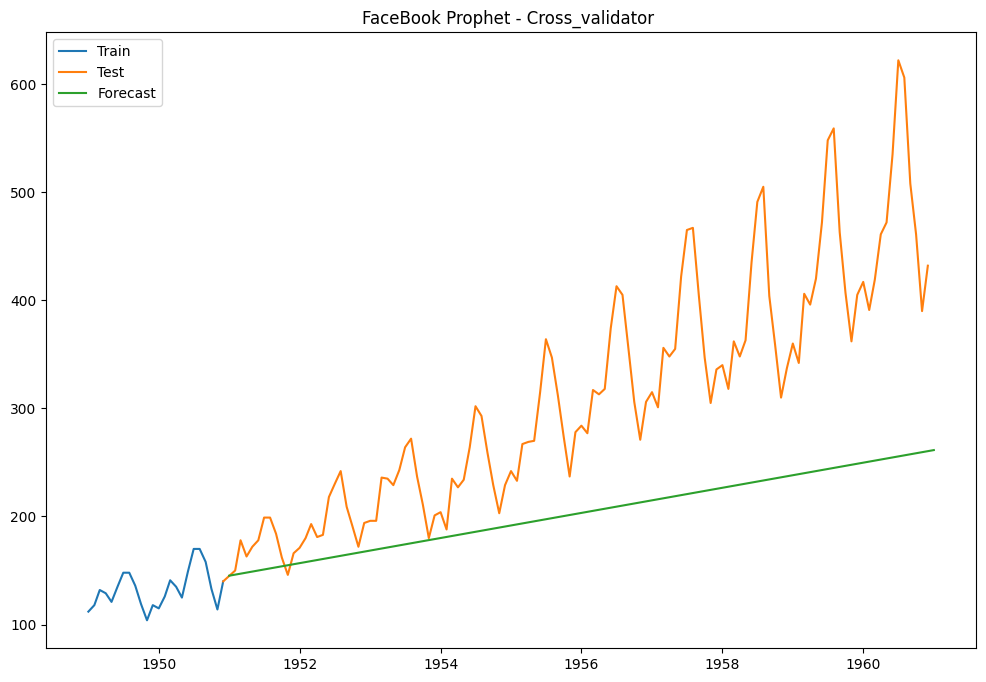

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntkfn3ct/4cn99mef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntkfn3ct/i5r1v0ei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85972', 'data', 'file=/tmp/tmpntkfn3ct/4cn99mef.json', 'init=/tmp/tmpntkfn3ct/i5r1v0ei.json', 'output', 'file=/tmp/tmpntkfn3ct/prophet_modelsc48h1j_/prophet_model-20230406145727.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:57:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


RMSE --->  132.47433100440776


14:57:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


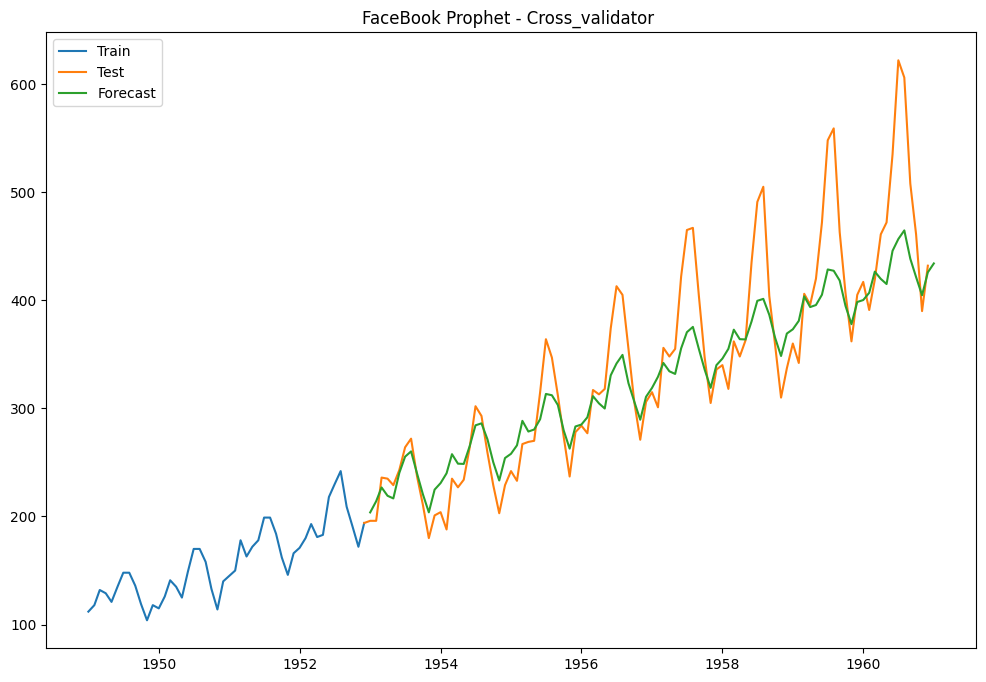

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntkfn3ct/8ich3psp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntkfn3ct/lc4ghh0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27518', 'data', 'file=/tmp/tmpntkfn3ct/8ich3psp.json', 'init=/tmp/tmpntkfn3ct/lc4ghh0v.json', 'output', 'file=/tmp/tmpntkfn3ct/prophet_model9g8ck67n/prophet_model-20230406145728.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:57:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


RMSE --->  49.54774098596513


14:57:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


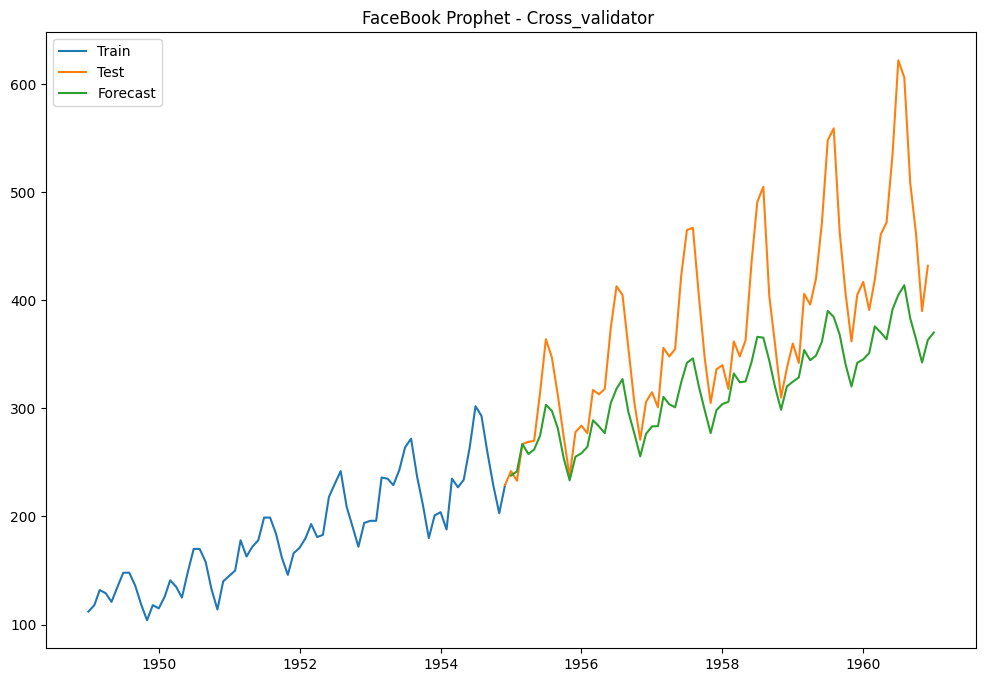

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntkfn3ct/ih8x31mr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntkfn3ct/_prdryuv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92538', 'data', 'file=/tmp/tmpntkfn3ct/ih8x31mr.json', 'init=/tmp/tmpntkfn3ct/_prdryuv.json', 'output', 'file=/tmp/tmpntkfn3ct/prophet_modelb0o0f1rf/prophet_model-20230406145728.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:57:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


RMSE --->  79.07505791533767


14:57:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


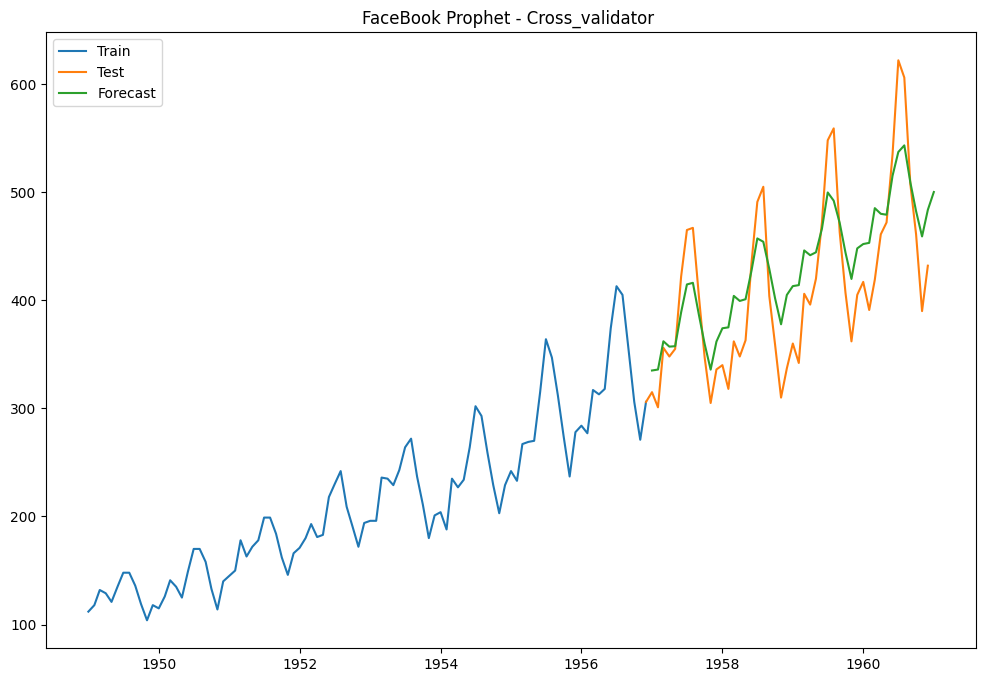

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntkfn3ct/btxq0taf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntkfn3ct/nrwkkd4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95623', 'data', 'file=/tmp/tmpntkfn3ct/btxq0taf.json', 'init=/tmp/tmpntkfn3ct/nrwkkd4u.json', 'output', 'file=/tmp/tmpntkfn3ct/prophet_modelgpe0os50/prophet_model-20230406145729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:57:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:57:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE --->  55.07037351466585


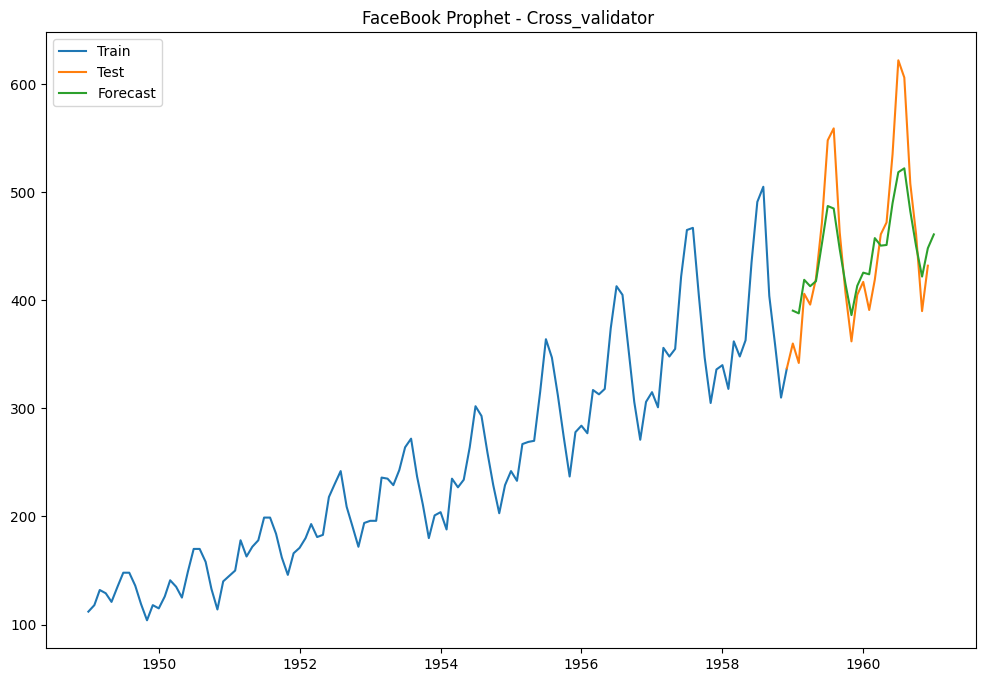

RMSE --->  54.443114821797735
Mean RMSE --> 74.12212364843484


In [ ]:
train_data,test_data  = Split(data_FB,Cross_validator = True)
Eval_list = []

for train,test in zip(train_data,test_data):
    forecast = []
    train_d = data_FB.iloc[train]
    test_d = data_FB.iloc[test]
    y_hat = test_d.copy()
    model = Prophet()
    model.fit(train_d)
    future_dates = model.make_future_dataframe(periods=len(test_d), freq='MS')
    forecast = model.predict(future_dates[-len(test_d):])
    plt.figure(figsize=(12,8))
    plt.plot(train_d['ds'], train_d['y'], label='Train')
    plt.plot(test_d['ds'],test_d['y'], label='Test')
    plt.plot(forecast['ds'],forecast['yhat'], label='Forecast')
    plt.legend(loc='best')
    plt.title("FaceBook Prophet - Cross_validator ")
    plt.show()
    Eval_list.append(np.sqrt(mean_squared_error(test_d['y'],forecast['yhat'])))
    Evalution(test_d['y'],forecast['yhat'])
print(f'Mean RMSE --> {np.mean(Eval_list)}')

# ْXGBOOST

In [ ]:

# Create lagged features
lags = 12
for i in range(1, lags+1):
    df[f'lag_{i}'] = df['Passengers'].shift(i)

# Split into training and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Prepare data for XGBoost Regressor
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]


# Fit XGBoost Regressor to training data
model = XGBRegressor(n_estimators=1000, learning_rate=0.01)
model.fit(X_train, y_train)


# Make predictions on test data
y_pred = model.predict(X_test)


print("RMSE %.2f" % mean_squared_error(y_test, y_pred, squared=False))

plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual')
plt.plot(df.index[-len(y_test):], y_pred, label='Predicted')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

UFuncTypeError: ignored

In [ ]:
import xgboost as xgb

train, test = fixed_partition(Data, 24)
lag = 12
train['passengers_lag'] = train['Passengers'].shift(lag)
test['passengers_lag'] = test['Passengers'].shift(lag)
train = train.dropna()
test = test.dropna()
X_train = train[['passengers_lag']]
y_train = train['Passengers']
X_test = test[['passengers_lag']]
y_test = test['Passengers']
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


plt.figure(figsize=(16,8))
plt.plot(train.index,y_train, label='Train')
plt.plot(test.index,y_test, label='Test')
plt.plot(test.index,y_pred, label = 'Forecast')
plt.legend(loc='best')
plt.show()


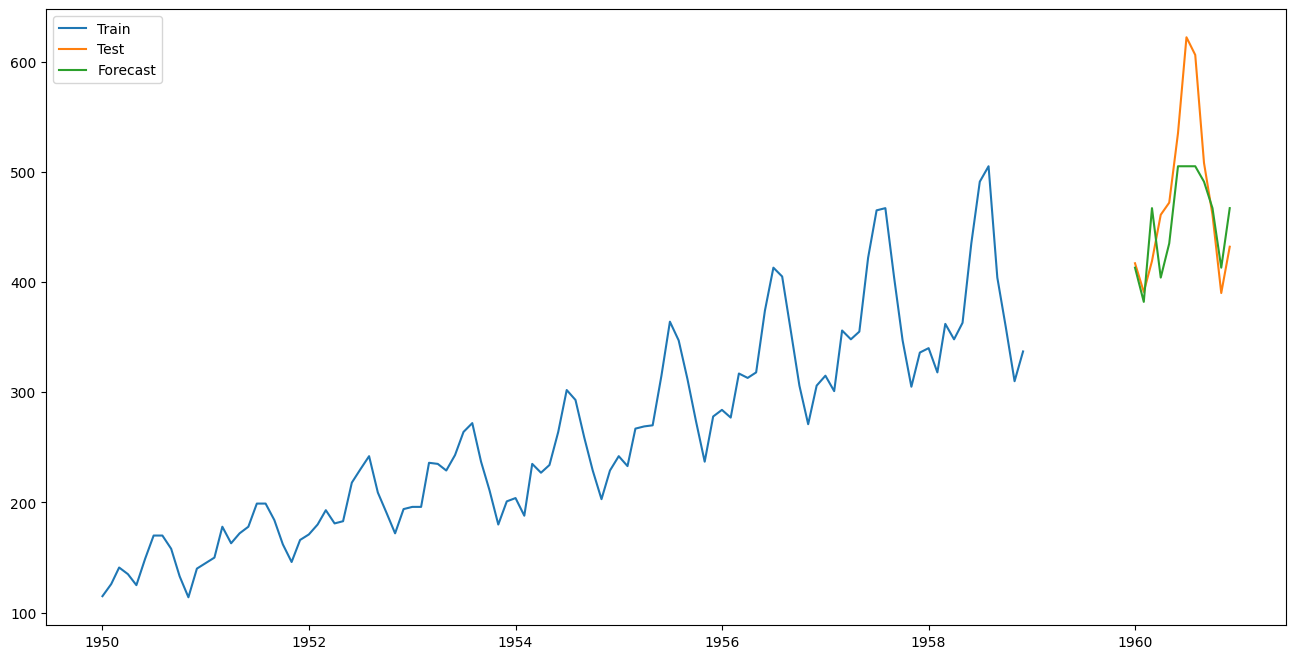

In [ ]:
Evalution(y_test,y_pred)

RMSE --->  53.14132128278107


## ROLL

In [ ]:
lag = 12

 ROOT Mean squared error: 190.28745397085285


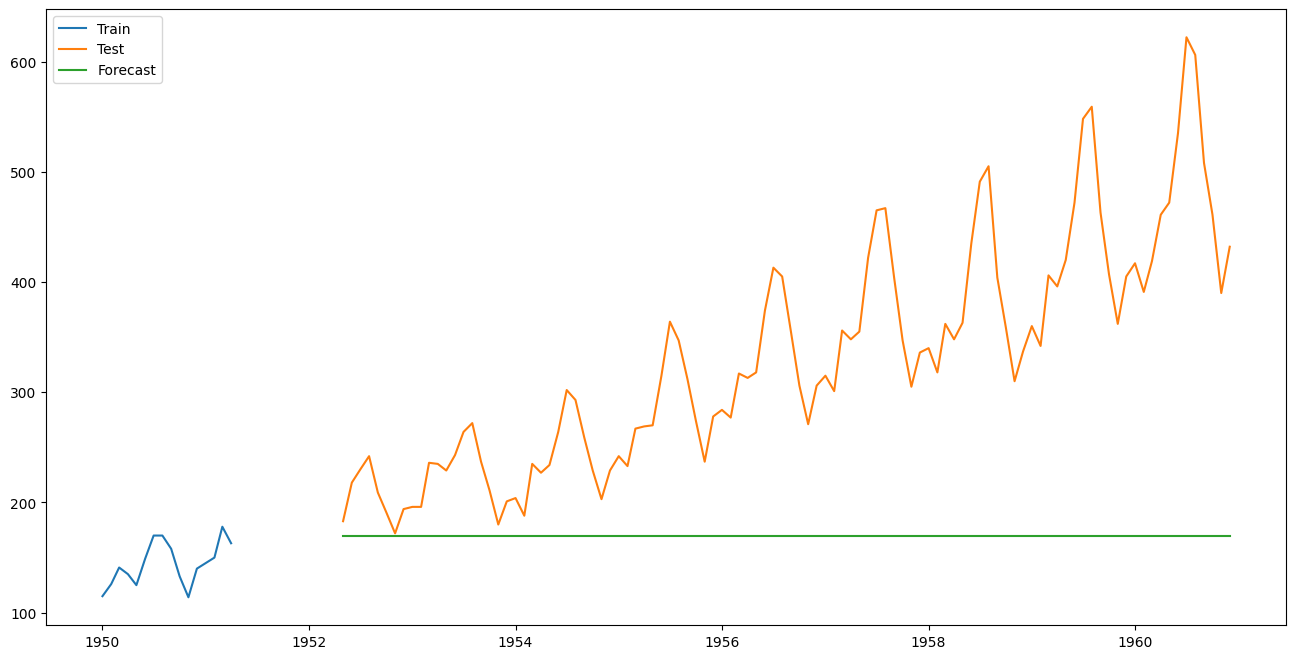

 ROOT Mean squared error: 133.2877751353123


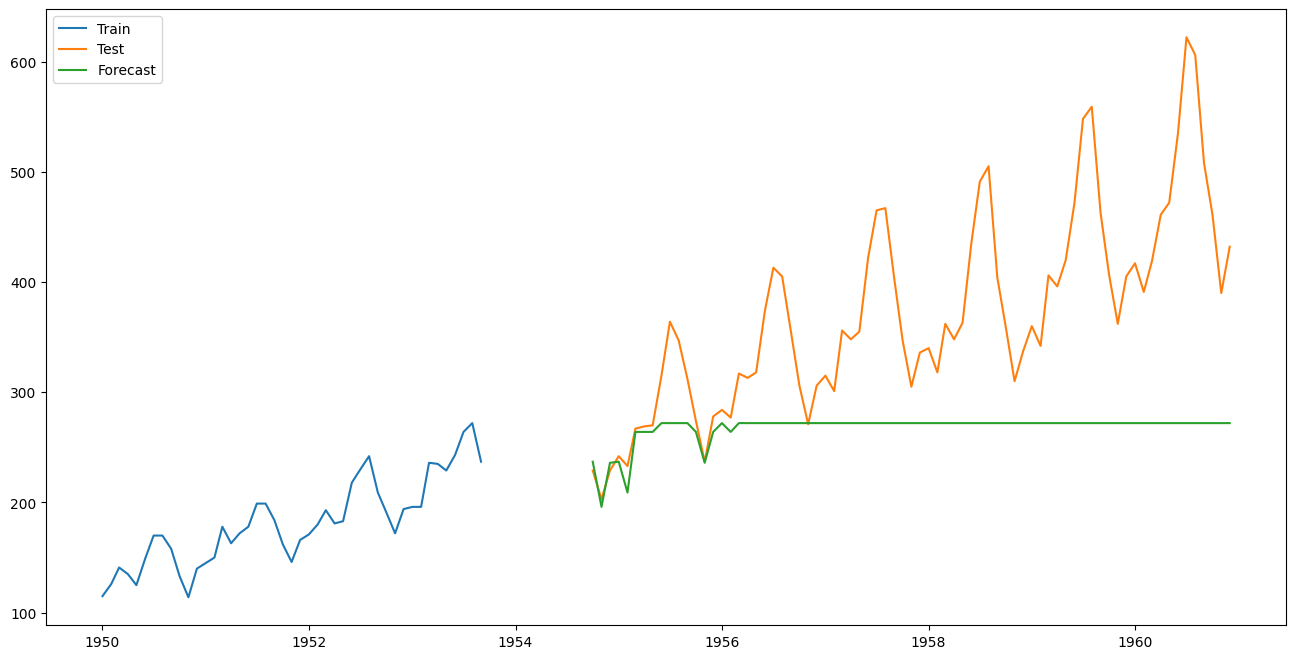

 ROOT Mean squared error: 92.97292495151194


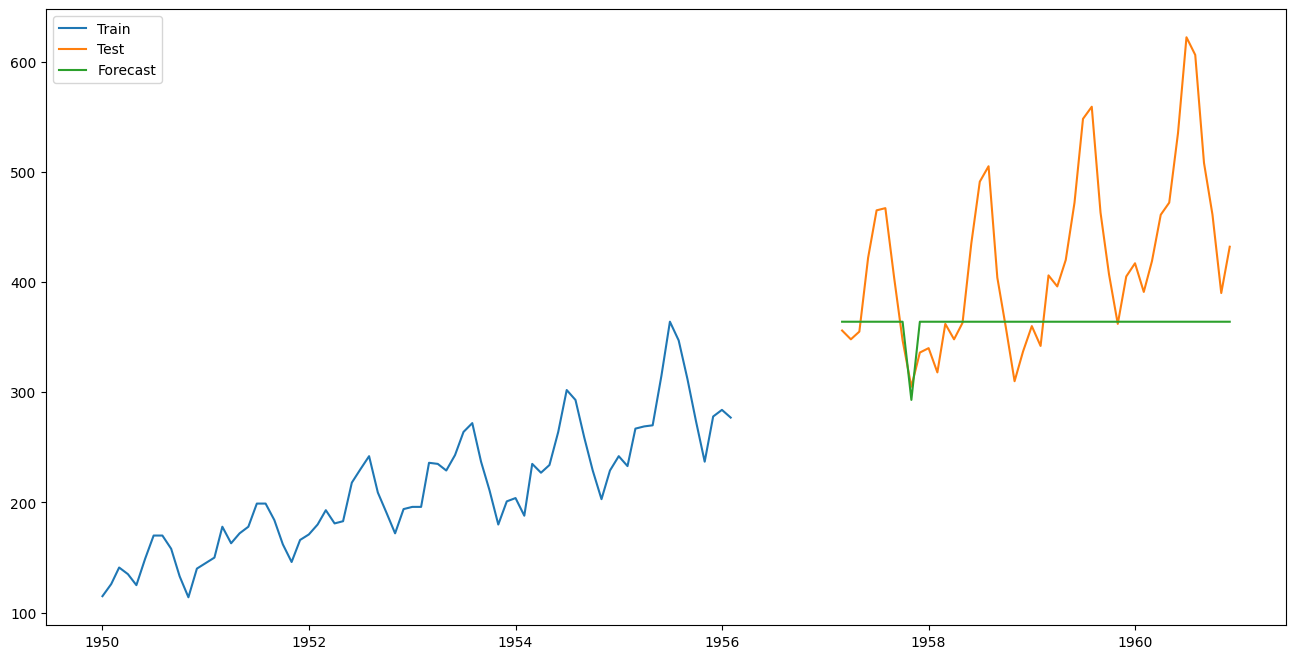

 ROOT Mean squared error: 51.503458065424056


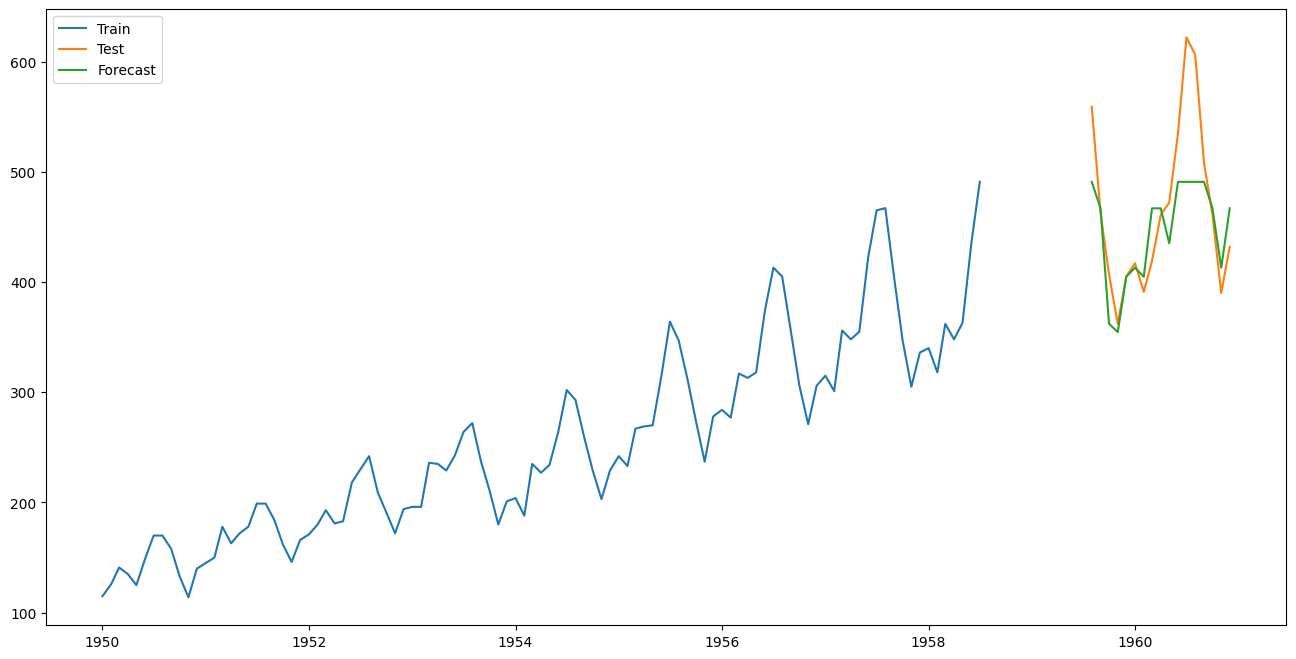

 ROOT Mean squared error: 53.17239545707222


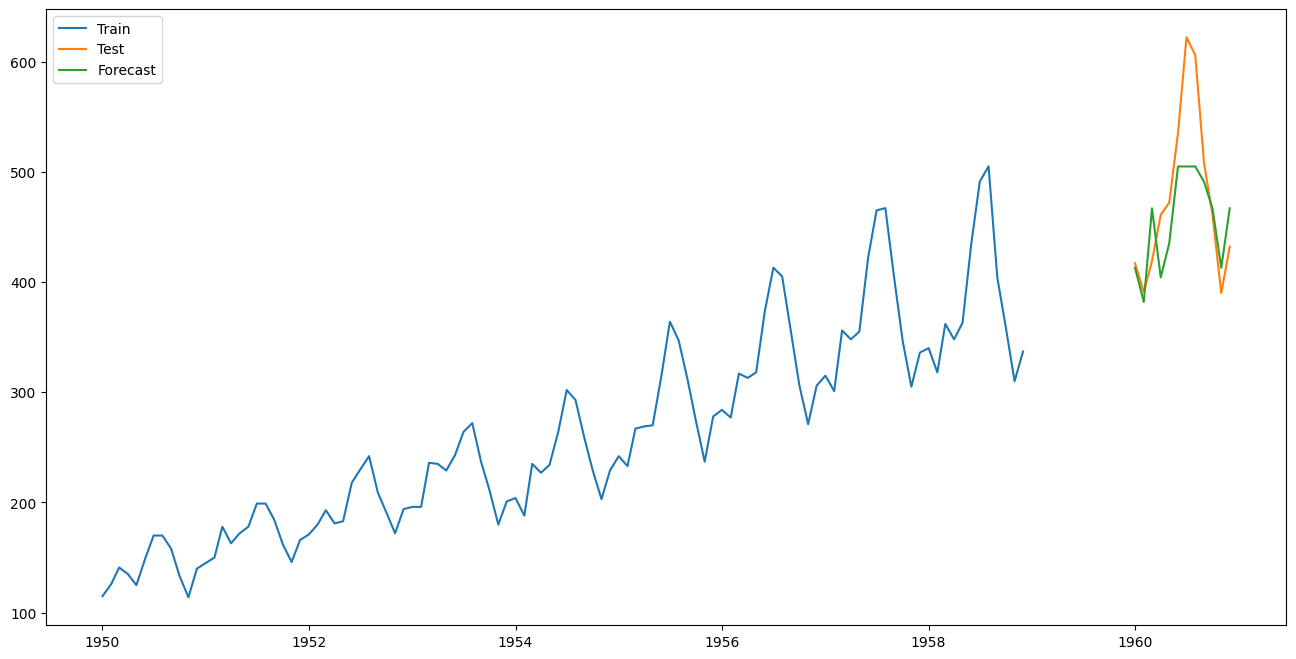

Total ROOT Mean squared error: 104.24480151603466


In [ ]:
splits = cross_validation(Data, n_splits=5)
errr= []
for train, test in splits:
    train['passengers_lag'] = train['Passengers'].shift(lag)
    test['passengers_lag'] = test['Passengers'].shift(lag)
    train = train.dropna()
    test = test.dropna()
    X_train = train[['passengers_lag']]
    y_train = train['Passengers']
    X_test = test[['passengers_lag']]
    y_test = test['Passengers']
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(' ROOT Mean squared error:', np.sqrt(mse))
    errr.append(np.sqrt(mse))
    plt.figure(figsize=(16,8))
    plt.plot(train.index,y_train, label='Train')
    plt.plot(test.index,y_test, label='Test')
    plt.plot(test.index,y_pred, label = 'Forecast')
    plt.legend(loc='best')
    plt.show()
print('Total ROOT Mean squared error:', np.mean(errr))

The XGBOOST model typically requires a large amount of data in order to effectively leverage the variety of lags available and achieve high performance. This is because having more data allows the model to better identify patterns and relationships between the target variable and its historical values. Therefore, when working with XGBOOST, it is important to ensure that sufficient data is available to achieve the best possible results

- "The XGBOOST regressor performed well on the fixed partition of the airline passengers dataset with a lag of 12, likely due to the significant amount of data available for training and testing.

- 


When using cross-validation on the airline passengers dataset, the overall root mean squared error (RMSE) was higher than in the fixed partition This may be due to the limited information available in each fold of the data, which can make it more difficult for the XGBOOST model to accurately predict passenger numbers.


We couldn't apply it in roll forward as it take lag 12 and the window of roll forward was with size 1 


  - it perfome quit good on fixed paration with lag 12 as it has a good amount of data   
  - We couldn't apply it in roll forward as it take lag 12 and the windo of roll forward was sith size 1 
  - in cross validaot the overall RMSE WAs high as it wasn't so good in predication with small inforamation of data 

  - overall XGBOOST need a large amount of data to have a variety for selecting lags and get high perfomance from yhe model 